In [14]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [15]:
!kaggle datasets download -d splcher/animefacedataset

import zipfile
zip_ref = zipfile.ZipFile('animefacedataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

In [21]:
dataroot = "/content/animefacedataset"
batch_size = 64
image_size = 64
nc = 3
z = 100
ngf = 64
ndf = 64
ngpu=1
lr = 0.0001
num_epochs = 50
mean_std = (0.5, 0.5, 0.5)

In [22]:
dataset = ImageFolder(root = dataroot,
                      transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean_std, mean_std)
                           ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 2)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() and ngpu>0 else "cpu")

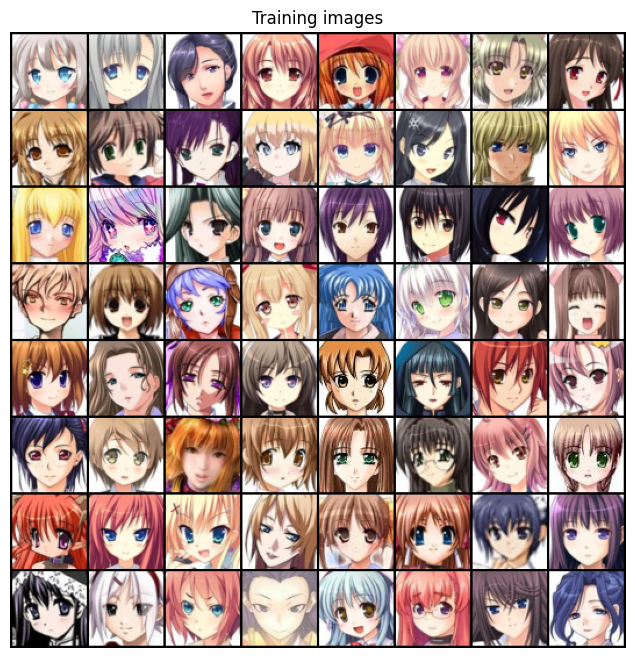

In [24]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

In [25]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [26]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            #input is z
            nn.ConvTranspose2d(z, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
    )

    def forward(self, input):
        return self.main(input)

In [27]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [28]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


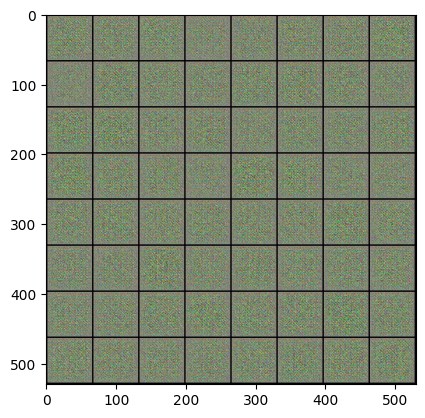

In [29]:
fixed_noise = torch.randn(batch_size, z, 1, 1, device=device)
fake = netG.forward(fixed_noise)
plt.imshow(np.transpose(make_grid(fake.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [30]:
loss = nn.BCELoss()

real_label = 1
fake_label = 0

optimD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []

G_losses = []
D_losses = []
iters = 0
from tqdm import tqdm

print('Training started...............')
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader, desc=f'Epoch {epoch}/{num_epochs}', leave=False)):

        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = loss(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, z, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = loss(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = loss(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}] [{i}/{len(dataloader)}] -> Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if iters%500 == 0 or (epoch == num_epochs-1 and i == len(dataloader)-1):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1

Training started...............


Epoch 0/50:   0%|          | 2/994 [00:01<09:14,  1.79it/s]

[0/50] [0/994] -> Loss_D: 1.8102 Loss_G: 2.0124 D(x): 0.3269 D(G(z)): 0.3629/0.1683


Epoch 0/50:   5%|▌         | 52/994 [00:05<01:09, 13.48it/s]

[0/50] [50/994] -> Loss_D: 0.0631 Loss_G: 7.0602 D(x): 0.9842 D(G(z)): 0.0429/0.0014


Epoch 0/50:  10%|█         | 102/994 [00:09<01:04, 13.86it/s]

[0/50] [100/994] -> Loss_D: 0.2442 Loss_G: 10.6040 D(x): 0.8984 D(G(z)): 0.0010/0.0001


Epoch 0/50:  15%|█▌        | 152/994 [00:13<01:03, 13.33it/s]

[0/50] [150/994] -> Loss_D: 0.2108 Loss_G: 7.5668 D(x): 0.9436 D(G(z)): 0.0923/0.0019


Epoch 0/50:  20%|██        | 201/994 [00:17<01:22,  9.65it/s]

[0/50] [200/994] -> Loss_D: 0.3540 Loss_G: 9.0787 D(x): 0.9496 D(G(z)): 0.2052/0.0002


Epoch 0/50:  25%|██▌       | 253/994 [00:21<00:54, 13.56it/s]

[0/50] [250/994] -> Loss_D: 0.1143 Loss_G: 5.4125 D(x): 0.9654 D(G(z)): 0.0564/0.0075


Epoch 0/50:  30%|███       | 303/994 [00:25<00:51, 13.36it/s]

[0/50] [300/994] -> Loss_D: 0.4054 Loss_G: 12.6177 D(x): 0.9790 D(G(z)): 0.2683/0.0000


Epoch 0/50:  35%|███▌      | 351/994 [00:28<00:52, 12.22it/s]

[0/50] [350/994] -> Loss_D: 0.2199 Loss_G: 6.8337 D(x): 0.8819 D(G(z)): 0.0140/0.0021


Epoch 0/50:  40%|████      | 402/994 [00:33<00:46, 12.71it/s]

[0/50] [400/994] -> Loss_D: 0.1049 Loss_G: 6.5328 D(x): 0.9552 D(G(z)): 0.0514/0.0027


Epoch 0/50:  45%|████▌     | 452/994 [00:37<00:41, 13.06it/s]

[0/50] [450/994] -> Loss_D: 0.2514 Loss_G: 11.3702 D(x): 0.9853 D(G(z)): 0.1926/0.0000


Epoch 0/50:  51%|█████     | 502/994 [00:41<00:38, 12.91it/s]

[0/50] [500/994] -> Loss_D: 0.2577 Loss_G: 9.2934 D(x): 0.8491 D(G(z)): 0.0047/0.0004


Epoch 0/50:  56%|█████▌    | 552/994 [00:45<00:42, 10.36it/s]

[0/50] [550/994] -> Loss_D: 0.5245 Loss_G: 6.4789 D(x): 0.7013 D(G(z)): 0.0019/0.0033


Epoch 0/50:  61%|██████    | 603/994 [00:49<00:29, 13.27it/s]

[0/50] [600/994] -> Loss_D: 0.5501 Loss_G: 6.6788 D(x): 0.9928 D(G(z)): 0.3514/0.0050


Epoch 0/50:  66%|██████▌   | 653/994 [00:53<00:25, 13.26it/s]

[0/50] [650/994] -> Loss_D: 0.3073 Loss_G: 2.7417 D(x): 0.8097 D(G(z)): 0.0293/0.1115


Epoch 0/50:  71%|███████   | 703/994 [00:57<00:22, 12.85it/s]

[0/50] [700/994] -> Loss_D: 0.6277 Loss_G: 2.7566 D(x): 0.6997 D(G(z)): 0.0094/0.0888


Epoch 0/50:  76%|███████▌  | 752/994 [01:02<00:20, 11.98it/s]

[0/50] [750/994] -> Loss_D: 0.4985 Loss_G: 8.4385 D(x): 0.9193 D(G(z)): 0.2693/0.0005


Epoch 0/50:  81%|████████  | 802/994 [01:06<00:16, 11.95it/s]

[0/50] [800/994] -> Loss_D: 0.6157 Loss_G: 10.1012 D(x): 0.9556 D(G(z)): 0.3563/0.0001


Epoch 0/50:  86%|████████▌ | 851/994 [01:10<00:12, 11.56it/s]

[0/50] [850/994] -> Loss_D: 0.3095 Loss_G: 6.0272 D(x): 0.9295 D(G(z)): 0.1430/0.0048


Epoch 0/50:  91%|█████████ | 902/994 [01:17<00:07, 12.41it/s]

[0/50] [900/994] -> Loss_D: 0.5891 Loss_G: 4.6097 D(x): 0.7287 D(G(z)): 0.0399/0.0222


Epoch 0/50:  96%|█████████▌| 952/994 [01:20<00:03, 13.16it/s]

[0/50] [950/994] -> Loss_D: 0.0650 Loss_G: 7.5496 D(x): 0.9623 D(G(z)): 0.0138/0.0010


Epoch 1/50:   0%|          | 2/994 [00:00<03:44,  4.41it/s]

[1/50] [0/994] -> Loss_D: 0.2350 Loss_G: 5.6798 D(x): 0.8504 D(G(z)): 0.0355/0.0073


Epoch 1/50:   5%|▌         | 52/994 [00:05<01:28, 10.68it/s]

[1/50] [50/994] -> Loss_D: 0.5711 Loss_G: 11.6106 D(x): 0.9569 D(G(z)): 0.3572/0.0000


Epoch 1/50:  10%|█         | 102/994 [00:10<01:07, 13.25it/s]

[1/50] [100/994] -> Loss_D: 0.7787 Loss_G: 9.1718 D(x): 0.8564 D(G(z)): 0.3467/0.0002


Epoch 1/50:  15%|█▌        | 152/994 [00:13<01:03, 13.19it/s]

[1/50] [150/994] -> Loss_D: 0.2280 Loss_G: 4.5473 D(x): 0.8937 D(G(z)): 0.0127/0.0193


Epoch 1/50:  20%|██        | 202/994 [00:17<00:58, 13.60it/s]

[1/50] [200/994] -> Loss_D: 0.1553 Loss_G: 6.1032 D(x): 0.8989 D(G(z)): 0.0065/0.0048


Epoch 1/50:  25%|██▌       | 252/994 [00:22<01:10, 10.55it/s]

[1/50] [250/994] -> Loss_D: 0.6030 Loss_G: 3.3623 D(x): 0.7027 D(G(z)): 0.0108/0.0528


Epoch 1/50:  30%|███       | 302/994 [00:26<00:51, 13.54it/s]

[1/50] [300/994] -> Loss_D: 0.0508 Loss_G: 12.9942 D(x): 0.9561 D(G(z)): 0.0006/0.0000


Epoch 1/50:  35%|███▌      | 352/994 [00:29<00:47, 13.45it/s]

[1/50] [350/994] -> Loss_D: 0.3153 Loss_G: 4.3020 D(x): 0.8722 D(G(z)): 0.1013/0.0238


Epoch 1/50:  40%|████      | 402/994 [00:33<00:58, 10.05it/s]

[1/50] [400/994] -> Loss_D: 0.2616 Loss_G: 7.7428 D(x): 0.8581 D(G(z)): 0.0005/0.0028


Epoch 1/50:  46%|████▌     | 453/994 [00:38<00:41, 13.14it/s]

[1/50] [450/994] -> Loss_D: 0.1789 Loss_G: 6.0750 D(x): 0.8909 D(G(z)): 0.0407/0.0070


Epoch 1/50:  51%|█████     | 503/994 [00:42<00:37, 13.23it/s]

[1/50] [500/994] -> Loss_D: 0.4534 Loss_G: 10.3323 D(x): 0.9668 D(G(z)): 0.3025/0.0001


Epoch 1/50:  56%|█████▌    | 553/994 [00:45<00:32, 13.38it/s]

[1/50] [550/994] -> Loss_D: 0.5685 Loss_G: 9.3774 D(x): 0.9825 D(G(z)): 0.3492/0.0002


Epoch 1/50:  60%|██████    | 601/994 [00:50<00:37, 10.43it/s]

[1/50] [600/994] -> Loss_D: 0.3213 Loss_G: 4.4925 D(x): 0.8223 D(G(z)): 0.0475/0.0182


Epoch 1/50:  66%|██████▌   | 652/994 [00:54<00:25, 13.37it/s]

[1/50] [650/994] -> Loss_D: 0.1786 Loss_G: 5.4682 D(x): 0.8851 D(G(z)): 0.0260/0.0083


Epoch 1/50:  71%|███████   | 702/994 [00:58<00:21, 13.39it/s]

[1/50] [700/994] -> Loss_D: 0.1279 Loss_G: 5.8504 D(x): 0.9345 D(G(z)): 0.0416/0.0056


Epoch 1/50:  76%|███████▌  | 752/994 [01:02<00:23, 10.14it/s]

[1/50] [750/994] -> Loss_D: 0.5865 Loss_G: 3.8430 D(x): 0.6649 D(G(z)): 0.0063/0.0421


Epoch 1/50:  81%|████████  | 802/994 [01:06<00:14, 13.28it/s]

[1/50] [800/994] -> Loss_D: 0.2252 Loss_G: 5.2237 D(x): 0.9642 D(G(z)): 0.1424/0.0112


Epoch 1/50:  86%|████████▌ | 852/994 [01:10<00:10, 13.50it/s]

[1/50] [850/994] -> Loss_D: 0.5115 Loss_G: 9.3093 D(x): 0.9667 D(G(z)): 0.3334/0.0002


Epoch 1/50:  91%|█████████ | 902/994 [01:14<00:06, 13.37it/s]

[1/50] [900/994] -> Loss_D: 0.2825 Loss_G: 5.2754 D(x): 0.8927 D(G(z)): 0.1358/0.0077


Epoch 1/50:  96%|█████████▌| 953/994 [01:18<00:03, 10.32it/s]

[1/50] [950/994] -> Loss_D: 0.2700 Loss_G: 7.1551 D(x): 0.9373 D(G(z)): 0.1548/0.0019


Epoch 2/50:   0%|          | 3/994 [00:00<02:37,  6.29it/s]

[2/50] [0/994] -> Loss_D: 0.1613 Loss_G: 5.5814 D(x): 0.9299 D(G(z)): 0.0267/0.0099


Epoch 2/50:   5%|▌         | 53/994 [00:05<01:43,  9.08it/s]

[2/50] [50/994] -> Loss_D: 0.2730 Loss_G: 2.9816 D(x): 0.8359 D(G(z)): 0.0475/0.0740


Epoch 2/50:  10%|█         | 103/994 [00:09<01:20, 11.10it/s]

[2/50] [100/994] -> Loss_D: 0.3042 Loss_G: 6.6208 D(x): 0.9334 D(G(z)): 0.1779/0.0022


Epoch 2/50:  15%|█▌        | 152/994 [00:13<01:03, 13.23it/s]

[2/50] [150/994] -> Loss_D: 0.2033 Loss_G: 4.8504 D(x): 0.8739 D(G(z)): 0.0115/0.0226


Epoch 2/50:  20%|██        | 202/994 [00:17<01:00, 13.18it/s]

[2/50] [200/994] -> Loss_D: 0.1150 Loss_G: 4.9383 D(x): 0.9365 D(G(z)): 0.0392/0.0131


Epoch 2/50:  25%|██▌       | 252/994 [00:21<00:55, 13.43it/s]

[2/50] [250/994] -> Loss_D: 0.4019 Loss_G: 6.7617 D(x): 0.9372 D(G(z)): 0.2207/0.0035


Epoch 2/50:  30%|███       | 302/994 [00:25<01:07, 10.22it/s]

[2/50] [300/994] -> Loss_D: 0.5435 Loss_G: 9.7566 D(x): 0.9595 D(G(z)): 0.3051/0.0002


Epoch 2/50:  35%|███▌      | 352/994 [00:29<00:48, 13.28it/s]

[2/50] [350/994] -> Loss_D: 0.1621 Loss_G: 8.2583 D(x): 0.8833 D(G(z)): 0.0040/0.0011


Epoch 2/50:  40%|████      | 402/994 [00:33<00:45, 13.06it/s]

[2/50] [400/994] -> Loss_D: 0.1035 Loss_G: 5.4169 D(x): 0.9537 D(G(z)): 0.0468/0.0083


Epoch 2/50:  45%|████▌     | 452/994 [00:37<00:46, 11.71it/s]

[2/50] [450/994] -> Loss_D: 0.1382 Loss_G: 5.7572 D(x): 0.9493 D(G(z)): 0.0592/0.0069


Epoch 2/50:  51%|█████     | 503/994 [00:42<00:38, 12.69it/s]

[2/50] [500/994] -> Loss_D: 0.1281 Loss_G: 5.0759 D(x): 0.9711 D(G(z)): 0.0821/0.0139


Epoch 2/50:  56%|█████▌    | 553/994 [00:45<00:33, 13.29it/s]

[2/50] [550/994] -> Loss_D: 0.2442 Loss_G: 5.3342 D(x): 0.8344 D(G(z)): 0.0114/0.0122


Epoch 2/50:  61%|██████    | 603/994 [00:49<00:30, 12.93it/s]

[2/50] [600/994] -> Loss_D: 0.1760 Loss_G: 4.6665 D(x): 0.9317 D(G(z)): 0.0577/0.0147


Epoch 2/50:  65%|██████▌   | 651/994 [00:53<00:35,  9.79it/s]

[2/50] [650/994] -> Loss_D: 0.1919 Loss_G: 6.8172 D(x): 0.9522 D(G(z)): 0.1232/0.0019


Epoch 2/50:  71%|███████   | 703/994 [00:58<00:22, 13.18it/s]

[2/50] [700/994] -> Loss_D: 0.1972 Loss_G: 5.7869 D(x): 0.9269 D(G(z)): 0.0819/0.0057


Epoch 2/50:  76%|███████▌  | 753/994 [01:02<00:18, 13.09it/s]

[2/50] [750/994] -> Loss_D: 0.1543 Loss_G: 5.3327 D(x): 0.9566 D(G(z)): 0.0837/0.0080


Epoch 2/50:  81%|████████  | 803/994 [01:05<00:14, 12.89it/s]

[2/50] [800/994] -> Loss_D: 0.2104 Loss_G: 5.6340 D(x): 0.8487 D(G(z)): 0.0093/0.0075


Epoch 2/50:  86%|████████▌ | 852/994 [01:10<00:15,  9.44it/s]

[2/50] [850/994] -> Loss_D: 0.1114 Loss_G: 6.0800 D(x): 0.9644 D(G(z)): 0.0639/0.0037


Epoch 2/50:  91%|█████████ | 902/994 [01:14<00:06, 13.18it/s]

[2/50] [900/994] -> Loss_D: 0.0787 Loss_G: 4.6388 D(x): 0.9656 D(G(z)): 0.0385/0.0167


Epoch 2/50:  96%|█████████▌| 952/994 [01:18<00:03, 12.04it/s]

[2/50] [950/994] -> Loss_D: 0.4621 Loss_G: 11.5068 D(x): 0.9860 D(G(z)): 0.3100/0.0001


Epoch 3/50:   0%|          | 3/994 [00:00<02:40,  6.17it/s]

[3/50] [0/994] -> Loss_D: 0.2971 Loss_G: 8.4566 D(x): 0.9651 D(G(z)): 0.2050/0.0004


Epoch 3/50:   5%|▌         | 53/994 [00:04<01:20, 11.66it/s]

[3/50] [50/994] -> Loss_D: 0.2186 Loss_G: 5.9652 D(x): 0.9505 D(G(z)): 0.1225/0.0069


Epoch 3/50:  10%|█         | 103/994 [00:09<01:13, 12.12it/s]

[3/50] [100/994] -> Loss_D: 0.1209 Loss_G: 5.0635 D(x): 0.9497 D(G(z)): 0.0530/0.0105


Epoch 3/50:  15%|█▌        | 153/994 [00:14<01:21, 10.30it/s]

[3/50] [150/994] -> Loss_D: 0.2170 Loss_G: 8.0504 D(x): 0.9915 D(G(z)): 0.1521/0.0009


Epoch 3/50:  20%|██        | 203/994 [00:19<01:08, 11.50it/s]

[3/50] [200/994] -> Loss_D: 0.1601 Loss_G: 5.0768 D(x): 0.8721 D(G(z)): 0.0019/0.0138


Epoch 3/50:  25%|██▌       | 253/994 [00:23<01:04, 11.42it/s]

[3/50] [250/994] -> Loss_D: 0.1704 Loss_G: 6.3591 D(x): 0.9495 D(G(z)): 0.0994/0.0028


Epoch 3/50:  30%|███       | 302/994 [00:29<00:58, 11.75it/s]

[3/50] [300/994] -> Loss_D: 0.6342 Loss_G: 7.5229 D(x): 0.6544 D(G(z)): 0.0002/0.0018


Epoch 3/50:  35%|███▌      | 352/994 [00:33<00:48, 13.16it/s]

[3/50] [350/994] -> Loss_D: 0.1268 Loss_G: 5.3904 D(x): 0.9656 D(G(z)): 0.0747/0.0090


Epoch 3/50:  40%|████      | 402/994 [00:37<00:44, 13.19it/s]

[3/50] [400/994] -> Loss_D: 0.3322 Loss_G: 10.5177 D(x): 0.9769 D(G(z)): 0.1709/0.0001


Epoch 3/50:  46%|████▌     | 453/994 [00:44<00:58,  9.25it/s]

[3/50] [450/994] -> Loss_D: 0.2741 Loss_G: 4.9936 D(x): 0.8621 D(G(z)): 0.0753/0.0154


Epoch 3/50:  51%|█████     | 503/994 [00:48<00:41, 11.84it/s]

[3/50] [500/994] -> Loss_D: 0.2038 Loss_G: 8.4713 D(x): 0.8675 D(G(z)): 0.0073/0.0024


Epoch 3/50:  56%|█████▌    | 553/994 [00:52<00:33, 13.21it/s]

[3/50] [550/994] -> Loss_D: 0.1065 Loss_G: 5.9789 D(x): 0.9456 D(G(z)): 0.0416/0.0055


Epoch 3/50:  61%|██████    | 602/994 [00:56<00:34, 11.25it/s]

[3/50] [600/994] -> Loss_D: 0.1324 Loss_G: 5.6285 D(x): 0.9480 D(G(z)): 0.0626/0.0081


Epoch 3/50:  66%|██████▌   | 652/994 [01:00<00:25, 13.37it/s]

[3/50] [650/994] -> Loss_D: 0.1605 Loss_G: 13.8999 D(x): 0.9107 D(G(z)): 0.0001/0.0000


Epoch 3/50:  70%|███████   | 700/994 [01:04<00:26, 10.99it/s]

[3/50] [700/994] -> Loss_D: 0.1165 Loss_G: 5.5837 D(x): 0.9629 D(G(z)): 0.0699/0.0066


Epoch 3/50:  76%|███████▌  | 751/994 [01:11<00:34,  7.07it/s]

[3/50] [750/994] -> Loss_D: 0.2330 Loss_G: 8.3548 D(x): 0.9593 D(G(z)): 0.1546/0.0005


Epoch 3/50:  81%|████████  | 802/994 [01:16<00:16, 12.00it/s]

[3/50] [800/994] -> Loss_D: 0.0837 Loss_G: 5.6747 D(x): 0.9665 D(G(z)): 0.0421/0.0085


Epoch 3/50:  86%|████████▌ | 852/994 [01:20<00:10, 12.98it/s]

[3/50] [850/994] -> Loss_D: 0.2281 Loss_G: 8.6231 D(x): 0.9889 D(G(z)): 0.1475/0.0006


Epoch 3/50:  91%|█████████ | 902/994 [01:24<00:09,  9.35it/s]

[3/50] [900/994] -> Loss_D: 0.1464 Loss_G: 4.5256 D(x): 0.9028 D(G(z)): 0.0204/0.0225


Epoch 3/50:  96%|█████████▌| 952/994 [01:29<00:03, 11.85it/s]

[3/50] [950/994] -> Loss_D: 0.3779 Loss_G: 5.6781 D(x): 0.7718 D(G(z)): 0.0012/0.0059


Epoch 4/50:   0%|          | 3/994 [00:00<02:07,  7.78it/s]

[4/50] [0/994] -> Loss_D: 0.2543 Loss_G: 8.6889 D(x): 0.8303 D(G(z)): 0.0029/0.0022


Epoch 4/50:   5%|▌         | 53/994 [00:04<01:11, 13.10it/s]

[4/50] [50/994] -> Loss_D: 0.2405 Loss_G: 4.3571 D(x): 0.8361 D(G(z)): 0.0068/0.0284


Epoch 4/50:  10%|█         | 103/994 [00:09<01:18, 11.36it/s]

[4/50] [100/994] -> Loss_D: 0.1845 Loss_G: 5.8099 D(x): 0.8780 D(G(z)): 0.0077/0.0075


Epoch 4/50:  15%|█▌        | 153/994 [00:12<01:03, 13.23it/s]

[4/50] [150/994] -> Loss_D: 0.0998 Loss_G: 5.0687 D(x): 0.9428 D(G(z)): 0.0320/0.0120


Epoch 4/50:  20%|██        | 203/994 [00:16<01:00, 13.11it/s]

[4/50] [200/994] -> Loss_D: 0.2509 Loss_G: 3.4548 D(x): 0.8763 D(G(z)): 0.0340/0.0484


Epoch 4/50:  25%|██▌       | 251/994 [00:20<01:12, 10.20it/s]

[4/50] [250/994] -> Loss_D: 0.1712 Loss_G: 8.0979 D(x): 0.8951 D(G(z)): 0.0011/0.0006


Epoch 4/50:  30%|███       | 303/994 [00:25<00:52, 13.21it/s]

[4/50] [300/994] -> Loss_D: 1.7485 Loss_G: 5.7298 D(x): 0.3438 D(G(z)): 0.0000/0.0189


Epoch 4/50:  36%|███▌      | 353/994 [00:29<00:48, 13.11it/s]

[4/50] [350/994] -> Loss_D: 0.0666 Loss_G: 5.3189 D(x): 0.9592 D(G(z)): 0.0159/0.0208


Epoch 4/50:  41%|████      | 403/994 [00:33<00:55, 10.74it/s]

[4/50] [400/994] -> Loss_D: 0.0728 Loss_G: 6.1657 D(x): 0.9771 D(G(z)): 0.0378/0.0054


Epoch 4/50:  45%|████▌     | 452/994 [00:37<00:53, 10.16it/s]

[4/50] [450/994] -> Loss_D: 0.0878 Loss_G: 5.4705 D(x): 0.9814 D(G(z)): 0.0619/0.0087


Epoch 4/50:  51%|█████     | 502/994 [00:41<00:37, 13.00it/s]

[4/50] [500/994] -> Loss_D: 0.2366 Loss_G: 7.8647 D(x): 0.9828 D(G(z)): 0.1784/0.0008


Epoch 4/50:  56%|█████▌    | 552/994 [00:45<00:32, 13.46it/s]

[4/50] [550/994] -> Loss_D: 0.1182 Loss_G: 4.8286 D(x): 0.9609 D(G(z)): 0.0678/0.0153


Epoch 4/50:  61%|██████    | 602/994 [00:49<00:35, 10.94it/s]

[4/50] [600/994] -> Loss_D: 0.1415 Loss_G: 5.9566 D(x): 0.9088 D(G(z)): 0.0123/0.0073


Epoch 4/50:  66%|██████▌   | 652/994 [00:53<00:26, 12.98it/s]

[4/50] [650/994] -> Loss_D: 0.1322 Loss_G: 5.8515 D(x): 0.9388 D(G(z)): 0.0481/0.0073


Epoch 4/50:  71%|███████   | 702/994 [00:57<00:22, 13.20it/s]

[4/50] [700/994] -> Loss_D: 0.0622 Loss_G: 6.0678 D(x): 0.9526 D(G(z)): 0.0086/0.0060


Epoch 4/50:  76%|███████▌  | 752/994 [01:01<00:18, 13.23it/s]

[4/50] [750/994] -> Loss_D: 0.8398 Loss_G: 3.6916 D(x): 0.5764 D(G(z)): 0.0005/0.0527


Epoch 4/50:  81%|████████  | 802/994 [01:05<00:17, 10.74it/s]

[4/50] [800/994] -> Loss_D: 0.3929 Loss_G: 11.6914 D(x): 0.9671 D(G(z)): 0.2707/0.0000


Epoch 4/50:  86%|████████▌ | 852/994 [01:09<00:10, 13.01it/s]

[4/50] [850/994] -> Loss_D: 0.1095 Loss_G: 4.7005 D(x): 0.9429 D(G(z)): 0.0398/0.0162


Epoch 4/50:  91%|█████████ | 902/994 [01:13<00:07, 13.14it/s]

[4/50] [900/994] -> Loss_D: 0.2230 Loss_G: 8.6863 D(x): 0.9878 D(G(z)): 0.1710/0.0004


Epoch 4/50:  96%|█████████▌| 952/994 [01:17<00:03, 12.15it/s]

[4/50] [950/994] -> Loss_D: 0.1323 Loss_G: 5.7414 D(x): 0.9430 D(G(z)): 0.0499/0.0064


Epoch 5/50:   0%|          | 3/994 [00:00<02:05,  7.88it/s]

[5/50] [0/994] -> Loss_D: 0.2776 Loss_G: 5.0711 D(x): 0.8958 D(G(z)): 0.1025/0.0153


Epoch 5/50:   5%|▌         | 53/994 [00:04<01:11, 13.18it/s]

[5/50] [50/994] -> Loss_D: 0.1358 Loss_G: 5.9561 D(x): 0.9658 D(G(z)): 0.0838/0.0047


Epoch 5/50:  10%|█         | 103/994 [00:08<01:07, 13.25it/s]

[5/50] [100/994] -> Loss_D: 0.1171 Loss_G: 7.5097 D(x): 0.9115 D(G(z)): 0.0007/0.0013


Epoch 5/50:  15%|█▌        | 151/994 [00:12<01:26,  9.75it/s]

[5/50] [150/994] -> Loss_D: 0.2090 Loss_G: 3.4723 D(x): 0.8973 D(G(z)): 0.0318/0.0531


Epoch 5/50:  20%|██        | 203/994 [00:16<01:00, 13.12it/s]

[5/50] [200/994] -> Loss_D: 0.2531 Loss_G: 3.1440 D(x): 0.8614 D(G(z)): 0.0143/0.0678


Epoch 5/50:  25%|██▌       | 253/994 [00:20<00:57, 12.96it/s]

[5/50] [250/994] -> Loss_D: 0.0917 Loss_G: 7.0965 D(x): 0.9418 D(G(z)): 0.0198/0.0039


Epoch 5/50:  30%|███       | 303/994 [00:24<00:57, 11.96it/s]

[5/50] [300/994] -> Loss_D: 0.1743 Loss_G: 6.3127 D(x): 0.9678 D(G(z)): 0.1160/0.0040


Epoch 5/50:  36%|███▌      | 353/994 [00:29<00:50, 12.66it/s]

[5/50] [350/994] -> Loss_D: 0.6346 Loss_G: 14.0782 D(x): 0.9998 D(G(z)): 0.3309/0.0000


Epoch 5/50:  41%|████      | 403/994 [00:33<00:45, 13.13it/s]

[5/50] [400/994] -> Loss_D: 0.2820 Loss_G: 6.7583 D(x): 0.7991 D(G(z)): 0.0066/0.0039


Epoch 5/50:  45%|████▌     | 451/994 [00:36<00:42, 12.78it/s]

[5/50] [450/994] -> Loss_D: 0.2302 Loss_G: 6.4225 D(x): 0.9419 D(G(z)): 0.1344/0.0029


Epoch 5/50:  50%|█████     | 501/994 [00:42<00:53,  9.19it/s]

[5/50] [500/994] -> Loss_D: 0.2062 Loss_G: 5.1150 D(x): 0.8654 D(G(z)): 0.0178/0.0167


Epoch 5/50:  56%|█████▌    | 553/994 [00:47<00:33, 13.15it/s]

[5/50] [550/994] -> Loss_D: 0.1260 Loss_G: 5.3216 D(x): 0.9380 D(G(z)): 0.0487/0.0110


Epoch 5/50:  61%|██████    | 603/994 [00:50<00:28, 13.50it/s]

[5/50] [600/994] -> Loss_D: 0.2661 Loss_G: 2.8682 D(x): 0.8504 D(G(z)): 0.0412/0.0960


Epoch 5/50:  66%|██████▌   | 653/994 [00:54<00:26, 13.07it/s]

[5/50] [650/994] -> Loss_D: 0.1569 Loss_G: 4.7760 D(x): 0.9470 D(G(z)): 0.0877/0.0171


Epoch 5/50:  71%|███████   | 703/994 [01:00<00:25, 11.21it/s]

[5/50] [700/994] -> Loss_D: 0.1859 Loss_G: 6.3810 D(x): 0.9768 D(G(z)): 0.1359/0.0029


Epoch 5/50:  76%|███████▌  | 753/994 [01:03<00:18, 13.18it/s]

[5/50] [750/994] -> Loss_D: 0.7486 Loss_G: 13.6721 D(x): 0.9962 D(G(z)): 0.4085/0.0000


Epoch 5/50:  81%|████████  | 803/994 [01:07<00:14, 12.98it/s]

[5/50] [800/994] -> Loss_D: 0.2105 Loss_G: 5.6672 D(x): 0.8670 D(G(z)): 0.0125/0.0100


Epoch 5/50:  86%|████████▌ | 852/994 [01:11<00:15,  9.31it/s]

[5/50] [850/994] -> Loss_D: 0.1191 Loss_G: 5.8731 D(x): 0.9140 D(G(z)): 0.0132/0.0075


Epoch 5/50:  91%|█████████ | 902/994 [01:16<00:07, 13.12it/s]

[5/50] [900/994] -> Loss_D: 0.0494 Loss_G: 5.8892 D(x): 0.9697 D(G(z)): 0.0160/0.0050


Epoch 5/50:  96%|█████████▌| 952/994 [01:20<00:03, 11.06it/s]

[5/50] [950/994] -> Loss_D: 0.1534 Loss_G: 4.7626 D(x): 0.9232 D(G(z)): 0.0513/0.0162


Epoch 6/50:   0%|          | 2/994 [00:00<03:28,  4.77it/s]

[6/50] [0/994] -> Loss_D: 0.7268 Loss_G: 6.8623 D(x): 0.6098 D(G(z)): 0.0000/0.0046


Epoch 6/50:   5%|▌         | 53/994 [00:06<01:19, 11.82it/s]

[6/50] [50/994] -> Loss_D: 0.2705 Loss_G: 3.1193 D(x): 0.8184 D(G(z)): 0.0154/0.0782


Epoch 6/50:  10%|█         | 103/994 [00:10<01:19, 11.27it/s]

[6/50] [100/994] -> Loss_D: 0.0797 Loss_G: 9.8525 D(x): 0.9501 D(G(z)): 0.0158/0.0007


Epoch 6/50:  15%|█▌        | 153/994 [00:14<01:04, 13.07it/s]

[6/50] [150/994] -> Loss_D: 0.2277 Loss_G: 4.5545 D(x): 0.8922 D(G(z)): 0.0599/0.0282


Epoch 6/50:  20%|██        | 202/994 [00:18<01:21,  9.68it/s]

[6/50] [200/994] -> Loss_D: 0.5819 Loss_G: 11.7652 D(x): 0.9962 D(G(z)): 0.3837/0.0000


Epoch 6/50:  25%|██▌       | 252/994 [00:22<00:56, 13.03it/s]

[6/50] [250/994] -> Loss_D: 0.2623 Loss_G: 3.4704 D(x): 0.8620 D(G(z)): 0.0644/0.0511


Epoch 6/50:  30%|███       | 302/994 [00:26<00:52, 13.29it/s]

[6/50] [300/994] -> Loss_D: 0.2163 Loss_G: 7.0274 D(x): 0.9717 D(G(z)): 0.1444/0.0022


Epoch 6/50:  35%|███▌      | 352/994 [00:30<00:59, 10.88it/s]

[6/50] [350/994] -> Loss_D: 0.1730 Loss_G: 4.6995 D(x): 0.9429 D(G(z)): 0.0936/0.0170


Epoch 6/50:  40%|████      | 402/994 [00:35<00:46, 12.82it/s]

[6/50] [400/994] -> Loss_D: 0.0637 Loss_G: 8.2242 D(x): 0.9449 D(G(z)): 0.0024/0.0021


Epoch 6/50:  45%|████▌     | 452/994 [00:38<00:40, 13.32it/s]

[6/50] [450/994] -> Loss_D: 0.1787 Loss_G: 4.1507 D(x): 0.9909 D(G(z)): 0.1192/0.0563


Epoch 6/50:  51%|█████     | 502/994 [00:42<00:37, 13.17it/s]

[6/50] [500/994] -> Loss_D: 0.3840 Loss_G: 4.0246 D(x): 0.7424 D(G(z)): 0.0033/0.0394


Epoch 6/50:  56%|█████▌    | 552/994 [00:47<00:44, 10.03it/s]

[6/50] [550/994] -> Loss_D: 0.1273 Loss_G: 4.5126 D(x): 0.9411 D(G(z)): 0.0489/0.0249


Epoch 6/50:  61%|██████    | 602/994 [00:51<00:29, 13.21it/s]

[6/50] [600/994] -> Loss_D: 0.1748 Loss_G: 4.3975 D(x): 0.9205 D(G(z)): 0.0684/0.0235


Epoch 6/50:  66%|██████▌   | 652/994 [00:54<00:25, 13.40it/s]

[6/50] [650/994] -> Loss_D: 0.1270 Loss_G: 5.6638 D(x): 0.9550 D(G(z)): 0.0657/0.0084


Epoch 6/50:  71%|███████   | 702/994 [00:58<00:23, 12.57it/s]

[6/50] [700/994] -> Loss_D: 0.1765 Loss_G: 4.9143 D(x): 0.9519 D(G(z)): 0.1070/0.0131


Epoch 6/50:  76%|███████▌  | 752/994 [01:03<00:19, 12.15it/s]

[6/50] [750/994] -> Loss_D: 0.2839 Loss_G: 5.4168 D(x): 0.9309 D(G(z)): 0.1268/0.0127


Epoch 6/50:  81%|████████  | 802/994 [01:07<00:14, 13.28it/s]

[6/50] [800/994] -> Loss_D: 0.2198 Loss_G: 5.0705 D(x): 0.9297 D(G(z)): 0.1129/0.0125


Epoch 6/50:  86%|████████▌ | 852/994 [01:11<00:10, 13.15it/s]

[6/50] [850/994] -> Loss_D: 0.1415 Loss_G: 5.0042 D(x): 0.9435 D(G(z)): 0.0698/0.0130


Epoch 6/50:  91%|█████████ | 902/994 [01:15<00:09,  9.48it/s]

[6/50] [900/994] -> Loss_D: 0.1842 Loss_G: 5.8922 D(x): 0.9403 D(G(z)): 0.1008/0.0063


Epoch 6/50:  96%|█████████▌| 952/994 [01:19<00:03, 13.31it/s]

[6/50] [950/994] -> Loss_D: 0.1029 Loss_G: 3.4227 D(x): 0.9982 D(G(z)): 0.0857/0.0703


Epoch 7/50:   0%|          | 3/994 [00:00<02:11,  7.54it/s]

[7/50] [0/994] -> Loss_D: 0.2820 Loss_G: 3.7730 D(x): 0.7978 D(G(z)): 0.0129/0.0554


Epoch 7/50:   5%|▌         | 53/994 [00:04<01:10, 13.42it/s]

[7/50] [50/994] -> Loss_D: 0.1070 Loss_G: 4.7806 D(x): 0.9416 D(G(z)): 0.0385/0.0223


Epoch 7/50:  10%|█         | 102/994 [00:09<01:20, 11.03it/s]

[7/50] [100/994] -> Loss_D: 0.1388 Loss_G: 5.9233 D(x): 0.9609 D(G(z)): 0.0850/0.0052


Epoch 7/50:  15%|█▌        | 152/994 [00:12<01:03, 13.25it/s]

[7/50] [150/994] -> Loss_D: 0.8047 Loss_G: 13.3062 D(x): 0.9902 D(G(z)): 0.4787/0.0000


Epoch 7/50:  20%|██        | 202/994 [00:16<00:58, 13.47it/s]

[7/50] [200/994] -> Loss_D: 0.2061 Loss_G: 3.9493 D(x): 0.8610 D(G(z)): 0.0247/0.0359


Epoch 7/50:  25%|██▌       | 253/994 [00:21<01:34,  7.85it/s]

[7/50] [250/994] -> Loss_D: 0.1146 Loss_G: 4.8347 D(x): 0.9399 D(G(z)): 0.0389/0.0139


Epoch 7/50:  30%|███       | 302/994 [00:25<00:52, 13.18it/s]

[7/50] [300/994] -> Loss_D: 0.1001 Loss_G: 4.3549 D(x): 0.9384 D(G(z)): 0.0252/0.0272


Epoch 7/50:  35%|███▌      | 352/994 [00:29<00:49, 13.04it/s]

[7/50] [350/994] -> Loss_D: 1.5024 Loss_G: 18.5573 D(x): 0.9950 D(G(z)): 0.6449/0.0000


Epoch 7/50:  40%|████      | 402/994 [00:33<00:44, 13.44it/s]

[7/50] [400/994] -> Loss_D: 0.1411 Loss_G: 4.7136 D(x): 0.9523 D(G(z)): 0.0789/0.0198


Epoch 7/50:  45%|████▌     | 452/994 [00:38<00:54, 10.00it/s]

[7/50] [450/994] -> Loss_D: 0.2668 Loss_G: 7.2155 D(x): 0.9735 D(G(z)): 0.1914/0.0014


Epoch 7/50:  51%|█████     | 502/994 [00:42<00:37, 13.09it/s]

[7/50] [500/994] -> Loss_D: 0.1200 Loss_G: 6.1419 D(x): 0.9812 D(G(z)): 0.0815/0.0060


Epoch 7/50:  56%|█████▌    | 552/994 [00:45<00:34, 12.98it/s]

[7/50] [550/994] -> Loss_D: 0.2420 Loss_G: 6.9590 D(x): 0.9815 D(G(z)): 0.1648/0.0024


Epoch 7/50:  61%|██████    | 602/994 [00:50<00:36, 10.83it/s]

[7/50] [600/994] -> Loss_D: 0.1780 Loss_G: 3.1723 D(x): 0.8841 D(G(z)): 0.0178/0.0642


Epoch 7/50:  66%|██████▌   | 652/994 [00:54<00:26, 13.08it/s]

[7/50] [650/994] -> Loss_D: 0.1945 Loss_G: 4.2285 D(x): 0.9082 D(G(z)): 0.0708/0.0266


Epoch 7/50:  71%|███████   | 702/994 [00:58<00:22, 13.15it/s]

[7/50] [700/994] -> Loss_D: 4.7455 Loss_G: 0.6661 D(x): 0.0642 D(G(z)): 0.0000/0.6193


Epoch 7/50:  76%|███████▌  | 752/994 [01:02<00:18, 13.03it/s]

[7/50] [750/994] -> Loss_D: 0.4537 Loss_G: 4.4793 D(x): 0.7318 D(G(z)): 0.0110/0.0267


Epoch 7/50:  81%|████████  | 801/994 [01:06<00:18, 10.60it/s]

[7/50] [800/994] -> Loss_D: 0.2242 Loss_G: 3.8087 D(x): 0.8657 D(G(z)): 0.0472/0.0435


Epoch 7/50:  86%|████████▌ | 853/994 [01:10<00:10, 13.26it/s]

[7/50] [850/994] -> Loss_D: 0.1363 Loss_G: 3.5996 D(x): 0.9514 D(G(z)): 0.0766/0.0421


Epoch 7/50:  91%|█████████ | 903/994 [01:14<00:06, 13.17it/s]

[7/50] [900/994] -> Loss_D: 0.3048 Loss_G: 6.0341 D(x): 0.9502 D(G(z)): 0.1943/0.0040


Epoch 7/50:  96%|█████████▌| 953/994 [01:18<00:03, 10.60it/s]

[7/50] [950/994] -> Loss_D: 0.1055 Loss_G: 5.2701 D(x): 0.9287 D(G(z)): 0.0226/0.0126


Epoch 8/50:   0%|          | 3/994 [00:00<02:08,  7.74it/s]

[8/50] [0/994] -> Loss_D: 2.1635 Loss_G: 12.5713 D(x): 0.9997 D(G(z)): 0.7457/0.0000


Epoch 8/50:   5%|▌         | 53/994 [00:04<01:29, 10.55it/s]

[8/50] [50/994] -> Loss_D: 0.0646 Loss_G: 6.9486 D(x): 0.9643 D(G(z)): 0.0241/0.0032


Epoch 8/50:  10%|█         | 103/994 [00:08<01:07, 13.19it/s]

[8/50] [100/994] -> Loss_D: 0.2018 Loss_G: 3.7136 D(x): 0.8723 D(G(z)): 0.0301/0.0398


Epoch 8/50:  15%|█▌        | 153/994 [00:13<01:26,  9.73it/s]

[8/50] [150/994] -> Loss_D: 0.1916 Loss_G: 3.6698 D(x): 0.8763 D(G(z)): 0.0285/0.0473


Epoch 8/50:  20%|██        | 203/994 [00:17<00:59, 13.40it/s]

[8/50] [200/994] -> Loss_D: 0.2300 Loss_G: 5.2891 D(x): 0.8621 D(G(z)): 0.0238/0.0212


Epoch 8/50:  25%|██▌       | 253/994 [00:21<00:56, 13.09it/s]

[8/50] [250/994] -> Loss_D: 0.2621 Loss_G: 7.6387 D(x): 0.9844 D(G(z)): 0.2014/0.0010


Epoch 8/50:  30%|███       | 303/994 [00:25<01:02, 11.10it/s]

[8/50] [300/994] -> Loss_D: 0.0465 Loss_G: 7.7456 D(x): 0.9652 D(G(z)): 0.0079/0.0010


Epoch 8/50:  35%|███▌      | 352/994 [00:29<00:50, 12.60it/s]

[8/50] [350/994] -> Loss_D: 0.0983 Loss_G: 4.0281 D(x): 0.9540 D(G(z)): 0.0442/0.0260


Epoch 8/50:  40%|████      | 402/994 [00:33<00:44, 13.44it/s]

[8/50] [400/994] -> Loss_D: 0.1580 Loss_G: 4.4369 D(x): 0.9447 D(G(z)): 0.0870/0.0186


Epoch 8/50:  45%|████▌     | 452/994 [00:37<00:40, 13.23it/s]

[8/50] [450/994] -> Loss_D: 0.3506 Loss_G: 7.2755 D(x): 0.9944 D(G(z)): 0.2494/0.0018


Epoch 8/50:  51%|█████     | 502/994 [00:41<00:49,  9.94it/s]

[8/50] [500/994] -> Loss_D: 0.2311 Loss_G: 3.6076 D(x): 0.8883 D(G(z)): 0.0753/0.0516


Epoch 8/50:  56%|█████▌    | 553/994 [00:46<00:33, 13.16it/s]

[8/50] [550/994] -> Loss_D: 0.2118 Loss_G: 3.8451 D(x): 0.8907 D(G(z)): 0.0719/0.0360


Epoch 8/50:  61%|██████    | 603/994 [00:49<00:29, 13.33it/s]

[8/50] [600/994] -> Loss_D: 0.1551 Loss_G: 4.3039 D(x): 0.9326 D(G(z)): 0.0706/0.0250


Epoch 8/50:  66%|██████▌   | 653/994 [00:53<00:27, 12.23it/s]

[8/50] [650/994] -> Loss_D: 0.1813 Loss_G: 3.8606 D(x): 0.9239 D(G(z)): 0.0750/0.0410


Epoch 8/50:  71%|███████   | 703/994 [00:58<00:23, 12.19it/s]

[8/50] [700/994] -> Loss_D: 0.1896 Loss_G: 3.5477 D(x): 0.8915 D(G(z)): 0.0501/0.0556


Epoch 8/50:  76%|███████▌  | 753/994 [01:02<00:18, 13.23it/s]

[8/50] [750/994] -> Loss_D: 0.0884 Loss_G: 5.1751 D(x): 0.9425 D(G(z)): 0.0229/0.0127


Epoch 8/50:  81%|████████  | 803/994 [01:06<00:14, 13.10it/s]

[8/50] [800/994] -> Loss_D: 0.2484 Loss_G: 6.0181 D(x): 0.9871 D(G(z)): 0.1897/0.0044


Epoch 8/50:  86%|████████▌ | 853/994 [01:10<00:13, 10.75it/s]

[8/50] [850/994] -> Loss_D: 0.2293 Loss_G: 4.8867 D(x): 0.9490 D(G(z)): 0.1425/0.0128


Epoch 8/50:  91%|█████████ | 903/994 [01:14<00:06, 13.20it/s]

[8/50] [900/994] -> Loss_D: 0.1620 Loss_G: 4.2400 D(x): 0.9506 D(G(z)): 0.0932/0.0233


Epoch 8/50:  96%|█████████▌| 953/994 [01:18<00:03, 13.17it/s]

[8/50] [950/994] -> Loss_D: 0.3775 Loss_G: 5.3285 D(x): 0.9019 D(G(z)): 0.1844/0.0113


Epoch 9/50:   0%|          | 3/994 [00:00<02:05,  7.92it/s]

[9/50] [0/994] -> Loss_D: 1.6602 Loss_G: 13.4513 D(x): 0.9855 D(G(z)): 0.7026/0.0000


Epoch 9/50:   5%|▌         | 51/994 [00:05<01:32, 10.24it/s]

[9/50] [50/994] -> Loss_D: 0.1048 Loss_G: 5.3537 D(x): 0.9265 D(G(z)): 0.0242/0.0105


Epoch 9/50:  10%|█         | 103/994 [00:09<01:09, 12.91it/s]

[9/50] [100/994] -> Loss_D: 0.2126 Loss_G: 5.7991 D(x): 0.9747 D(G(z)): 0.1562/0.0047


Epoch 9/50:  15%|█▌        | 153/994 [00:12<01:01, 13.57it/s]

[9/50] [150/994] -> Loss_D: 0.2418 Loss_G: 3.8723 D(x): 0.8918 D(G(z)): 0.0898/0.0470


Epoch 9/50:  20%|██        | 201/994 [00:16<01:10, 11.32it/s]

[9/50] [200/994] -> Loss_D: 0.1641 Loss_G: 4.6282 D(x): 0.9027 D(G(z)): 0.0474/0.0187


Epoch 9/50:  25%|██▌       | 253/994 [00:21<00:56, 13.22it/s]

[9/50] [250/994] -> Loss_D: 1.0260 Loss_G: 3.4562 D(x): 0.4612 D(G(z)): 0.0004/0.0944


Epoch 9/50:  30%|███       | 303/994 [00:25<00:52, 13.22it/s]

[9/50] [300/994] -> Loss_D: 0.2857 Loss_G: 5.4691 D(x): 0.9739 D(G(z)): 0.1969/0.0087


Epoch 9/50:  36%|███▌      | 353/994 [00:29<00:48, 13.16it/s]

[9/50] [350/994] -> Loss_D: 0.1820 Loss_G: 4.0573 D(x): 0.8729 D(G(z)): 0.0312/0.0336


Epoch 9/50:  40%|████      | 401/994 [00:33<00:55, 10.71it/s]

[9/50] [400/994] -> Loss_D: 0.1659 Loss_G: 4.1865 D(x): 0.9255 D(G(z)): 0.0709/0.0249


Epoch 9/50:  46%|████▌     | 453/994 [00:37<00:41, 13.17it/s]

[9/50] [450/994] -> Loss_D: 0.3762 Loss_G: 3.9665 D(x): 0.8403 D(G(z)): 0.1369/0.0332


Epoch 9/50:  51%|█████     | 503/994 [00:41<00:37, 12.92it/s]

[9/50] [500/994] -> Loss_D: 0.2009 Loss_G: 4.1318 D(x): 0.9237 D(G(z)): 0.0876/0.0302


Epoch 9/50:  56%|█████▌    | 553/994 [00:45<00:38, 11.48it/s]

[9/50] [550/994] -> Loss_D: 0.1416 Loss_G: 5.0164 D(x): 0.9546 D(G(z)): 0.0801/0.0135


Epoch 9/50:  61%|██████    | 603/994 [00:50<00:31, 12.30it/s]

[9/50] [600/994] -> Loss_D: 0.3698 Loss_G: 6.3103 D(x): 0.9775 D(G(z)): 0.2579/0.0031


Epoch 9/50:  66%|██████▌   | 653/994 [00:54<00:26, 12.98it/s]

[9/50] [650/994] -> Loss_D: 0.1429 Loss_G: 4.1823 D(x): 0.9547 D(G(z)): 0.0835/0.0255


Epoch 9/50:  71%|███████   | 703/994 [00:57<00:22, 12.98it/s]

[9/50] [700/994] -> Loss_D: 0.1630 Loss_G: 4.3663 D(x): 0.9087 D(G(z)): 0.0494/0.0315


Epoch 9/50:  76%|███████▌  | 753/994 [01:02<00:25,  9.50it/s]

[9/50] [750/994] -> Loss_D: 0.1035 Loss_G: 3.9795 D(x): 0.9296 D(G(z)): 0.0255/0.0338


Epoch 9/50:  81%|████████  | 803/994 [01:06<00:14, 12.95it/s]

[9/50] [800/994] -> Loss_D: 0.3690 Loss_G: 5.2081 D(x): 0.7615 D(G(z)): 0.0110/0.0178


Epoch 9/50:  86%|████████▌ | 853/994 [01:10<00:10, 13.17it/s]

[9/50] [850/994] -> Loss_D: 0.1836 Loss_G: 5.3429 D(x): 0.9731 D(G(z)): 0.1272/0.0096


Epoch 9/50:  91%|█████████ | 903/994 [01:14<00:07, 12.92it/s]

[9/50] [900/994] -> Loss_D: 0.2032 Loss_G: 3.4744 D(x): 0.8868 D(G(z)): 0.0538/0.0528


Epoch 9/50:  96%|█████████▌| 951/994 [01:19<00:04,  8.81it/s]

[9/50] [950/994] -> Loss_D: 0.1681 Loss_G: 3.8132 D(x): 0.9225 D(G(z)): 0.0751/0.0354


Epoch 10/50:   0%|          | 3/994 [00:00<02:35,  6.36it/s]

[10/50] [0/994] -> Loss_D: 0.4525 Loss_G: 7.0530 D(x): 0.9842 D(G(z)): 0.3089/0.0017


Epoch 10/50:   5%|▌         | 53/994 [00:04<01:10, 13.29it/s]

[10/50] [50/994] -> Loss_D: 0.1821 Loss_G: 3.9216 D(x): 0.8688 D(G(z)): 0.0166/0.0380


Epoch 10/50:  10%|█         | 101/994 [00:08<01:28, 10.08it/s]

[10/50] [100/994] -> Loss_D: 0.3880 Loss_G: 4.3181 D(x): 0.8602 D(G(z)): 0.1494/0.0241


Epoch 10/50:  15%|█▌        | 152/994 [00:13<01:03, 13.19it/s]

[10/50] [150/994] -> Loss_D: 0.1819 Loss_G: 4.5824 D(x): 0.8781 D(G(z)): 0.0274/0.0255


Epoch 10/50:  20%|██        | 202/994 [00:16<01:00, 12.99it/s]

[10/50] [200/994] -> Loss_D: 0.6353 Loss_G: 1.3831 D(x): 0.6525 D(G(z)): 0.0465/0.3227


Epoch 10/50:  25%|██▌       | 252/994 [00:20<00:57, 12.99it/s]

[10/50] [250/994] -> Loss_D: 0.1364 Loss_G: 4.6529 D(x): 0.9194 D(G(z)): 0.0451/0.0160


Epoch 10/50:  30%|███       | 302/994 [00:25<01:10,  9.79it/s]

[10/50] [300/994] -> Loss_D: 0.1498 Loss_G: 3.6465 D(x): 0.9528 D(G(z)): 0.0891/0.0440


Epoch 10/50:  35%|███▌      | 352/994 [00:29<00:49, 12.99it/s]

[10/50] [350/994] -> Loss_D: 0.8235 Loss_G: 5.4559 D(x): 0.9837 D(G(z)): 0.4731/0.0070


Epoch 10/50:  40%|████      | 402/994 [00:33<00:45, 13.02it/s]

[10/50] [400/994] -> Loss_D: 0.2965 Loss_G: 1.8554 D(x): 0.7944 D(G(z)): 0.0262/0.2144


Epoch 10/50:  45%|████▌     | 452/994 [00:37<00:53, 10.16it/s]

[10/50] [450/994] -> Loss_D: 0.1205 Loss_G: 3.7157 D(x): 0.9816 D(G(z)): 0.0905/0.0425


Epoch 10/50:  51%|█████     | 503/994 [00:42<00:36, 13.27it/s]

[10/50] [500/994] -> Loss_D: 0.1400 Loss_G: 4.2554 D(x): 0.9704 D(G(z)): 0.0967/0.0239


Epoch 10/50:  56%|█████▌    | 553/994 [00:45<00:33, 13.11it/s]

[10/50] [550/994] -> Loss_D: 0.1987 Loss_G: 3.0142 D(x): 0.9137 D(G(z)): 0.0802/0.0848


Epoch 10/50:  61%|██████    | 603/994 [00:49<00:29, 13.05it/s]

[10/50] [600/994] -> Loss_D: 0.1897 Loss_G: 4.1982 D(x): 0.9773 D(G(z)): 0.1400/0.0225


Epoch 10/50:  65%|██████▌   | 651/994 [00:54<00:33, 10.28it/s]

[10/50] [650/994] -> Loss_D: 0.5173 Loss_G: 2.3163 D(x): 0.9013 D(G(z)): 0.2765/0.1498


Epoch 10/50:  71%|███████   | 703/994 [00:58<00:22, 13.18it/s]

[10/50] [700/994] -> Loss_D: 0.4413 Loss_G: 2.2449 D(x): 0.7164 D(G(z)): 0.0374/0.1645


Epoch 10/50:  76%|███████▌  | 753/994 [01:02<00:18, 13.10it/s]

[10/50] [750/994] -> Loss_D: 0.8716 Loss_G: 2.6040 D(x): 0.5325 D(G(z)): 0.0144/0.1423


Epoch 10/50:  81%|████████  | 802/994 [01:06<00:20,  9.49it/s]

[10/50] [800/994] -> Loss_D: 0.2323 Loss_G: 4.8072 D(x): 0.9666 D(G(z)): 0.1627/0.0125


Epoch 10/50:  86%|████████▌ | 852/994 [01:10<00:11, 12.75it/s]

[10/50] [850/994] -> Loss_D: 0.1455 Loss_G: 4.5536 D(x): 0.9448 D(G(z)): 0.0781/0.0202


Epoch 10/50:  91%|█████████ | 902/994 [01:14<00:06, 13.15it/s]

[10/50] [900/994] -> Loss_D: 0.1976 Loss_G: 4.4351 D(x): 0.9899 D(G(z)): 0.1559/0.0196


Epoch 10/50:  96%|█████████▌| 952/994 [01:18<00:03, 13.32it/s]

[10/50] [950/994] -> Loss_D: 0.2321 Loss_G: 2.1537 D(x): 0.8420 D(G(z)): 0.0442/0.1696


Epoch 11/50:   0%|          | 2/994 [00:00<03:50,  4.31it/s]

[11/50] [0/994] -> Loss_D: 0.3125 Loss_G: 5.5703 D(x): 0.9260 D(G(z)): 0.1758/0.0058


Epoch 11/50:   5%|▌         | 52/994 [00:04<01:11, 13.25it/s]

[11/50] [50/994] -> Loss_D: 0.1168 Loss_G: 4.4974 D(x): 0.9785 D(G(z)): 0.0823/0.0233


Epoch 11/50:  10%|█         | 102/994 [00:08<01:08, 13.05it/s]

[11/50] [100/994] -> Loss_D: 0.5357 Loss_G: 3.0968 D(x): 0.6846 D(G(z)): 0.0364/0.0920


Epoch 11/50:  15%|█▌        | 152/994 [00:12<01:12, 11.55it/s]

[11/50] [150/994] -> Loss_D: 0.2624 Loss_G: 5.9065 D(x): 0.9584 D(G(z)): 0.1711/0.0059


Epoch 11/50:  20%|██        | 202/994 [00:16<01:02, 12.74it/s]

[11/50] [200/994] -> Loss_D: 0.2129 Loss_G: 4.6491 D(x): 0.9578 D(G(z)): 0.1317/0.0186


Epoch 11/50:  25%|██▌       | 252/994 [00:20<00:56, 13.16it/s]

[11/50] [250/994] -> Loss_D: 0.1352 Loss_G: 4.1319 D(x): 0.9416 D(G(z)): 0.0654/0.0293


Epoch 11/50:  30%|███       | 302/994 [00:24<00:52, 13.12it/s]

[11/50] [300/994] -> Loss_D: 0.1103 Loss_G: 3.6256 D(x): 0.9607 D(G(z)): 0.0625/0.0453


Epoch 11/50:  35%|███▌      | 352/994 [00:29<01:06,  9.60it/s]

[11/50] [350/994] -> Loss_D: 0.2719 Loss_G: 2.6854 D(x): 0.8365 D(G(z)): 0.0546/0.1167


Epoch 11/50:  40%|████      | 402/994 [00:33<00:45, 13.00it/s]

[11/50] [400/994] -> Loss_D: 0.1747 Loss_G: 4.2109 D(x): 0.9088 D(G(z)): 0.0619/0.0250


Epoch 11/50:  45%|████▌     | 452/994 [00:37<00:42, 12.79it/s]

[11/50] [450/994] -> Loss_D: 0.7077 Loss_G: 0.7464 D(x): 0.6020 D(G(z)): 0.0486/0.5609


Epoch 11/50:  51%|█████     | 502/994 [00:40<00:40, 12.19it/s]

[11/50] [500/994] -> Loss_D: 0.1561 Loss_G: 4.3593 D(x): 0.9356 D(G(z)): 0.0759/0.0234


Epoch 11/50:  56%|█████▌    | 552/994 [00:45<00:35, 12.41it/s]

[11/50] [550/994] -> Loss_D: 0.1319 Loss_G: 3.9587 D(x): 0.9318 D(G(z)): 0.0526/0.0345


Epoch 11/50:  61%|██████    | 602/994 [00:49<00:30, 13.00it/s]

[11/50] [600/994] -> Loss_D: 0.2323 Loss_G: 4.5699 D(x): 0.8310 D(G(z)): 0.0147/0.0209


Epoch 11/50:  66%|██████▌   | 652/994 [00:53<00:26, 12.97it/s]

[11/50] [650/994] -> Loss_D: 0.8605 Loss_G: 0.8040 D(x): 0.5054 D(G(z)): 0.0061/0.5183


Epoch 11/50:  71%|███████   | 702/994 [00:57<00:28, 10.42it/s]

[11/50] [700/994] -> Loss_D: 0.1786 Loss_G: 4.3608 D(x): 0.9869 D(G(z)): 0.1346/0.0243


Epoch 11/50:  76%|███████▌  | 752/994 [01:02<00:18, 13.23it/s]

[11/50] [750/994] -> Loss_D: 0.2853 Loss_G: 4.5419 D(x): 0.9215 D(G(z)): 0.1640/0.0174


Epoch 11/50:  81%|████████  | 802/994 [01:05<00:14, 13.16it/s]

[11/50] [800/994] -> Loss_D: 0.1959 Loss_G: 5.0925 D(x): 0.9758 D(G(z)): 0.1377/0.0101


Epoch 11/50:  86%|████████▌ | 852/994 [01:09<00:11, 12.76it/s]

[11/50] [850/994] -> Loss_D: 0.1412 Loss_G: 3.9530 D(x): 0.9340 D(G(z)): 0.0632/0.0344


Epoch 11/50:  91%|█████████ | 902/994 [01:14<00:07, 11.69it/s]

[11/50] [900/994] -> Loss_D: 0.1432 Loss_G: 4.0556 D(x): 0.8985 D(G(z)): 0.0211/0.0302


Epoch 11/50:  96%|█████████▌| 952/994 [01:18<00:03, 13.41it/s]

[11/50] [950/994] -> Loss_D: 0.1911 Loss_G: 3.1499 D(x): 0.8978 D(G(z)): 0.0604/0.0739


Epoch 12/50:   0%|          | 3/994 [00:00<02:08,  7.74it/s]

[12/50] [0/994] -> Loss_D: 0.1797 Loss_G: 3.3226 D(x): 0.8749 D(G(z)): 0.0329/0.0642


Epoch 12/50:   5%|▌         | 53/994 [00:04<01:37,  9.70it/s]

[12/50] [50/994] -> Loss_D: 0.2100 Loss_G: 4.1476 D(x): 0.8518 D(G(z)): 0.0136/0.0362


Epoch 12/50:  10%|█         | 103/994 [00:09<01:08, 13.05it/s]

[12/50] [100/994] -> Loss_D: 0.3139 Loss_G: 5.9228 D(x): 0.9921 D(G(z)): 0.2312/0.0046


Epoch 12/50:  15%|█▌        | 153/994 [00:13<01:02, 13.43it/s]

[12/50] [150/994] -> Loss_D: 0.2940 Loss_G: 3.4048 D(x): 0.8676 D(G(z)): 0.1211/0.0491


Epoch 12/50:  20%|██        | 203/994 [00:16<01:00, 13.17it/s]

[12/50] [200/994] -> Loss_D: 0.2497 Loss_G: 6.1010 D(x): 0.9713 D(G(z)): 0.1762/0.0036


Epoch 12/50:  25%|██▌       | 252/994 [00:21<01:12, 10.29it/s]

[12/50] [250/994] -> Loss_D: 0.1408 Loss_G: 3.3532 D(x): 0.9158 D(G(z)): 0.0366/0.0529


Epoch 12/50:  30%|███       | 302/994 [00:25<00:53, 12.96it/s]

[12/50] [300/994] -> Loss_D: 0.3028 Loss_G: 1.6962 D(x): 0.7949 D(G(z)): 0.0388/0.2614


Epoch 12/50:  35%|███▌      | 352/994 [00:29<00:48, 13.22it/s]

[12/50] [350/994] -> Loss_D: 0.2043 Loss_G: 3.0874 D(x): 0.8951 D(G(z)): 0.0677/0.0744


Epoch 12/50:  40%|████      | 402/994 [00:33<00:57, 10.32it/s]

[12/50] [400/994] -> Loss_D: 0.2447 Loss_G: 2.9186 D(x): 0.8250 D(G(z)): 0.0266/0.0945


Epoch 12/50:  45%|████▌     | 452/994 [00:37<00:41, 13.08it/s]

[12/50] [450/994] -> Loss_D: 0.3155 Loss_G: 3.0615 D(x): 0.8057 D(G(z)): 0.0472/0.0778


Epoch 12/50:  51%|█████     | 502/994 [00:41<00:36, 13.30it/s]

[12/50] [500/994] -> Loss_D: 0.3198 Loss_G: 4.4750 D(x): 0.9594 D(G(z)): 0.2157/0.0176


Epoch 12/50:  56%|█████▌    | 552/994 [00:45<00:33, 13.06it/s]

[12/50] [550/994] -> Loss_D: 0.1646 Loss_G: 3.7585 D(x): 0.9435 D(G(z)): 0.0885/0.0383


Epoch 12/50:  60%|██████    | 601/994 [00:50<00:41,  9.42it/s]

[12/50] [600/994] -> Loss_D: 0.1594 Loss_G: 3.1079 D(x): 0.8823 D(G(z)): 0.0238/0.0733


Epoch 12/50:  66%|██████▌   | 653/994 [00:54<00:25, 13.19it/s]

[12/50] [650/994] -> Loss_D: 0.2257 Loss_G: 4.2297 D(x): 0.8412 D(G(z)): 0.0206/0.0300


Epoch 12/50:  71%|███████   | 703/994 [00:58<00:21, 13.44it/s]

[12/50] [700/994] -> Loss_D: 0.1728 Loss_G: 3.2543 D(x): 0.9163 D(G(z)): 0.0674/0.0549


Epoch 12/50:  76%|███████▌  | 751/994 [01:02<00:22, 10.79it/s]

[12/50] [750/994] -> Loss_D: 0.4419 Loss_G: 3.9636 D(x): 0.9576 D(G(z)): 0.2567/0.0458


Epoch 12/50:  81%|████████  | 802/994 [01:07<00:15, 12.75it/s]

[12/50] [800/994] -> Loss_D: 0.1792 Loss_G: 5.4312 D(x): 0.9795 D(G(z)): 0.1368/0.0062


Epoch 12/50:  86%|████████▌ | 852/994 [01:10<00:10, 13.13it/s]

[12/50] [850/994] -> Loss_D: 0.1613 Loss_G: 2.7163 D(x): 0.8993 D(G(z)): 0.0423/0.1031


Epoch 12/50:  91%|█████████ | 902/994 [01:14<00:07, 13.04it/s]

[12/50] [900/994] -> Loss_D: 0.3216 Loss_G: 3.9361 D(x): 0.7666 D(G(z)): 0.0070/0.0431


Epoch 12/50:  96%|█████████▌| 952/994 [01:19<00:03, 10.84it/s]

[12/50] [950/994] -> Loss_D: 1.3971 Loss_G: 1.0962 D(x): 0.3232 D(G(z)): 0.0065/0.4182


Epoch 13/50:   0%|          | 3/994 [00:00<02:07,  7.78it/s]

[13/50] [0/994] -> Loss_D: 0.0803 Loss_G: 6.2918 D(x): 0.9455 D(G(z)): 0.0189/0.0038


Epoch 13/50:   5%|▌         | 53/994 [00:04<01:11, 13.14it/s]

[13/50] [50/994] -> Loss_D: 0.1391 Loss_G: 4.2620 D(x): 0.9514 D(G(z)): 0.0800/0.0222


Epoch 13/50:  10%|█         | 103/994 [00:08<01:16, 11.69it/s]

[13/50] [100/994] -> Loss_D: 0.1832 Loss_G: 2.9027 D(x): 0.8769 D(G(z)): 0.0320/0.0954


Epoch 13/50:  15%|█▌        | 153/994 [00:12<01:13, 11.51it/s]

[13/50] [150/994] -> Loss_D: 0.1356 Loss_G: 4.3953 D(x): 0.9873 D(G(z)): 0.1085/0.0190


Epoch 13/50:  20%|██        | 203/994 [00:16<01:00, 13.14it/s]

[13/50] [200/994] -> Loss_D: 0.0874 Loss_G: 3.9058 D(x): 0.9608 D(G(z)): 0.0438/0.0325


Epoch 13/50:  25%|██▌       | 253/994 [00:20<00:56, 13.17it/s]

[13/50] [250/994] -> Loss_D: 0.2269 Loss_G: 2.5588 D(x): 0.8516 D(G(z)): 0.0409/0.1197


Epoch 13/50:  30%|███       | 302/994 [00:24<01:14,  9.33it/s]

[13/50] [300/994] -> Loss_D: 0.1805 Loss_G: 4.7045 D(x): 0.8609 D(G(z)): 0.0148/0.0138


Epoch 13/50:  35%|███▌      | 352/994 [00:29<00:48, 13.12it/s]

[13/50] [350/994] -> Loss_D: 0.1513 Loss_G: 3.7948 D(x): 0.9225 D(G(z)): 0.0613/0.0411


Epoch 13/50:  40%|████      | 402/994 [00:32<00:45, 13.10it/s]

[13/50] [400/994] -> Loss_D: 0.1067 Loss_G: 4.2128 D(x): 0.9348 D(G(z)): 0.0333/0.0252


Epoch 13/50:  45%|████▌     | 452/994 [00:36<00:41, 12.93it/s]

[13/50] [450/994] -> Loss_D: 0.0826 Loss_G: 4.1983 D(x): 0.9497 D(G(z)): 0.0286/0.0240


Epoch 13/50:  51%|█████     | 503/994 [00:41<00:48, 10.13it/s]

[13/50] [500/994] -> Loss_D: 0.4757 Loss_G: 6.7861 D(x): 0.9756 D(G(z)): 0.3165/0.0016


Epoch 13/50:  56%|█████▌    | 553/994 [00:45<00:33, 13.13it/s]

[13/50] [550/994] -> Loss_D: 0.1382 Loss_G: 5.3009 D(x): 0.9687 D(G(z)): 0.0947/0.0089


Epoch 13/50:  61%|██████    | 603/994 [00:49<00:29, 13.08it/s]

[13/50] [600/994] -> Loss_D: 0.1953 Loss_G: 3.9386 D(x): 0.9207 D(G(z)): 0.0827/0.0305


Epoch 13/50:  65%|██████▌   | 651/994 [00:53<00:29, 11.44it/s]

[13/50] [650/994] -> Loss_D: 0.2764 Loss_G: 5.3470 D(x): 0.7826 D(G(z)): 0.0035/0.0108


Epoch 13/50:  71%|███████   | 703/994 [00:58<00:22, 12.94it/s]

[13/50] [700/994] -> Loss_D: 0.1145 Loss_G: 4.5041 D(x): 0.9215 D(G(z)): 0.0266/0.0193


Epoch 13/50:  76%|███████▌  | 753/994 [01:01<00:18, 13.09it/s]

[13/50] [750/994] -> Loss_D: 0.8395 Loss_G: 0.9337 D(x): 0.5087 D(G(z)): 0.0111/0.4806


Epoch 13/50:  81%|████████  | 803/994 [01:05<00:14, 12.98it/s]

[13/50] [800/994] -> Loss_D: 0.0815 Loss_G: 4.8295 D(x): 0.9436 D(G(z)): 0.0210/0.0128


Epoch 13/50:  86%|████████▌ | 852/994 [01:10<00:14,  9.86it/s]

[13/50] [850/994] -> Loss_D: 0.3756 Loss_G: 3.8479 D(x): 0.8599 D(G(z)): 0.1676/0.0360


Epoch 13/50:  91%|█████████ | 902/994 [01:14<00:06, 13.21it/s]

[13/50] [900/994] -> Loss_D: 0.2832 Loss_G: 3.9994 D(x): 0.8741 D(G(z)): 0.1057/0.0312


Epoch 13/50:  96%|█████████▌| 952/994 [01:18<00:03, 13.40it/s]

[13/50] [950/994] -> Loss_D: 0.1293 Loss_G: 4.3035 D(x): 0.9521 D(G(z)): 0.0716/0.0225


Epoch 14/50:   0%|          | 1/994 [00:00<05:57,  2.77it/s]

[14/50] [0/994] -> Loss_D: 0.1831 Loss_G: 3.9382 D(x): 0.9156 D(G(z)): 0.0758/0.0338


Epoch 14/50:   5%|▌         | 53/994 [00:05<01:12, 13.05it/s]

[14/50] [50/994] -> Loss_D: 0.2437 Loss_G: 3.2238 D(x): 0.8420 D(G(z)): 0.0389/0.0702


Epoch 14/50:  10%|█         | 103/994 [00:09<01:07, 13.14it/s]

[14/50] [100/994] -> Loss_D: 0.1792 Loss_G: 3.3592 D(x): 0.8639 D(G(z)): 0.0226/0.0651


Epoch 14/50:  15%|█▌        | 153/994 [00:12<01:04, 13.07it/s]

[14/50] [150/994] -> Loss_D: 0.1189 Loss_G: 4.5559 D(x): 0.9169 D(G(z)): 0.0251/0.0194


Epoch 14/50:  20%|██        | 201/994 [00:17<01:19,  9.95it/s]

[14/50] [200/994] -> Loss_D: 0.3687 Loss_G: 7.6741 D(x): 0.9675 D(G(z)): 0.2342/0.0016


Epoch 14/50:  25%|██▌       | 252/994 [00:21<00:56, 13.07it/s]

[14/50] [250/994] -> Loss_D: 0.1428 Loss_G: 4.1089 D(x): 0.9677 D(G(z)): 0.0915/0.0318


Epoch 14/50:  30%|███       | 302/994 [00:25<00:51, 13.32it/s]

[14/50] [300/994] -> Loss_D: 0.0903 Loss_G: 5.0903 D(x): 0.9692 D(G(z)): 0.0535/0.0123


Epoch 14/50:  35%|███▌      | 352/994 [00:29<00:56, 11.29it/s]

[14/50] [350/994] -> Loss_D: 0.0884 Loss_G: 5.0172 D(x): 0.9457 D(G(z)): 0.0280/0.0122


Epoch 14/50:  40%|████      | 402/994 [00:33<00:48, 12.30it/s]

[14/50] [400/994] -> Loss_D: 0.7455 Loss_G: 2.8639 D(x): 0.5615 D(G(z)): 0.0255/0.1306


Epoch 14/50:  45%|████▌     | 452/994 [00:37<00:43, 12.51it/s]

[14/50] [450/994] -> Loss_D: 0.1138 Loss_G: 4.9567 D(x): 0.9464 D(G(z)): 0.0430/0.0150


Epoch 14/50:  50%|█████     | 501/994 [00:42<00:55,  8.94it/s]

[14/50] [500/994] -> Loss_D: 0.1826 Loss_G: 3.8749 D(x): 0.8788 D(G(z)): 0.0354/0.0431


Epoch 14/50:  56%|█████▌    | 553/994 [00:48<00:38, 11.55it/s]

[14/50] [550/994] -> Loss_D: 0.1653 Loss_G: 5.0873 D(x): 0.9802 D(G(z)): 0.1137/0.0126


Epoch 14/50:  61%|██████    | 603/994 [00:52<00:30, 12.86it/s]

[14/50] [600/994] -> Loss_D: 0.1313 Loss_G: 3.5524 D(x): 0.9620 D(G(z)): 0.0826/0.0427


Epoch 14/50:  66%|██████▌   | 653/994 [00:55<00:26, 12.87it/s]

[14/50] [650/994] -> Loss_D: 0.1572 Loss_G: 5.1521 D(x): 0.9778 D(G(z)): 0.1189/0.0089


Epoch 14/50:  71%|███████   | 701/994 [01:00<00:27, 10.49it/s]

[14/50] [700/994] -> Loss_D: 0.0916 Loss_G: 3.5672 D(x): 0.9426 D(G(z)): 0.0288/0.0438


Epoch 14/50:  76%|███████▌  | 752/994 [01:04<00:18, 13.05it/s]

[14/50] [750/994] -> Loss_D: 0.1444 Loss_G: 2.8260 D(x): 0.8925 D(G(z)): 0.0214/0.0854


Epoch 14/50:  81%|████████  | 802/994 [01:08<00:14, 13.00it/s]

[14/50] [800/994] -> Loss_D: 0.3636 Loss_G: 2.4267 D(x): 0.7898 D(G(z)): 0.0783/0.1364


Epoch 14/50:  86%|████████▌ | 852/994 [01:12<00:11, 12.52it/s]

[14/50] [850/994] -> Loss_D: 0.2048 Loss_G: 4.0618 D(x): 0.9274 D(G(z)): 0.1101/0.0255


Epoch 14/50:  91%|█████████ | 902/994 [01:17<00:08, 11.05it/s]

[14/50] [900/994] -> Loss_D: 0.2379 Loss_G: 2.9285 D(x): 0.8815 D(G(z)): 0.0745/0.0954


Epoch 14/50:  96%|█████████▌| 952/994 [01:21<00:03, 13.11it/s]

[14/50] [950/994] -> Loss_D: 0.3751 Loss_G: 2.0145 D(x): 0.7302 D(G(z)): 0.0130/0.2076


Epoch 15/50:   0%|          | 3/994 [00:00<02:05,  7.91it/s]

[15/50] [0/994] -> Loss_D: 0.5669 Loss_G: 2.7551 D(x): 0.8101 D(G(z)): 0.2360/0.0890


Epoch 15/50:   5%|▌         | 52/994 [00:04<01:41,  9.30it/s]

[15/50] [50/994] -> Loss_D: 0.1518 Loss_G: 5.9000 D(x): 0.9861 D(G(z)): 0.1187/0.0051


Epoch 15/50:  10%|█         | 102/994 [00:09<01:09, 12.76it/s]

[15/50] [100/994] -> Loss_D: 0.1514 Loss_G: 4.3304 D(x): 0.8845 D(G(z)): 0.0144/0.0270


Epoch 15/50:  15%|█▌        | 152/994 [00:12<01:03, 13.30it/s]

[15/50] [150/994] -> Loss_D: 0.4046 Loss_G: 2.7776 D(x): 0.8065 D(G(z)): 0.1230/0.0856


Epoch 15/50:  20%|██        | 202/994 [00:16<01:00, 13.00it/s]

[15/50] [200/994] -> Loss_D: 0.3070 Loss_G: 6.9234 D(x): 0.9588 D(G(z)): 0.2076/0.0018


Epoch 15/50:  25%|██▌       | 253/994 [00:21<01:10, 10.49it/s]

[15/50] [250/994] -> Loss_D: 0.4776 Loss_G: 7.0554 D(x): 0.9826 D(G(z)): 0.3187/0.0015


Epoch 15/50:  30%|███       | 303/994 [00:25<00:52, 13.23it/s]

[15/50] [300/994] -> Loss_D: 0.2435 Loss_G: 4.4431 D(x): 0.9323 D(G(z)): 0.1453/0.0168


Epoch 15/50:  36%|███▌      | 353/994 [00:29<00:49, 12.90it/s]

[15/50] [350/994] -> Loss_D: 0.1447 Loss_G: 4.1521 D(x): 0.9554 D(G(z)): 0.0830/0.0243


Epoch 15/50:  41%|████      | 403/994 [00:33<00:55, 10.74it/s]

[15/50] [400/994] -> Loss_D: 0.0825 Loss_G: 4.3009 D(x): 0.9794 D(G(z)): 0.0575/0.0209


Epoch 15/50:  46%|████▌     | 453/994 [00:37<00:41, 13.03it/s]

[15/50] [450/994] -> Loss_D: 0.0923 Loss_G: 3.7190 D(x): 0.9661 D(G(z)): 0.0530/0.0366


Epoch 15/50:  51%|█████     | 503/994 [00:41<00:36, 13.29it/s]

[15/50] [500/994] -> Loss_D: 0.8530 Loss_G: 8.4259 D(x): 0.9967 D(G(z)): 0.4949/0.0004


Epoch 15/50:  56%|█████▌    | 553/994 [00:45<00:33, 13.27it/s]

[15/50] [550/994] -> Loss_D: 1.5163 Loss_G: 9.8972 D(x): 0.9995 D(G(z)): 0.6818/0.0001


Epoch 15/50:  61%|██████    | 603/994 [00:50<00:35, 11.11it/s]

[15/50] [600/994] -> Loss_D: 1.9459 Loss_G: 0.2209 D(x): 0.2465 D(G(z)): 0.0003/0.8388


Epoch 15/50:  66%|██████▌   | 653/994 [00:54<00:26, 13.09it/s]

[15/50] [650/994] -> Loss_D: 0.0987 Loss_G: 4.5874 D(x): 0.9874 D(G(z)): 0.0779/0.0176


Epoch 15/50:  71%|███████   | 703/994 [00:58<00:22, 13.13it/s]

[15/50] [700/994] -> Loss_D: 0.0971 Loss_G: 4.1850 D(x): 0.9736 D(G(z)): 0.0643/0.0266


Epoch 15/50:  76%|███████▌  | 753/994 [01:02<00:20, 11.58it/s]

[15/50] [750/994] -> Loss_D: 0.1003 Loss_G: 5.5185 D(x): 0.9176 D(G(z)): 0.0091/0.0071


Epoch 15/50:  81%|████████  | 803/994 [01:06<00:15, 12.36it/s]

[15/50] [800/994] -> Loss_D: 0.1164 Loss_G: 4.4683 D(x): 0.9568 D(G(z)): 0.0621/0.0210


Epoch 15/50:  86%|████████▌ | 853/994 [01:10<00:10, 13.09it/s]

[15/50] [850/994] -> Loss_D: 0.1588 Loss_G: 4.7327 D(x): 0.8793 D(G(z)): 0.0097/0.0142


Epoch 15/50:  91%|█████████ | 903/994 [01:14<00:06, 13.26it/s]

[15/50] [900/994] -> Loss_D: 0.0655 Loss_G: 4.5047 D(x): 0.9680 D(G(z)): 0.0309/0.0179


Epoch 15/50:  96%|█████████▌| 952/994 [01:18<00:04,  9.45it/s]

[15/50] [950/994] -> Loss_D: 0.1231 Loss_G: 2.9182 D(x): 0.9396 D(G(z)): 0.0510/0.0943


Epoch 16/50:   0%|          | 3/994 [00:00<02:02,  8.12it/s]

[16/50] [0/994] -> Loss_D: 0.0866 Loss_G: 4.5594 D(x): 0.9629 D(G(z)): 0.0450/0.0183


Epoch 16/50:   5%|▌         | 52/994 [00:04<01:13, 12.90it/s]

[16/50] [50/994] -> Loss_D: 0.4085 Loss_G: 8.9103 D(x): 0.9960 D(G(z)): 0.2942/0.0002


Epoch 16/50:  10%|█         | 102/994 [00:08<01:11, 12.42it/s]

[16/50] [100/994] -> Loss_D: 0.7702 Loss_G: 4.6298 D(x): 0.9914 D(G(z)): 0.4168/0.0317


Epoch 16/50:  15%|█▌        | 153/994 [00:13<01:17, 10.82it/s]

[16/50] [150/994] -> Loss_D: 0.1553 Loss_G: 3.8533 D(x): 0.9100 D(G(z)): 0.0363/0.0400


Epoch 16/50:  20%|██        | 203/994 [00:16<00:59, 13.21it/s]

[16/50] [200/994] -> Loss_D: 0.1914 Loss_G: 4.4067 D(x): 0.9278 D(G(z)): 0.0981/0.0193


Epoch 16/50:  25%|██▌       | 253/994 [00:20<00:56, 13.16it/s]

[16/50] [250/994] -> Loss_D: 0.0883 Loss_G: 4.2776 D(x): 0.9589 D(G(z)): 0.0418/0.0246


Epoch 16/50:  30%|███       | 301/994 [00:24<01:10,  9.88it/s]

[16/50] [300/994] -> Loss_D: 0.0774 Loss_G: 3.9171 D(x): 0.9562 D(G(z)): 0.0289/0.0337


Epoch 16/50:  36%|███▌      | 353/994 [00:29<00:49, 13.05it/s]

[16/50] [350/994] -> Loss_D: 0.1328 Loss_G: 4.0534 D(x): 0.9453 D(G(z)): 0.0637/0.0308


Epoch 16/50:  41%|████      | 403/994 [00:33<00:44, 13.16it/s]

[16/50] [400/994] -> Loss_D: 0.1087 Loss_G: 4.6779 D(x): 0.9314 D(G(z)): 0.0313/0.0162


Epoch 16/50:  46%|████▌     | 453/994 [00:37<00:41, 13.07it/s]

[16/50] [450/994] -> Loss_D: 0.0914 Loss_G: 5.2703 D(x): 0.9680 D(G(z)): 0.0530/0.0105


Epoch 16/50:  51%|█████     | 503/994 [00:42<00:45, 10.70it/s]

[16/50] [500/994] -> Loss_D: 0.1245 Loss_G: 4.6302 D(x): 0.9136 D(G(z)): 0.0208/0.0184


Epoch 16/50:  56%|█████▌    | 553/994 [00:45<00:34, 12.62it/s]

[16/50] [550/994] -> Loss_D: 0.1177 Loss_G: 3.4447 D(x): 0.9189 D(G(z)): 0.0284/0.0463


Epoch 16/50:  61%|██████    | 603/994 [00:49<00:30, 12.87it/s]

[16/50] [600/994] -> Loss_D: 0.0865 Loss_G: 4.0434 D(x): 0.9662 D(G(z)): 0.0471/0.0306


Epoch 16/50:  65%|██████▌   | 651/994 [00:53<00:31, 10.87it/s]

[16/50] [650/994] -> Loss_D: 0.2157 Loss_G: 3.4377 D(x): 0.8925 D(G(z)): 0.0778/0.0541


Epoch 16/50:  71%|███████   | 702/994 [00:58<00:22, 12.89it/s]

[16/50] [700/994] -> Loss_D: 0.4399 Loss_G: 3.5503 D(x): 0.7118 D(G(z)): 0.0080/0.0646


Epoch 16/50:  76%|███████▌  | 752/994 [01:02<00:18, 12.98it/s]

[16/50] [750/994] -> Loss_D: 0.3038 Loss_G: 4.0015 D(x): 0.8878 D(G(z)): 0.1474/0.0322


Epoch 16/50:  81%|████████  | 802/994 [01:06<00:14, 13.02it/s]

[16/50] [800/994] -> Loss_D: 0.1215 Loss_G: 3.9141 D(x): 0.9212 D(G(z)): 0.0329/0.0354


Epoch 16/50:  86%|████████▌ | 853/994 [01:11<00:14,  9.83it/s]

[16/50] [850/994] -> Loss_D: 1.4528 Loss_G: 5.9391 D(x): 0.9949 D(G(z)): 0.6866/0.0048


Epoch 16/50:  91%|█████████ | 903/994 [01:15<00:07, 12.91it/s]

[16/50] [900/994] -> Loss_D: 0.6751 Loss_G: 3.6972 D(x): 0.8622 D(G(z)): 0.3555/0.0364


Epoch 16/50:  96%|█████████▌| 953/994 [01:18<00:03, 13.08it/s]

[16/50] [950/994] -> Loss_D: 0.4883 Loss_G: 9.7140 D(x): 0.9953 D(G(z)): 0.3299/0.0001


Epoch 17/50:   0%|          | 3/994 [00:00<02:54,  5.66it/s]

[17/50] [0/994] -> Loss_D: 0.2465 Loss_G: 3.8156 D(x): 0.9567 D(G(z)): 0.1594/0.0353


Epoch 17/50:   5%|▌         | 53/994 [00:05<01:14, 12.68it/s]

[17/50] [50/994] -> Loss_D: 0.3984 Loss_G: 5.2250 D(x): 0.9837 D(G(z)): 0.2824/0.0085


Epoch 17/50:  10%|█         | 101/994 [00:09<01:24, 10.56it/s]

[17/50] [100/994] -> Loss_D: 0.0783 Loss_G: 4.2641 D(x): 0.9800 D(G(z)): 0.0542/0.0243


Epoch 17/50:  15%|█▌        | 153/994 [00:13<01:04, 13.04it/s]

[17/50] [150/994] -> Loss_D: 0.2764 Loss_G: 6.5131 D(x): 0.9910 D(G(z)): 0.2129/0.0023


Epoch 17/50:  20%|██        | 202/994 [00:17<01:18, 10.07it/s]

[17/50] [200/994] -> Loss_D: 0.0864 Loss_G: 4.3840 D(x): 0.9791 D(G(z)): 0.0584/0.0232


Epoch 17/50:  25%|██▌       | 252/994 [00:21<00:57, 12.89it/s]

[17/50] [250/994] -> Loss_D: 0.1389 Loss_G: 4.3083 D(x): 0.9797 D(G(z)): 0.1042/0.0194


Epoch 17/50:  30%|███       | 302/994 [00:25<00:53, 12.82it/s]

[17/50] [300/994] -> Loss_D: 0.4775 Loss_G: 2.3733 D(x): 0.8500 D(G(z)): 0.2067/0.1321


Epoch 17/50:  35%|███▌      | 352/994 [00:29<00:54, 11.86it/s]

[17/50] [350/994] -> Loss_D: 0.1719 Loss_G: 2.7082 D(x): 0.8760 D(G(z)): 0.0208/0.1154


Epoch 17/50:  41%|████      | 403/994 [00:34<00:47, 12.49it/s]

[17/50] [400/994] -> Loss_D: 0.3628 Loss_G: 1.7766 D(x): 0.9525 D(G(z)): 0.2256/0.2458


Epoch 17/50:  46%|████▌     | 453/994 [00:38<00:41, 13.06it/s]

[17/50] [450/994] -> Loss_D: 0.1038 Loss_G: 5.1338 D(x): 0.9224 D(G(z)): 0.0128/0.0097


Epoch 17/50:  51%|█████     | 503/994 [00:42<00:38, 12.87it/s]

[17/50] [500/994] -> Loss_D: 0.0586 Loss_G: 4.9708 D(x): 0.9584 D(G(z)): 0.0142/0.0141


Epoch 17/50:  56%|█████▌    | 553/994 [00:46<00:44,  9.88it/s]

[17/50] [550/994] -> Loss_D: 0.3410 Loss_G: 2.7776 D(x): 0.7878 D(G(z)): 0.0499/0.1006


Epoch 17/50:  61%|██████    | 602/994 [00:51<00:30, 12.85it/s]

[17/50] [600/994] -> Loss_D: 0.2056 Loss_G: 4.4444 D(x): 0.8636 D(G(z)): 0.0411/0.0176


Epoch 17/50:  66%|██████▌   | 652/994 [00:54<00:26, 12.94it/s]

[17/50] [650/994] -> Loss_D: 0.1914 Loss_G: 4.3959 D(x): 0.9502 D(G(z)): 0.1115/0.0202


Epoch 17/50:  71%|███████   | 702/994 [00:58<00:22, 12.77it/s]

[17/50] [700/994] -> Loss_D: 0.1419 Loss_G: 3.0563 D(x): 0.9117 D(G(z)): 0.0379/0.0890


Epoch 17/50:  76%|███████▌  | 753/994 [01:03<00:22, 10.90it/s]

[17/50] [750/994] -> Loss_D: 0.2590 Loss_G: 3.9810 D(x): 0.9370 D(G(z)): 0.1567/0.0298


Epoch 17/50:  81%|████████  | 803/994 [01:07<00:14, 13.17it/s]

[17/50] [800/994] -> Loss_D: 0.1214 Loss_G: 3.4010 D(x): 0.9078 D(G(z)): 0.0156/0.0573


Epoch 17/50:  86%|████████▌ | 853/994 [01:11<00:10, 13.19it/s]

[17/50] [850/994] -> Loss_D: 0.0858 Loss_G: 3.9273 D(x): 0.9604 D(G(z)): 0.0422/0.0329


Epoch 17/50:  91%|█████████ | 903/994 [01:15<00:08, 10.79it/s]

[17/50] [900/994] -> Loss_D: 0.1223 Loss_G: 3.8173 D(x): 0.9630 D(G(z)): 0.0767/0.0313


Epoch 17/50:  96%|█████████▌| 952/994 [01:20<00:03, 13.08it/s]

[17/50] [950/994] -> Loss_D: 0.4851 Loss_G: 3.6982 D(x): 0.7945 D(G(z)): 0.1819/0.0363


Epoch 18/50:   0%|          | 3/994 [00:00<02:05,  7.87it/s]

[18/50] [0/994] -> Loss_D: 0.2350 Loss_G: 6.7048 D(x): 0.9926 D(G(z)): 0.1722/0.0023


Epoch 18/50:   5%|▌         | 53/994 [00:04<01:12, 13.00it/s]

[18/50] [50/994] -> Loss_D: 0.1395 Loss_G: 4.5481 D(x): 0.9720 D(G(z)): 0.0973/0.0164


Epoch 18/50:  10%|█         | 103/994 [00:09<01:28, 10.09it/s]

[18/50] [100/994] -> Loss_D: 0.0925 Loss_G: 4.0092 D(x): 0.9722 D(G(z)): 0.0602/0.0274


Epoch 18/50:  15%|█▌        | 153/994 [00:13<01:03, 13.33it/s]

[18/50] [150/994] -> Loss_D: 0.0644 Loss_G: 4.1419 D(x): 0.9630 D(G(z)): 0.0244/0.0302


Epoch 18/50:  20%|██        | 203/994 [00:16<01:00, 13.14it/s]

[18/50] [200/994] -> Loss_D: 0.0457 Loss_G: 5.1685 D(x): 0.9667 D(G(z)): 0.0108/0.0114


Epoch 18/50:  25%|██▌       | 251/994 [00:20<01:06, 11.15it/s]

[18/50] [250/994] -> Loss_D: 0.1536 Loss_G: 3.7940 D(x): 0.9247 D(G(z)): 0.0628/0.0383


Epoch 18/50:  30%|███       | 303/994 [00:25<00:54, 12.57it/s]

[18/50] [300/994] -> Loss_D: 0.5588 Loss_G: 1.8285 D(x): 0.6507 D(G(z)): 0.0207/0.2398


Epoch 18/50:  36%|███▌      | 353/994 [00:29<00:49, 12.95it/s]

[18/50] [350/994] -> Loss_D: 0.1260 Loss_G: 5.6607 D(x): 0.9546 D(G(z)): 0.0637/0.0070


Epoch 18/50:  41%|████      | 403/994 [00:33<00:45, 12.92it/s]

[18/50] [400/994] -> Loss_D: 0.1766 Loss_G: 3.0602 D(x): 0.8615 D(G(z)): 0.0112/0.0798


Epoch 18/50:  46%|████▌     | 453/994 [00:37<00:54,  9.99it/s]

[18/50] [450/994] -> Loss_D: 0.0657 Loss_G: 5.3095 D(x): 0.9532 D(G(z)): 0.0154/0.0113


Epoch 18/50:  51%|█████     | 503/994 [00:42<00:38, 12.64it/s]

[18/50] [500/994] -> Loss_D: 0.1998 Loss_G: 3.5401 D(x): 0.8922 D(G(z)): 0.0633/0.0448


Epoch 18/50:  56%|█████▌    | 553/994 [00:45<00:33, 13.24it/s]

[18/50] [550/994] -> Loss_D: 0.6965 Loss_G: 2.1720 D(x): 0.5740 D(G(z)): 0.0589/0.1692


Epoch 18/50:  61%|██████    | 603/994 [00:49<00:34, 11.44it/s]

[18/50] [600/994] -> Loss_D: 0.1840 Loss_G: 4.2782 D(x): 0.9683 D(G(z)): 0.1293/0.0204


Epoch 18/50:  66%|██████▌   | 652/994 [00:54<00:28, 11.82it/s]

[18/50] [650/994] -> Loss_D: 0.1824 Loss_G: 4.5797 D(x): 0.9835 D(G(z)): 0.1399/0.0170


Epoch 18/50:  71%|███████   | 702/994 [00:58<00:22, 12.99it/s]

[18/50] [700/994] -> Loss_D: 0.2492 Loss_G: 4.2503 D(x): 0.9097 D(G(z)): 0.1201/0.0236


Epoch 18/50:  76%|███████▌  | 752/994 [01:02<00:18, 13.02it/s]

[18/50] [750/994] -> Loss_D: 0.2411 Loss_G: 3.4033 D(x): 0.8934 D(G(z)): 0.1046/0.0524


Epoch 18/50:  81%|████████  | 802/994 [01:06<00:18, 10.17it/s]

[18/50] [800/994] -> Loss_D: 0.0995 Loss_G: 4.1289 D(x): 0.9496 D(G(z)): 0.0435/0.0240


Epoch 18/50:  86%|████████▌ | 853/994 [01:11<00:11, 12.75it/s]

[18/50] [850/994] -> Loss_D: 0.0750 Loss_G: 4.9321 D(x): 0.9690 D(G(z)): 0.0403/0.0114


Epoch 18/50:  91%|█████████ | 903/994 [01:14<00:06, 13.36it/s]

[18/50] [900/994] -> Loss_D: 0.1239 Loss_G: 4.2496 D(x): 0.9594 D(G(z)): 0.0729/0.0226


Epoch 18/50:  96%|█████████▌| 953/994 [01:18<00:03, 11.42it/s]

[18/50] [950/994] -> Loss_D: 0.0861 Loss_G: 4.4084 D(x): 0.9876 D(G(z)): 0.0677/0.0187


Epoch 19/50:   0%|          | 3/994 [00:00<02:48,  5.87it/s]

[19/50] [0/994] -> Loss_D: 0.1170 Loss_G: 4.0337 D(x): 0.9703 D(G(z)): 0.0772/0.0285


Epoch 19/50:   5%|▌         | 52/994 [00:05<01:12, 12.95it/s]

[19/50] [50/994] -> Loss_D: 0.7194 Loss_G: 2.2170 D(x): 0.7022 D(G(z)): 0.2310/0.1566


Epoch 19/50:  10%|█         | 102/994 [00:08<01:08, 13.07it/s]

[19/50] [100/994] -> Loss_D: 0.0901 Loss_G: 6.7249 D(x): 0.9439 D(G(z)): 0.0172/0.0028


Epoch 19/50:  15%|█▌        | 152/994 [00:12<01:04, 13.03it/s]

[19/50] [150/994] -> Loss_D: 0.2283 Loss_G: 5.6467 D(x): 0.9947 D(G(z)): 0.1814/0.0060


Epoch 19/50:  20%|██        | 202/994 [00:17<01:20,  9.89it/s]

[19/50] [200/994] -> Loss_D: 0.1032 Loss_G: 4.9696 D(x): 0.9755 D(G(z)): 0.0724/0.0105


Epoch 19/50:  25%|██▌       | 252/994 [00:21<00:56, 13.06it/s]

[19/50] [250/994] -> Loss_D: 0.2206 Loss_G: 4.9461 D(x): 0.8223 D(G(z)): 0.0045/0.0130


Epoch 19/50:  30%|███       | 302/994 [00:25<00:52, 13.25it/s]

[19/50] [300/994] -> Loss_D: 0.1743 Loss_G: 3.6426 D(x): 0.8622 D(G(z)): 0.0109/0.0458


Epoch 19/50:  35%|███▌      | 352/994 [00:29<01:06,  9.72it/s]

[19/50] [350/994] -> Loss_D: 0.0706 Loss_G: 4.9172 D(x): 0.9618 D(G(z)): 0.0296/0.0132


Epoch 19/50:  40%|████      | 402/994 [00:34<00:48, 12.25it/s]

[19/50] [400/994] -> Loss_D: 0.1126 Loss_G: 4.7184 D(x): 0.9938 D(G(z)): 0.0963/0.0139


Epoch 19/50:  45%|████▌     | 452/994 [00:38<00:41, 13.03it/s]

[19/50] [450/994] -> Loss_D: 0.0850 Loss_G: 4.4787 D(x): 0.9439 D(G(z)): 0.0240/0.0195


Epoch 19/50:  51%|█████     | 502/994 [00:42<00:38, 12.78it/s]

[19/50] [500/994] -> Loss_D: 0.0851 Loss_G: 4.6667 D(x): 0.9721 D(G(z)): 0.0516/0.0141


Epoch 19/50:  56%|█████▌    | 553/994 [00:46<00:47,  9.30it/s]

[19/50] [550/994] -> Loss_D: 0.0455 Loss_G: 4.6320 D(x): 0.9818 D(G(z)): 0.0259/0.0162


Epoch 19/50:  61%|██████    | 603/994 [00:50<00:29, 13.26it/s]

[19/50] [600/994] -> Loss_D: 0.0447 Loss_G: 4.7448 D(x): 0.9711 D(G(z)): 0.0137/0.0147


Epoch 19/50:  66%|██████▌   | 653/994 [00:54<00:26, 13.11it/s]

[19/50] [650/994] -> Loss_D: 0.2898 Loss_G: 3.2722 D(x): 0.8331 D(G(z)): 0.0739/0.0722


Epoch 19/50:  71%|███████   | 703/994 [00:58<00:24, 12.07it/s]

[19/50] [700/994] -> Loss_D: 0.0864 Loss_G: 4.8188 D(x): 0.9734 D(G(z)): 0.0540/0.0156


Epoch 19/50:  76%|███████▌  | 753/994 [01:03<00:20, 11.97it/s]

[19/50] [750/994] -> Loss_D: 0.1579 Loss_G: 4.5923 D(x): 0.8820 D(G(z)): 0.0163/0.0231


Epoch 19/50:  81%|████████  | 803/994 [01:07<00:14, 13.14it/s]

[19/50] [800/994] -> Loss_D: 0.3980 Loss_G: 3.1012 D(x): 0.8311 D(G(z)): 0.1531/0.0774


Epoch 19/50:  86%|████████▌ | 853/994 [01:11<00:10, 12.97it/s]

[19/50] [850/994] -> Loss_D: 0.2565 Loss_G: 3.1616 D(x): 0.8903 D(G(z)): 0.1160/0.0637


Epoch 19/50:  91%|█████████ | 903/994 [01:15<00:08, 10.48it/s]

[19/50] [900/994] -> Loss_D: 0.1946 Loss_G: 7.0787 D(x): 0.9745 D(G(z)): 0.1391/0.0015


Epoch 19/50:  96%|█████████▌| 953/994 [01:19<00:03, 13.02it/s]

[19/50] [950/994] -> Loss_D: 0.0927 Loss_G: 4.0220 D(x): 0.9265 D(G(z)): 0.0121/0.0341


Epoch 20/50:   0%|          | 3/994 [00:00<02:11,  7.52it/s]

[20/50] [0/994] -> Loss_D: 0.4069 Loss_G: 2.5848 D(x): 0.9809 D(G(z)): 0.2880/0.1127


Epoch 20/50:   5%|▌         | 53/994 [00:04<01:11, 13.17it/s]

[20/50] [50/994] -> Loss_D: 0.0881 Loss_G: 4.0001 D(x): 0.9291 D(G(z)): 0.0081/0.0372


Epoch 20/50:  10%|█         | 102/994 [00:08<01:31,  9.78it/s]

[20/50] [100/994] -> Loss_D: 0.1933 Loss_G: 2.9467 D(x): 0.8501 D(G(z)): 0.0110/0.0965


Epoch 20/50:  15%|█▌        | 152/994 [00:12<01:04, 13.10it/s]

[20/50] [150/994] -> Loss_D: 0.1529 Loss_G: 3.1987 D(x): 0.9168 D(G(z)): 0.0558/0.0592


Epoch 20/50:  20%|██        | 202/994 [00:16<01:00, 13.02it/s]

[20/50] [200/994] -> Loss_D: 0.0850 Loss_G: 5.1849 D(x): 0.9805 D(G(z)): 0.0601/0.0091


Epoch 20/50:  25%|██▌       | 252/994 [00:21<01:11, 10.34it/s]

[20/50] [250/994] -> Loss_D: 0.2131 Loss_G: 1.7840 D(x): 0.8422 D(G(z)): 0.0140/0.2453


Epoch 20/50:  30%|███       | 303/994 [00:25<00:54, 12.77it/s]

[20/50] [300/994] -> Loss_D: 1.5192 Loss_G: 5.3693 D(x): 0.9037 D(G(z)): 0.6727/0.0079


Epoch 20/50:  36%|███▌      | 353/994 [00:29<00:49, 12.87it/s]

[20/50] [350/994] -> Loss_D: 0.2593 Loss_G: 4.1590 D(x): 0.9653 D(G(z)): 0.1751/0.0227


Epoch 20/50:  41%|████      | 403/994 [00:33<00:46, 12.79it/s]

[20/50] [400/994] -> Loss_D: 0.1550 Loss_G: 4.3928 D(x): 0.9442 D(G(z)): 0.0696/0.0217


Epoch 20/50:  46%|████▌     | 453/994 [00:38<00:51, 10.49it/s]

[20/50] [450/994] -> Loss_D: 0.1603 Loss_G: 4.8178 D(x): 0.9915 D(G(z)): 0.1307/0.0115


Epoch 20/50:  51%|█████     | 503/994 [00:42<00:37, 13.13it/s]

[20/50] [500/994] -> Loss_D: 0.2022 Loss_G: 3.7208 D(x): 0.9465 D(G(z)): 0.1194/0.0415


Epoch 20/50:  56%|█████▌    | 553/994 [00:46<00:33, 13.11it/s]

[20/50] [550/994] -> Loss_D: 0.0645 Loss_G: 3.9486 D(x): 0.9617 D(G(z)): 0.0229/0.0334


Epoch 20/50:  60%|██████    | 601/994 [00:49<00:35, 11.06it/s]

[20/50] [600/994] -> Loss_D: 0.0451 Loss_G: 3.9005 D(x): 0.9783 D(G(z)): 0.0216/0.0365


Epoch 20/50:  66%|██████▌   | 652/994 [00:54<00:26, 12.95it/s]

[20/50] [650/994] -> Loss_D: 0.0571 Loss_G: 4.9123 D(x): 0.9852 D(G(z)): 0.0397/0.0130


Epoch 20/50:  71%|███████   | 702/994 [00:58<00:22, 13.18it/s]

[20/50] [700/994] -> Loss_D: 0.0502 Loss_G: 4.0878 D(x): 0.9704 D(G(z)): 0.0190/0.0264


Epoch 20/50:  76%|███████▌  | 752/994 [01:02<00:18, 13.11it/s]

[20/50] [750/994] -> Loss_D: 0.0888 Loss_G: 4.3801 D(x): 0.9596 D(G(z)): 0.0435/0.0194


Epoch 20/50:  81%|████████  | 802/994 [01:07<00:18, 10.51it/s]

[20/50] [800/994] -> Loss_D: 0.0865 Loss_G: 4.4485 D(x): 0.9737 D(G(z)): 0.0548/0.0199


Epoch 20/50:  86%|████████▌ | 852/994 [01:11<00:11, 12.88it/s]

[20/50] [850/994] -> Loss_D: 3.0563 Loss_G: 1.0241 D(x): 0.1171 D(G(z)): 0.0005/0.4513


Epoch 20/50:  91%|█████████ | 902/994 [01:14<00:07, 12.98it/s]

[20/50] [900/994] -> Loss_D: 0.2906 Loss_G: 3.7685 D(x): 0.9231 D(G(z)): 0.1722/0.0364


Epoch 20/50:  96%|█████████▌| 952/994 [01:18<00:03, 11.69it/s]

[20/50] [950/994] -> Loss_D: 0.0645 Loss_G: 3.3247 D(x): 0.9726 D(G(z)): 0.0338/0.0672


Epoch 21/50:   0%|          | 3/994 [00:00<02:06,  7.85it/s]

[21/50] [0/994] -> Loss_D: 1.8387 Loss_G: 10.6510 D(x): 0.9991 D(G(z)): 0.7612/0.0001


Epoch 21/50:   5%|▌         | 53/994 [00:04<01:13, 12.81it/s]

[21/50] [50/994] -> Loss_D: 0.1155 Loss_G: 4.1516 D(x): 0.9106 D(G(z)): 0.0129/0.0318


Epoch 21/50:  10%|█         | 103/994 [00:08<01:08, 12.93it/s]

[21/50] [100/994] -> Loss_D: 0.3133 Loss_G: 2.9551 D(x): 0.7990 D(G(z)): 0.0525/0.0816


Epoch 21/50:  15%|█▌        | 153/994 [00:12<01:19, 10.55it/s]

[21/50] [150/994] -> Loss_D: 0.1437 Loss_G: 6.1492 D(x): 0.9956 D(G(z)): 0.1217/0.0032


Epoch 21/50:  20%|██        | 203/994 [00:16<01:00, 12.99it/s]

[21/50] [200/994] -> Loss_D: 0.1370 Loss_G: 4.6556 D(x): 0.9919 D(G(z)): 0.1135/0.0136


Epoch 21/50:  25%|██▌       | 253/994 [00:20<00:57, 12.99it/s]

[21/50] [250/994] -> Loss_D: 0.1622 Loss_G: 4.6426 D(x): 0.9200 D(G(z)): 0.0652/0.0190


Epoch 21/50:  30%|███       | 303/994 [00:24<00:54, 12.65it/s]

[21/50] [300/994] -> Loss_D: 0.0557 Loss_G: 4.1775 D(x): 0.9833 D(G(z)): 0.0371/0.0224


Epoch 21/50:  36%|███▌      | 353/994 [00:29<00:54, 11.76it/s]

[21/50] [350/994] -> Loss_D: 0.0476 Loss_G: 5.1295 D(x): 0.9704 D(G(z)): 0.0152/0.0112


Epoch 21/50:  41%|████      | 403/994 [00:33<00:45, 12.87it/s]

[21/50] [400/994] -> Loss_D: 0.3467 Loss_G: 2.9949 D(x): 0.8059 D(G(z)): 0.0811/0.0885


Epoch 21/50:  46%|████▌     | 453/994 [00:37<00:41, 12.98it/s]

[21/50] [450/994] -> Loss_D: 0.1834 Loss_G: 4.8006 D(x): 0.8514 D(G(z)): 0.0085/0.0178


Epoch 21/50:  50%|█████     | 501/994 [00:41<00:48, 10.14it/s]

[21/50] [500/994] -> Loss_D: 0.0738 Loss_G: 4.9881 D(x): 0.9886 D(G(z)): 0.0569/0.0124


Epoch 21/50:  56%|█████▌    | 553/994 [00:46<00:34, 12.93it/s]

[21/50] [550/994] -> Loss_D: 0.1158 Loss_G: 3.8748 D(x): 0.9559 D(G(z)): 0.0625/0.0296


Epoch 21/50:  61%|██████    | 603/994 [00:50<00:35, 10.94it/s]

[21/50] [600/994] -> Loss_D: 0.3597 Loss_G: 2.7959 D(x): 0.7839 D(G(z)): 0.0238/0.1076


Epoch 21/50:  66%|██████▌   | 653/994 [00:53<00:26, 13.02it/s]

[21/50] [650/994] -> Loss_D: 0.2910 Loss_G: 3.9000 D(x): 0.9211 D(G(z)): 0.1579/0.0310


Epoch 21/50:  71%|███████   | 702/994 [00:58<00:26, 10.89it/s]

[21/50] [700/994] -> Loss_D: 0.2170 Loss_G: 4.5898 D(x): 0.8286 D(G(z)): 0.0118/0.0253


Epoch 21/50:  76%|███████▌  | 752/994 [01:02<00:18, 13.20it/s]

[21/50] [750/994] -> Loss_D: 0.1112 Loss_G: 5.2810 D(x): 0.9920 D(G(z)): 0.0918/0.0076


Epoch 21/50:  81%|████████  | 802/994 [01:06<00:14, 13.26it/s]

[21/50] [800/994] -> Loss_D: 0.0814 Loss_G: 3.8674 D(x): 0.9573 D(G(z)): 0.0319/0.0330


Epoch 21/50:  86%|████████▌ | 851/994 [01:10<00:15,  9.15it/s]

[21/50] [850/994] -> Loss_D: 0.0806 Loss_G: 3.6945 D(x): 0.9869 D(G(z)): 0.0606/0.0431


Epoch 21/50:  91%|█████████ | 902/994 [01:15<00:07, 12.87it/s]

[21/50] [900/994] -> Loss_D: 0.1828 Loss_G: 3.9655 D(x): 0.9444 D(G(z)): 0.1024/0.0304


Epoch 21/50:  96%|█████████▌| 952/994 [01:18<00:03, 13.09it/s]

[21/50] [950/994] -> Loss_D: 0.0549 Loss_G: 4.6942 D(x): 0.9742 D(G(z)): 0.0268/0.0180


Epoch 22/50:   0%|          | 3/994 [00:00<02:13,  7.45it/s]

[22/50] [0/994] -> Loss_D: 0.0745 Loss_G: 5.1175 D(x): 0.9714 D(G(z)): 0.0390/0.0102


Epoch 22/50:   5%|▌         | 52/994 [00:05<01:35,  9.85it/s]

[22/50] [50/994] -> Loss_D: 0.0786 Loss_G: 3.8827 D(x): 0.9656 D(G(z)): 0.0403/0.0343


Epoch 22/50:  10%|█         | 102/994 [00:09<01:08, 13.08it/s]

[22/50] [100/994] -> Loss_D: 0.1149 Loss_G: 5.6496 D(x): 0.9795 D(G(z)): 0.0840/0.0068


Epoch 22/50:  15%|█▌        | 152/994 [00:13<01:05, 12.93it/s]

[22/50] [150/994] -> Loss_D: 0.5785 Loss_G: 3.6539 D(x): 0.9657 D(G(z)): 0.3395/0.0533


Epoch 22/50:  20%|██        | 202/994 [00:17<01:16, 10.34it/s]

[22/50] [200/994] -> Loss_D: 0.0822 Loss_G: 4.5898 D(x): 0.9664 D(G(z)): 0.0419/0.0191


Epoch 22/50:  25%|██▌       | 252/994 [00:21<00:55, 13.29it/s]

[22/50] [250/994] -> Loss_D: 0.6937 Loss_G: 12.0546 D(x): 0.9994 D(G(z)): 0.4239/0.0000


Epoch 22/50:  30%|███       | 302/994 [00:25<00:52, 13.24it/s]

[22/50] [300/994] -> Loss_D: 0.5108 Loss_G: 1.7234 D(x): 0.7447 D(G(z)): 0.1457/0.2522


Epoch 22/50:  35%|███▌      | 352/994 [00:29<00:49, 13.07it/s]

[22/50] [350/994] -> Loss_D: 0.3541 Loss_G: 5.5645 D(x): 0.9960 D(G(z)): 0.2693/0.0053


Epoch 22/50:  40%|████      | 401/994 [00:34<01:00,  9.73it/s]

[22/50] [400/994] -> Loss_D: 0.2160 Loss_G: 3.6424 D(x): 0.8696 D(G(z)): 0.0559/0.0501


Epoch 22/50:  46%|████▌     | 453/994 [00:38<00:40, 13.31it/s]

[22/50] [450/994] -> Loss_D: 0.1542 Loss_G: 3.7273 D(x): 0.8964 D(G(z)): 0.0316/0.0536


Epoch 22/50:  51%|█████     | 503/994 [00:42<00:37, 13.19it/s]

[22/50] [500/994] -> Loss_D: 0.1227 Loss_G: 4.8681 D(x): 0.9100 D(G(z)): 0.0197/0.0175


Epoch 22/50:  56%|█████▌    | 553/994 [00:46<00:39, 11.18it/s]

[22/50] [550/994] -> Loss_D: 0.4700 Loss_G: 3.5364 D(x): 0.8762 D(G(z)): 0.2476/0.0416


Epoch 22/50:  61%|██████    | 602/994 [00:50<00:31, 12.34it/s]

[22/50] [600/994] -> Loss_D: 0.7578 Loss_G: 4.9179 D(x): 0.9801 D(G(z)): 0.4069/0.0151


Epoch 22/50:  66%|██████▌   | 652/994 [00:54<00:26, 12.76it/s]

[22/50] [650/994] -> Loss_D: 0.1537 Loss_G: 5.2524 D(x): 0.9916 D(G(z)): 0.1187/0.0093


Epoch 22/50:  71%|███████   | 702/994 [00:58<00:22, 13.14it/s]

[22/50] [700/994] -> Loss_D: 0.1061 Loss_G: 3.6329 D(x): 0.9474 D(G(z)): 0.0470/0.0493


Epoch 22/50:  76%|███████▌  | 752/994 [01:03<00:26,  9.23it/s]

[22/50] [750/994] -> Loss_D: 0.0746 Loss_G: 5.1123 D(x): 0.9906 D(G(z)): 0.0560/0.0103


Epoch 22/50:  81%|████████  | 802/994 [01:07<00:14, 12.98it/s]

[22/50] [800/994] -> Loss_D: 0.0241 Loss_G: 5.7194 D(x): 0.9861 D(G(z)): 0.0098/0.0060


Epoch 22/50:  86%|████████▌ | 852/994 [01:11<00:10, 13.04it/s]

[22/50] [850/994] -> Loss_D: 0.0566 Loss_G: 4.6798 D(x): 0.9899 D(G(z)): 0.0438/0.0157


Epoch 22/50:  91%|█████████ | 902/994 [01:14<00:08, 11.38it/s]

[22/50] [900/994] -> Loss_D: 0.1289 Loss_G: 5.3848 D(x): 0.9847 D(G(z)): 0.0953/0.0084


Epoch 22/50:  96%|█████████▌| 952/994 [01:19<00:03, 12.34it/s]

[22/50] [950/994] -> Loss_D: 0.2968 Loss_G: 2.8884 D(x): 0.8717 D(G(z)): 0.1226/0.0798


Epoch 23/50:   0%|          | 3/994 [00:00<02:07,  7.76it/s]

[23/50] [0/994] -> Loss_D: 0.8454 Loss_G: 6.4890 D(x): 0.9899 D(G(z)): 0.4894/0.0024


Epoch 23/50:   5%|▌         | 53/994 [00:04<01:14, 12.65it/s]

[23/50] [50/994] -> Loss_D: 0.1096 Loss_G: 5.7838 D(x): 0.9933 D(G(z)): 0.0886/0.0058


Epoch 23/50:  10%|█         | 102/994 [00:08<01:34,  9.45it/s]

[23/50] [100/994] -> Loss_D: 0.0478 Loss_G: 4.4272 D(x): 0.9845 D(G(z)): 0.0309/0.0196


Epoch 23/50:  15%|█▌        | 153/994 [00:13<01:04, 13.08it/s]

[23/50] [150/994] -> Loss_D: 0.0361 Loss_G: 5.0038 D(x): 0.9721 D(G(z)): 0.0060/0.0118


Epoch 23/50:  20%|██        | 203/994 [00:16<01:01, 12.88it/s]

[23/50] [200/994] -> Loss_D: 0.0440 Loss_G: 4.8798 D(x): 0.9906 D(G(z)): 0.0297/0.0138


Epoch 23/50:  25%|██▌       | 253/994 [00:20<00:57, 12.95it/s]

[23/50] [250/994] -> Loss_D: 0.0726 Loss_G: 4.4500 D(x): 0.9685 D(G(z)): 0.0375/0.0236


Epoch 23/50:  30%|███       | 302/994 [00:25<01:07, 10.22it/s]

[23/50] [300/994] -> Loss_D: 0.0505 Loss_G: 5.1009 D(x): 0.9671 D(G(z)): 0.0158/0.0129


Epoch 23/50:  35%|███▌      | 352/994 [00:29<00:49, 12.98it/s]

[23/50] [350/994] -> Loss_D: 0.0767 Loss_G: 4.0665 D(x): 0.9444 D(G(z)): 0.0165/0.0357


Epoch 23/50:  40%|████      | 402/994 [00:33<00:45, 12.98it/s]

[23/50] [400/994] -> Loss_D: 0.1310 Loss_G: 4.1450 D(x): 0.9339 D(G(z)): 0.0499/0.0280


Epoch 23/50:  45%|████▌     | 452/994 [00:37<00:54,  9.89it/s]

[23/50] [450/994] -> Loss_D: 0.1573 Loss_G: 2.5705 D(x): 0.9024 D(G(z)): 0.0401/0.1185


Epoch 23/50:  50%|█████     | 501/994 [00:42<00:53,  9.19it/s]

[23/50] [500/994] -> Loss_D: 0.5410 Loss_G: 2.5605 D(x): 0.8536 D(G(z)): 0.2619/0.1161


Epoch 23/50:  56%|█████▌    | 553/994 [00:47<00:34, 12.74it/s]

[23/50] [550/994] -> Loss_D: 0.1595 Loss_G: 4.0905 D(x): 0.9187 D(G(z)): 0.0577/0.0365


Epoch 23/50:  60%|██████    | 601/994 [00:51<00:34, 11.51it/s]

[23/50] [600/994] -> Loss_D: 0.7636 Loss_G: 0.9207 D(x): 0.7819 D(G(z)): 0.3134/0.4802


Epoch 23/50:  66%|██████▌   | 653/994 [00:56<00:27, 12.41it/s]

[23/50] [650/994] -> Loss_D: 0.2032 Loss_G: 4.1552 D(x): 0.9449 D(G(z)): 0.1154/0.0305


Epoch 23/50:  71%|███████   | 703/994 [01:00<00:22, 12.98it/s]

[23/50] [700/994] -> Loss_D: 0.0791 Loss_G: 3.7437 D(x): 0.9588 D(G(z)): 0.0345/0.0435


Epoch 23/50:  76%|███████▌  | 753/994 [01:04<00:18, 13.08it/s]

[23/50] [750/994] -> Loss_D: 0.9628 Loss_G: 11.9289 D(x): 0.9986 D(G(z)): 0.5287/0.0000


Epoch 23/50:  81%|████████  | 802/994 [01:08<00:19,  9.80it/s]

[23/50] [800/994] -> Loss_D: 0.1679 Loss_G: 5.8192 D(x): 0.9766 D(G(z)): 0.1221/0.0055


Epoch 23/50:  86%|████████▌ | 852/994 [01:12<00:10, 13.05it/s]

[23/50] [850/994] -> Loss_D: 0.0652 Loss_G: 4.4257 D(x): 0.9627 D(G(z)): 0.0255/0.0185


Epoch 23/50:  91%|█████████ | 902/994 [01:16<00:07, 12.92it/s]

[23/50] [900/994] -> Loss_D: 0.0880 Loss_G: 4.8315 D(x): 0.9620 D(G(z)): 0.0452/0.0134


Epoch 23/50:  96%|█████████▌| 952/994 [01:20<00:03, 12.12it/s]

[23/50] [950/994] -> Loss_D: 0.1198 Loss_G: 2.6201 D(x): 0.9086 D(G(z)): 0.0128/0.1205


Epoch 24/50:   0%|          | 3/994 [00:00<02:11,  7.54it/s]

[24/50] [0/994] -> Loss_D: 1.2239 Loss_G: 6.2192 D(x): 0.9123 D(G(z)): 0.5736/0.0036


Epoch 24/50:   5%|▌         | 53/994 [00:04<01:13, 12.77it/s]

[24/50] [50/994] -> Loss_D: 0.2123 Loss_G: 4.1416 D(x): 0.8545 D(G(z)): 0.0381/0.0305


Epoch 24/50:  10%|█         | 103/994 [00:08<01:09, 12.79it/s]

[24/50] [100/994] -> Loss_D: 0.1037 Loss_G: 2.7428 D(x): 0.9284 D(G(z)): 0.0253/0.1114


Epoch 24/50:  15%|█▌        | 153/994 [00:12<01:21, 10.29it/s]

[24/50] [150/994] -> Loss_D: 0.1010 Loss_G: 5.9865 D(x): 0.9809 D(G(z)): 0.0702/0.0043


Epoch 24/50:  20%|██        | 202/994 [00:16<01:01, 12.98it/s]

[24/50] [200/994] -> Loss_D: 0.1071 Loss_G: 3.7110 D(x): 0.9231 D(G(z)): 0.0174/0.0510


Epoch 24/50:  25%|██▌       | 252/994 [00:20<00:57, 12.92it/s]

[24/50] [250/994] -> Loss_D: 0.1172 Loss_G: 4.6946 D(x): 0.9902 D(G(z)): 0.0932/0.0143


Epoch 24/50:  30%|███       | 302/994 [00:24<00:53, 12.90it/s]

[24/50] [300/994] -> Loss_D: 0.0571 Loss_G: 5.1299 D(x): 0.9882 D(G(z)): 0.0385/0.0142


Epoch 24/50:  36%|███▌      | 353/994 [00:29<00:58, 10.97it/s]

[24/50] [350/994] -> Loss_D: 0.0837 Loss_G: 4.6494 D(x): 0.9622 D(G(z)): 0.0391/0.0177


Epoch 24/50:  41%|████      | 403/994 [00:33<00:45, 13.05it/s]

[24/50] [400/994] -> Loss_D: 0.0481 Loss_G: 3.6441 D(x): 0.9846 D(G(z)): 0.0311/0.0422


Epoch 24/50:  46%|████▌     | 453/994 [00:37<00:42, 12.62it/s]

[24/50] [450/994] -> Loss_D: 0.1662 Loss_G: 4.5391 D(x): 0.9815 D(G(z)): 0.1230/0.0168


Epoch 24/50:  51%|█████     | 502/994 [00:41<00:51,  9.56it/s]

[24/50] [500/994] -> Loss_D: 0.0759 Loss_G: 5.1224 D(x): 0.9862 D(G(z)): 0.0581/0.0098


Epoch 24/50:  56%|█████▌    | 552/994 [00:46<00:34, 12.82it/s]

[24/50] [550/994] -> Loss_D: 0.3102 Loss_G: 3.5700 D(x): 0.7863 D(G(z)): 0.0277/0.0478


Epoch 24/50:  61%|██████    | 602/994 [00:49<00:30, 12.95it/s]

[24/50] [600/994] -> Loss_D: 0.1197 Loss_G: 3.7666 D(x): 0.9151 D(G(z)): 0.0231/0.0401


Epoch 24/50:  66%|██████▌   | 652/994 [00:53<00:26, 13.14it/s]

[24/50] [650/994] -> Loss_D: 0.1046 Loss_G: 4.2726 D(x): 0.9479 D(G(z)): 0.0464/0.0226


Epoch 24/50:  71%|███████   | 702/994 [00:58<00:27, 10.62it/s]

[24/50] [700/994] -> Loss_D: 1.0682 Loss_G: 5.0103 D(x): 0.9946 D(G(z)): 0.5806/0.0107


Epoch 24/50:  76%|███████▌  | 752/994 [01:02<00:18, 12.80it/s]

[24/50] [750/994] -> Loss_D: 0.0465 Loss_G: 6.2541 D(x): 0.9904 D(G(z)): 0.0345/0.0041


Epoch 24/50:  81%|████████  | 802/994 [01:06<00:14, 12.82it/s]

[24/50] [800/994] -> Loss_D: 0.1844 Loss_G: 4.3125 D(x): 0.9576 D(G(z)): 0.1205/0.0205


Epoch 24/50:  86%|████████▌ | 852/994 [01:10<00:13, 10.48it/s]

[24/50] [850/994] -> Loss_D: 0.0893 Loss_G: 5.0070 D(x): 0.9816 D(G(z)): 0.0642/0.0131


Epoch 24/50:  91%|█████████ | 902/994 [01:15<00:07, 12.60it/s]

[24/50] [900/994] -> Loss_D: 0.0317 Loss_G: 4.7858 D(x): 0.9941 D(G(z)): 0.0249/0.0133


Epoch 24/50:  96%|█████████▌| 952/994 [01:19<00:03, 13.11it/s]

[24/50] [950/994] -> Loss_D: 0.0769 Loss_G: 3.6990 D(x): 0.9421 D(G(z)): 0.0138/0.0371


Epoch 25/50:   0%|          | 3/994 [00:00<02:04,  7.98it/s]

[25/50] [0/994] -> Loss_D: 0.0197 Loss_G: 6.3619 D(x): 0.9886 D(G(z)): 0.0078/0.0029


Epoch 25/50:   5%|▌         | 53/994 [00:05<01:34,  9.99it/s]

[25/50] [50/994] -> Loss_D: 0.0961 Loss_G: 4.7843 D(x): 0.9277 D(G(z)): 0.0168/0.0143


Epoch 25/50:  10%|█         | 103/994 [00:09<01:10, 12.63it/s]

[25/50] [100/994] -> Loss_D: 0.9360 Loss_G: 2.2805 D(x): 0.4782 D(G(z)): 0.0008/0.1718


Epoch 25/50:  15%|█▌        | 153/994 [00:13<01:06, 12.70it/s]

[25/50] [150/994] -> Loss_D: 0.4711 Loss_G: 4.7336 D(x): 0.9632 D(G(z)): 0.3070/0.0136


Epoch 25/50:  20%|██        | 203/994 [00:17<01:12, 10.98it/s]

[25/50] [200/994] -> Loss_D: 0.0567 Loss_G: 6.0254 D(x): 0.9887 D(G(z)): 0.0408/0.0050


Epoch 25/50:  25%|██▌       | 253/994 [00:21<01:00, 12.16it/s]

[25/50] [250/994] -> Loss_D: 0.1686 Loss_G: 3.4104 D(x): 0.8886 D(G(z)): 0.0345/0.0524


Epoch 25/50:  30%|███       | 303/994 [00:25<00:53, 12.96it/s]

[25/50] [300/994] -> Loss_D: 1.2831 Loss_G: 4.2123 D(x): 0.9687 D(G(z)): 0.6301/0.0227


Epoch 25/50:  36%|███▌      | 353/994 [00:29<00:49, 12.85it/s]

[25/50] [350/994] -> Loss_D: 1.7685 Loss_G: 7.4091 D(x): 0.9915 D(G(z)): 0.7003/0.0025


Epoch 25/50:  40%|████      | 401/994 [00:33<00:52, 11.19it/s]

[25/50] [400/994] -> Loss_D: 0.2005 Loss_G: 5.0093 D(x): 0.8425 D(G(z)): 0.0071/0.0196


Epoch 25/50:  45%|████▌     | 452/994 [00:38<00:41, 13.00it/s]

[25/50] [450/994] -> Loss_D: 0.3164 Loss_G: 3.3864 D(x): 0.8610 D(G(z)): 0.1059/0.0633


Epoch 25/50:  51%|█████     | 502/994 [00:42<00:37, 13.18it/s]

[25/50] [500/994] -> Loss_D: 0.2116 Loss_G: 7.7735 D(x): 0.9859 D(G(z)): 0.1656/0.0007


Epoch 25/50:  56%|█████▌    | 552/994 [00:46<00:34, 12.92it/s]

[25/50] [550/994] -> Loss_D: 0.0635 Loss_G: 4.9698 D(x): 0.9692 D(G(z)): 0.0303/0.0127


Epoch 25/50:  61%|██████    | 603/994 [00:51<00:37, 10.31it/s]

[25/50] [600/994] -> Loss_D: 0.1532 Loss_G: 2.0483 D(x): 0.8925 D(G(z)): 0.0269/0.1917


Epoch 25/50:  66%|██████▌   | 653/994 [00:54<00:26, 12.70it/s]

[25/50] [650/994] -> Loss_D: 0.2402 Loss_G: 3.5804 D(x): 0.8902 D(G(z)): 0.0937/0.0554


Epoch 25/50:  71%|███████   | 703/994 [00:58<00:21, 13.23it/s]

[25/50] [700/994] -> Loss_D: 0.0608 Loss_G: 5.2557 D(x): 0.9579 D(G(z)): 0.0157/0.0089


Epoch 25/50:  76%|███████▌  | 751/994 [01:02<00:24,  9.95it/s]

[25/50] [750/994] -> Loss_D: 0.1071 Loss_G: 4.4261 D(x): 0.9423 D(G(z)): 0.0395/0.0267


Epoch 25/50:  81%|████████  | 802/994 [01:07<00:14, 12.90it/s]

[25/50] [800/994] -> Loss_D: 0.0565 Loss_G: 4.5077 D(x): 0.9582 D(G(z)): 0.0105/0.0196


Epoch 25/50:  86%|████████▌ | 852/994 [01:11<00:10, 13.16it/s]

[25/50] [850/994] -> Loss_D: 0.0695 Loss_G: 3.8172 D(x): 0.9782 D(G(z)): 0.0416/0.0377


Epoch 25/50:  91%|█████████ | 902/994 [01:15<00:07, 12.86it/s]

[25/50] [900/994] -> Loss_D: 0.3491 Loss_G: 4.6615 D(x): 0.7636 D(G(z)): 0.0024/0.0227


Epoch 25/50:  96%|█████████▌| 953/994 [01:20<00:04, 10.01it/s]

[25/50] [950/994] -> Loss_D: 0.0518 Loss_G: 5.1340 D(x): 0.9787 D(G(z)): 0.0266/0.0127


Epoch 26/50:   0%|          | 3/994 [00:00<02:05,  7.90it/s]

[26/50] [0/994] -> Loss_D: 0.0783 Loss_G: 5.0247 D(x): 0.9369 D(G(z)): 0.0070/0.0135


Epoch 26/50:   5%|▌         | 53/994 [00:04<01:12, 12.91it/s]

[26/50] [50/994] -> Loss_D: 0.2685 Loss_G: 2.9628 D(x): 0.8708 D(G(z)): 0.0888/0.0839


Epoch 26/50:  10%|█         | 101/994 [00:08<01:22, 10.80it/s]

[26/50] [100/994] -> Loss_D: 0.1684 Loss_G: 4.6068 D(x): 0.9480 D(G(z)): 0.0986/0.0166


Epoch 26/50:  15%|█▌        | 153/994 [00:13<01:06, 12.72it/s]

[26/50] [150/994] -> Loss_D: 0.3631 Loss_G: 3.3788 D(x): 0.9021 D(G(z)): 0.2023/0.0521


Epoch 26/50:  20%|██        | 203/994 [00:17<01:01, 12.84it/s]

[26/50] [200/994] -> Loss_D: 0.1477 Loss_G: 3.6136 D(x): 0.9067 D(G(z)): 0.0363/0.0543


Epoch 26/50:  25%|██▌       | 253/994 [00:20<00:57, 12.99it/s]

[26/50] [250/994] -> Loss_D: 1.7291 Loss_G: 7.9444 D(x): 0.9912 D(G(z)): 0.7485/0.0008


Epoch 26/50:  30%|███       | 303/994 [00:25<01:13,  9.42it/s]

[26/50] [300/994] -> Loss_D: 0.2764 Loss_G: 4.6802 D(x): 0.9773 D(G(z)): 0.1949/0.0181


Epoch 26/50:  36%|███▌      | 353/994 [00:29<00:49, 12.98it/s]

[26/50] [350/994] -> Loss_D: 0.5383 Loss_G: 5.1369 D(x): 0.6362 D(G(z)): 0.0003/0.0124


Epoch 26/50:  41%|████      | 403/994 [00:33<00:46, 12.76it/s]

[26/50] [400/994] -> Loss_D: 0.1594 Loss_G: 3.5602 D(x): 0.9588 D(G(z)): 0.0991/0.0433


Epoch 26/50:  46%|████▌     | 453/994 [00:37<00:47, 11.37it/s]

[26/50] [450/994] -> Loss_D: 0.0794 Loss_G: 4.0616 D(x): 0.9445 D(G(z)): 0.0126/0.0316


Epoch 26/50:  51%|█████     | 503/994 [00:42<00:40, 12.26it/s]

[26/50] [500/994] -> Loss_D: 0.1953 Loss_G: 3.9118 D(x): 0.8856 D(G(z)): 0.0540/0.0354


Epoch 26/50:  56%|█████▌    | 553/994 [00:46<00:33, 13.16it/s]

[26/50] [550/994] -> Loss_D: 0.0850 Loss_G: 5.5466 D(x): 0.9399 D(G(z)): 0.0185/0.0067


Epoch 26/50:  61%|██████    | 603/994 [00:50<00:29, 13.36it/s]

[26/50] [600/994] -> Loss_D: 0.0666 Loss_G: 5.6890 D(x): 0.9931 D(G(z)): 0.0539/0.0075


Epoch 26/50:  65%|██████▌   | 651/994 [00:54<00:34,  9.81it/s]

[26/50] [650/994] -> Loss_D: 0.2282 Loss_G: 2.8279 D(x): 0.8399 D(G(z)): 0.0217/0.0981


Epoch 26/50:  71%|███████   | 703/994 [00:58<00:22, 12.98it/s]

[26/50] [700/994] -> Loss_D: 0.3010 Loss_G: 3.7617 D(x): 0.7915 D(G(z)): 0.0208/0.0406


Epoch 26/50:  76%|███████▌  | 753/994 [01:02<00:18, 12.99it/s]

[26/50] [750/994] -> Loss_D: 0.2226 Loss_G: 6.4696 D(x): 0.9934 D(G(z)): 0.1719/0.0025


Epoch 26/50:  81%|████████  | 803/994 [01:06<00:15, 12.52it/s]

[26/50] [800/994] -> Loss_D: 0.6224 Loss_G: 3.3415 D(x): 0.9777 D(G(z)): 0.3996/0.0486


Epoch 26/50:  86%|████████▌ | 852/994 [01:11<00:13, 10.55it/s]

[26/50] [850/994] -> Loss_D: 0.0456 Loss_G: 4.8759 D(x): 0.9899 D(G(z)): 0.0337/0.0112


Epoch 26/50:  91%|█████████ | 902/994 [01:15<00:07, 12.98it/s]

[26/50] [900/994] -> Loss_D: 0.0637 Loss_G: 5.4693 D(x): 0.9878 D(G(z)): 0.0485/0.0070


Epoch 26/50:  96%|█████████▌| 952/994 [01:18<00:03, 13.05it/s]

[26/50] [950/994] -> Loss_D: 0.0685 Loss_G: 3.9479 D(x): 0.9572 D(G(z)): 0.0223/0.0353


Epoch 27/50:   0%|          | 3/994 [00:00<02:42,  6.09it/s]

[27/50] [0/994] -> Loss_D: 0.0774 Loss_G: 4.5442 D(x): 0.9395 D(G(z)): 0.0115/0.0217


Epoch 27/50:   5%|▌         | 53/994 [00:05<01:12, 13.04it/s]

[27/50] [50/994] -> Loss_D: 0.0764 Loss_G: 3.4919 D(x): 0.9584 D(G(z)): 0.0308/0.0502


Epoch 27/50:  10%|█         | 103/994 [00:08<01:08, 13.03it/s]

[27/50] [100/994] -> Loss_D: 0.0591 Loss_G: 3.8832 D(x): 0.9556 D(G(z)): 0.0121/0.0363


Epoch 27/50:  15%|█▌        | 153/994 [00:12<01:05, 12.85it/s]

[27/50] [150/994] -> Loss_D: 0.0314 Loss_G: 4.1766 D(x): 0.9849 D(G(z)): 0.0156/0.0232


Epoch 27/50:  20%|██        | 202/994 [00:17<01:15, 10.45it/s]

[27/50] [200/994] -> Loss_D: 0.0882 Loss_G: 4.1115 D(x): 0.9663 D(G(z)): 0.0469/0.0241


Epoch 27/50:  25%|██▌       | 252/994 [00:21<00:57, 12.91it/s]

[27/50] [250/994] -> Loss_D: 0.6282 Loss_G: 2.6056 D(x): 0.6648 D(G(z)): 0.0691/0.1445


Epoch 27/50:  30%|███       | 302/994 [00:25<00:52, 13.10it/s]

[27/50] [300/994] -> Loss_D: 0.0384 Loss_G: 4.3235 D(x): 0.9948 D(G(z)): 0.0320/0.0215


Epoch 27/50:  35%|███▌      | 352/994 [00:29<01:03, 10.04it/s]

[27/50] [350/994] -> Loss_D: 0.0341 Loss_G: 5.1515 D(x): 0.9884 D(G(z)): 0.0216/0.0115


Epoch 27/50:  40%|████      | 402/994 [00:34<00:45, 13.10it/s]

[27/50] [400/994] -> Loss_D: 0.2432 Loss_G: 3.8310 D(x): 0.9472 D(G(z)): 0.1567/0.0333


Epoch 27/50:  45%|████▌     | 452/994 [00:37<00:41, 13.17it/s]

[27/50] [450/994] -> Loss_D: 0.9693 Loss_G: 3.1858 D(x): 0.8938 D(G(z)): 0.4975/0.0640


Epoch 27/50:  51%|█████     | 502/994 [00:41<00:38, 12.82it/s]

[27/50] [500/994] -> Loss_D: 0.8158 Loss_G: 5.7003 D(x): 0.9544 D(G(z)): 0.4633/0.0056


Epoch 27/50:  56%|█████▌    | 553/994 [00:46<00:42, 10.50it/s]

[27/50] [550/994] -> Loss_D: 0.6878 Loss_G: 10.1241 D(x): 0.9962 D(G(z)): 0.4163/0.0001


Epoch 27/50:  61%|██████    | 603/994 [00:50<00:30, 13.00it/s]

[27/50] [600/994] -> Loss_D: 0.3587 Loss_G: 3.8383 D(x): 0.7513 D(G(z)): 0.0118/0.0461


Epoch 27/50:  66%|██████▌   | 653/994 [00:54<00:26, 12.81it/s]

[27/50] [650/994] -> Loss_D: 0.1067 Loss_G: 4.3800 D(x): 0.9424 D(G(z)): 0.0411/0.0238


Epoch 27/50:  71%|███████   | 703/994 [00:58<00:29,  9.71it/s]

[27/50] [700/994] -> Loss_D: 0.6509 Loss_G: 4.2211 D(x): 0.9841 D(G(z)): 0.4188/0.0242


Epoch 27/50:  76%|███████▌  | 753/994 [01:03<00:18, 12.98it/s]

[27/50] [750/994] -> Loss_D: 0.0499 Loss_G: 5.2267 D(x): 0.9785 D(G(z)): 0.0254/0.0124


Epoch 27/50:  81%|████████  | 803/994 [01:07<00:14, 13.10it/s]

[27/50] [800/994] -> Loss_D: 0.1818 Loss_G: 5.0838 D(x): 0.9871 D(G(z)): 0.1465/0.0088


Epoch 27/50:  86%|████████▌ | 853/994 [01:10<00:10, 12.83it/s]

[27/50] [850/994] -> Loss_D: 0.1391 Loss_G: 4.4634 D(x): 0.9796 D(G(z)): 0.1027/0.0178


Epoch 27/50:  91%|█████████ | 903/994 [01:15<00:08, 10.49it/s]

[27/50] [900/994] -> Loss_D: 0.2456 Loss_G: 3.1246 D(x): 0.8872 D(G(z)): 0.0956/0.0754


Epoch 27/50:  96%|█████████▌| 953/994 [01:19<00:03, 12.93it/s]

[27/50] [950/994] -> Loss_D: 0.2343 Loss_G: 2.9561 D(x): 0.8303 D(G(z)): 0.0256/0.0957


Epoch 28/50:   0%|          | 3/994 [00:00<02:47,  5.93it/s]

[28/50] [0/994] -> Loss_D: 0.0390 Loss_G: 5.2503 D(x): 0.9813 D(G(z)): 0.0191/0.0092


Epoch 28/50:   5%|▌         | 52/994 [00:05<01:32, 10.14it/s]

[28/50] [50/994] -> Loss_D: 0.1060 Loss_G: 4.4632 D(x): 0.9950 D(G(z)): 0.0858/0.0199


Epoch 28/50:  10%|█         | 103/994 [00:10<01:08, 13.03it/s]

[28/50] [100/994] -> Loss_D: 0.0269 Loss_G: 5.9708 D(x): 0.9867 D(G(z)): 0.0131/0.0047


Epoch 28/50:  15%|█▌        | 153/994 [00:14<01:04, 12.94it/s]

[28/50] [150/994] -> Loss_D: 0.0379 Loss_G: 4.4456 D(x): 0.9774 D(G(z)): 0.0143/0.0231


Epoch 28/50:  20%|██        | 203/994 [00:18<01:01, 12.80it/s]

[28/50] [200/994] -> Loss_D: 0.0717 Loss_G: 5.3343 D(x): 0.9386 D(G(z)): 0.0042/0.0084


Epoch 28/50:  25%|██▌       | 251/994 [00:22<01:12, 10.30it/s]

[28/50] [250/994] -> Loss_D: 0.0223 Loss_G: 6.2004 D(x): 0.9835 D(G(z)): 0.0053/0.0038


Epoch 28/50:  30%|███       | 302/994 [00:27<00:52, 13.30it/s]

[28/50] [300/994] -> Loss_D: 0.0355 Loss_G: 5.4031 D(x): 0.9813 D(G(z)): 0.0156/0.0075


Epoch 28/50:  35%|███▌      | 352/994 [00:30<00:49, 13.08it/s]

[28/50] [350/994] -> Loss_D: 0.2839 Loss_G: 3.0115 D(x): 0.9128 D(G(z)): 0.1571/0.0757


Epoch 28/50:  40%|████      | 402/994 [00:35<00:55, 10.75it/s]

[28/50] [400/994] -> Loss_D: 3.6392 Loss_G: 0.3314 D(x): 0.0807 D(G(z)): 0.0007/0.7761


Epoch 28/50:  46%|████▌     | 453/994 [00:39<00:43, 12.47it/s]

[28/50] [450/994] -> Loss_D: 0.2584 Loss_G: 2.9980 D(x): 0.8704 D(G(z)): 0.0869/0.0772


Epoch 28/50:  51%|█████     | 503/994 [00:43<00:38, 12.68it/s]

[28/50] [500/994] -> Loss_D: 0.0975 Loss_G: 4.8219 D(x): 0.9460 D(G(z)): 0.0337/0.0178


Epoch 28/50:  56%|█████▌    | 553/994 [00:47<00:33, 13.09it/s]

[28/50] [550/994] -> Loss_D: 2.6192 Loss_G: 1.9913 D(x): 0.1375 D(G(z)): 0.0005/0.1904


Epoch 28/50:  61%|██████    | 603/994 [00:51<00:36, 10.73it/s]

[28/50] [600/994] -> Loss_D: 0.2718 Loss_G: 5.9110 D(x): 0.9704 D(G(z)): 0.1869/0.0045


Epoch 28/50:  66%|██████▌   | 653/994 [00:56<00:26, 12.73it/s]

[28/50] [650/994] -> Loss_D: 0.0698 Loss_G: 4.6997 D(x): 0.9617 D(G(z)): 0.0284/0.0160


Epoch 28/50:  71%|███████   | 703/994 [01:00<00:21, 13.24it/s]

[28/50] [700/994] -> Loss_D: 0.0646 Loss_G: 4.9314 D(x): 0.9849 D(G(z)): 0.0462/0.0126


Epoch 28/50:  76%|███████▌  | 753/994 [01:03<00:19, 12.31it/s]

[28/50] [750/994] -> Loss_D: 0.2226 Loss_G: 3.9606 D(x): 0.8885 D(G(z)): 0.0583/0.0337


Epoch 28/50:  81%|████████  | 803/994 [01:08<00:16, 11.28it/s]

[28/50] [800/994] -> Loss_D: 0.0777 Loss_G: 5.1303 D(x): 0.9882 D(G(z)): 0.0614/0.0095


Epoch 28/50:  86%|████████▌ | 853/994 [01:12<00:10, 13.18it/s]

[28/50] [850/994] -> Loss_D: 0.0791 Loss_G: 6.2808 D(x): 0.9965 D(G(z)): 0.0707/0.0029


Epoch 28/50:  91%|█████████ | 903/994 [01:16<00:07, 12.72it/s]

[28/50] [900/994] -> Loss_D: 0.5100 Loss_G: 0.4141 D(x): 0.6511 D(G(z)): 0.0020/0.7116


Epoch 28/50:  96%|█████████▌| 951/994 [01:20<00:04, 10.05it/s]

[28/50] [950/994] -> Loss_D: 0.2143 Loss_G: 3.0229 D(x): 0.8968 D(G(z)): 0.0911/0.0644


Epoch 29/50:   0%|          | 3/994 [00:00<02:09,  7.62it/s]

[29/50] [0/994] -> Loss_D: 0.4793 Loss_G: 1.6317 D(x): 0.6849 D(G(z)): 0.0096/0.2918


Epoch 29/50:   5%|▌         | 53/994 [00:04<01:13, 12.88it/s]

[29/50] [50/994] -> Loss_D: 0.2089 Loss_G: 4.0726 D(x): 0.9301 D(G(z)): 0.1138/0.0290


Epoch 29/50:  10%|█         | 103/994 [00:08<01:08, 12.92it/s]

[29/50] [100/994] -> Loss_D: 0.0400 Loss_G: 4.5038 D(x): 0.9838 D(G(z)): 0.0228/0.0249


Epoch 29/50:  15%|█▌        | 151/994 [00:12<01:20, 10.45it/s]

[29/50] [150/994] -> Loss_D: 0.0383 Loss_G: 5.3949 D(x): 0.9797 D(G(z)): 0.0164/0.0097


Epoch 29/50:  20%|██        | 203/994 [00:16<01:00, 13.07it/s]

[29/50] [200/994] -> Loss_D: 0.3366 Loss_G: 3.1218 D(x): 0.8658 D(G(z)): 0.1336/0.0762


Epoch 29/50:  25%|██▌       | 253/994 [00:20<00:57, 12.99it/s]

[29/50] [250/994] -> Loss_D: 0.3311 Loss_G: 3.3820 D(x): 0.7654 D(G(z)): 0.0214/0.0612


Epoch 29/50:  30%|███       | 301/994 [00:24<01:07, 10.25it/s]

[29/50] [300/994] -> Loss_D: 0.0838 Loss_G: 3.9530 D(x): 0.9383 D(G(z)): 0.0131/0.0322


Epoch 29/50:  35%|███▌      | 352/994 [00:29<00:50, 12.73it/s]

[29/50] [350/994] -> Loss_D: 0.1107 Loss_G: 5.3179 D(x): 0.9144 D(G(z)): 0.0096/0.0134


Epoch 29/50:  40%|████      | 402/994 [00:33<00:45, 12.96it/s]

[29/50] [400/994] -> Loss_D: 0.1382 Loss_G: 3.1718 D(x): 0.9510 D(G(z)): 0.0726/0.0647


Epoch 29/50:  45%|████▌     | 452/994 [00:37<00:41, 13.03it/s]

[29/50] [450/994] -> Loss_D: 0.3322 Loss_G: 3.9096 D(x): 0.8093 D(G(z)): 0.0804/0.0394


Epoch 29/50:  51%|█████     | 502/994 [00:42<00:52,  9.39it/s]

[29/50] [500/994] -> Loss_D: 0.2339 Loss_G: 6.2768 D(x): 0.9925 D(G(z)): 0.1849/0.0031


Epoch 29/50:  56%|█████▌    | 552/994 [00:46<00:34, 12.94it/s]

[29/50] [550/994] -> Loss_D: 0.0682 Loss_G: 4.6712 D(x): 0.9513 D(G(z)): 0.0144/0.0215


Epoch 29/50:  61%|██████    | 602/994 [00:49<00:31, 12.55it/s]

[29/50] [600/994] -> Loss_D: 0.0631 Loss_G: 4.1604 D(x): 0.9525 D(G(z)): 0.0116/0.0255


Epoch 29/50:  66%|██████▌   | 652/994 [00:54<00:33, 10.08it/s]

[29/50] [650/994] -> Loss_D: 0.2541 Loss_G: 5.0668 D(x): 0.9975 D(G(z)): 0.1982/0.0098


Epoch 29/50:  71%|███████   | 702/994 [00:58<00:23, 12.45it/s]

[29/50] [700/994] -> Loss_D: 0.0572 Loss_G: 5.6875 D(x): 0.9663 D(G(z)): 0.0207/0.0083


Epoch 29/50:  76%|███████▌  | 752/994 [01:02<00:18, 13.25it/s]

[29/50] [750/994] -> Loss_D: 0.0330 Loss_G: 4.9164 D(x): 0.9793 D(G(z)): 0.0115/0.0123


Epoch 29/50:  81%|████████  | 802/994 [01:06<00:14, 13.03it/s]

[29/50] [800/994] -> Loss_D: 0.0367 Loss_G: 5.2368 D(x): 0.9818 D(G(z)): 0.0171/0.0108


Epoch 29/50:  86%|████████▌ | 852/994 [01:11<00:15,  9.24it/s]

[29/50] [850/994] -> Loss_D: 0.0318 Loss_G: 4.9931 D(x): 0.9783 D(G(z)): 0.0094/0.0125


Epoch 29/50:  91%|█████████ | 903/994 [01:15<00:07, 12.96it/s]

[29/50] [900/994] -> Loss_D: 0.0525 Loss_G: 4.6027 D(x): 0.9620 D(G(z)): 0.0113/0.0169


Epoch 29/50:  96%|█████████▌| 953/994 [01:19<00:03, 12.97it/s]

[29/50] [950/994] -> Loss_D: 0.0287 Loss_G: 5.5640 D(x): 0.9818 D(G(z)): 0.0096/0.0076


Epoch 30/50:   0%|          | 3/994 [00:00<02:36,  6.34it/s]

[30/50] [0/994] -> Loss_D: 2.4226 Loss_G: 15.2039 D(x): 0.9998 D(G(z)): 0.8617/0.0000


Epoch 30/50:   5%|▌         | 52/994 [00:05<01:18, 12.01it/s]

[30/50] [50/994] -> Loss_D: 0.3717 Loss_G: 3.8942 D(x): 0.9069 D(G(z)): 0.2094/0.0305


Epoch 30/50:  10%|█         | 102/994 [00:09<01:09, 12.88it/s]

[30/50] [100/994] -> Loss_D: 0.1399 Loss_G: 3.8213 D(x): 0.9516 D(G(z)): 0.0776/0.0377


Epoch 30/50:  15%|█▌        | 152/994 [00:13<01:05, 12.93it/s]

[30/50] [150/994] -> Loss_D: 0.1220 Loss_G: 3.7721 D(x): 0.9573 D(G(z)): 0.0635/0.0431


Epoch 30/50:  20%|██        | 202/994 [00:17<01:17, 10.16it/s]

[30/50] [200/994] -> Loss_D: 1.3398 Loss_G: 0.5906 D(x): 0.3569 D(G(z)): 0.0811/0.6211


Epoch 30/50:  25%|██▌       | 252/994 [00:22<00:58, 12.65it/s]

[30/50] [250/994] -> Loss_D: 0.5957 Loss_G: 2.2867 D(x): 0.6605 D(G(z)): 0.0543/0.1562


Epoch 30/50:  30%|███       | 302/994 [00:25<00:53, 12.85it/s]

[30/50] [300/994] -> Loss_D: 0.1436 Loss_G: 4.0622 D(x): 0.8807 D(G(z)): 0.0046/0.0345


Epoch 30/50:  35%|███▌      | 352/994 [00:29<00:51, 12.43it/s]

[30/50] [350/994] -> Loss_D: 0.1152 Loss_G: 5.1219 D(x): 0.9653 D(G(z)): 0.0717/0.0112


Epoch 30/50:  40%|████      | 402/994 [00:34<00:52, 11.24it/s]

[30/50] [400/994] -> Loss_D: 0.1286 Loss_G: 4.7863 D(x): 0.9558 D(G(z)): 0.0720/0.0140


Epoch 30/50:  45%|████▌     | 452/994 [00:38<00:41, 13.00it/s]

[30/50] [450/994] -> Loss_D: 0.7435 Loss_G: 1.7312 D(x): 0.5927 D(G(z)): 0.0758/0.2433


Epoch 30/50:  51%|█████     | 502/994 [00:42<00:38, 12.82it/s]

[30/50] [500/994] -> Loss_D: 0.0486 Loss_G: 4.7942 D(x): 0.9874 D(G(z)): 0.0335/0.0146


Epoch 30/50:  56%|█████▌    | 552/994 [00:47<00:40, 10.80it/s]

[30/50] [550/994] -> Loss_D: 0.1790 Loss_G: 4.5432 D(x): 0.9759 D(G(z)): 0.1286/0.0179


Epoch 30/50:  61%|██████    | 602/994 [00:51<00:30, 12.92it/s]

[30/50] [600/994] -> Loss_D: 0.4354 Loss_G: 4.1969 D(x): 0.9751 D(G(z)): 0.2916/0.0231


Epoch 30/50:  66%|██████▌   | 652/994 [00:55<00:26, 12.92it/s]

[30/50] [650/994] -> Loss_D: 0.0370 Loss_G: 5.6835 D(x): 0.9756 D(G(z)): 0.0109/0.0118


Epoch 30/50:  71%|███████   | 702/994 [00:59<00:23, 12.47it/s]

[30/50] [700/994] -> Loss_D: 0.0598 Loss_G: 5.3561 D(x): 0.9897 D(G(z)): 0.0463/0.0084


Epoch 30/50:  76%|███████▌  | 753/994 [01:04<00:20, 11.73it/s]

[30/50] [750/994] -> Loss_D: 0.0917 Loss_G: 6.5463 D(x): 0.9908 D(G(z)): 0.0735/0.0028


Epoch 30/50:  81%|████████  | 803/994 [01:08<00:14, 13.04it/s]

[30/50] [800/994] -> Loss_D: 0.0635 Loss_G: 4.4510 D(x): 0.9623 D(G(z)): 0.0231/0.0202


Epoch 30/50:  86%|████████▌ | 853/994 [01:12<00:10, 12.96it/s]

[30/50] [850/994] -> Loss_D: 0.2542 Loss_G: 3.0494 D(x): 0.8574 D(G(z)): 0.0790/0.0736


Epoch 30/50:  91%|█████████ | 903/994 [01:16<00:09, 10.09it/s]

[30/50] [900/994] -> Loss_D: 0.0545 Loss_G: 4.6830 D(x): 0.9815 D(G(z)): 0.0341/0.0138


Epoch 30/50:  96%|█████████▌| 953/994 [01:20<00:03, 12.96it/s]

[30/50] [950/994] -> Loss_D: 0.0874 Loss_G: 3.2912 D(x): 0.9435 D(G(z)): 0.0182/0.0710


Epoch 31/50:   0%|          | 3/994 [00:00<02:10,  7.57it/s]

[31/50] [0/994] -> Loss_D: 0.4916 Loss_G: 0.6005 D(x): 0.8352 D(G(z)): 0.2150/0.6009


Epoch 31/50:   5%|▌         | 53/994 [00:04<01:12, 12.91it/s]

[31/50] [50/994] -> Loss_D: 0.0521 Loss_G: 5.0295 D(x): 0.9718 D(G(z)): 0.0178/0.0131


Epoch 31/50:  10%|█         | 103/994 [00:09<01:29, 10.00it/s]

[31/50] [100/994] -> Loss_D: 0.7899 Loss_G: 9.5217 D(x): 0.9942 D(G(z)): 0.4464/0.0001


Epoch 31/50:  15%|█▌        | 153/994 [00:13<01:04, 12.94it/s]

[31/50] [150/994] -> Loss_D: 0.5496 Loss_G: 6.6854 D(x): 0.9599 D(G(z)): 0.3423/0.0021


Epoch 31/50:  20%|██        | 203/994 [00:17<00:59, 13.23it/s]

[31/50] [200/994] -> Loss_D: 1.1362 Loss_G: 3.2876 D(x): 0.9848 D(G(z)): 0.4856/0.0735


Epoch 31/50:  25%|██▌       | 251/994 [00:21<01:13, 10.04it/s]

[31/50] [250/994] -> Loss_D: 0.0302 Loss_G: 6.0346 D(x): 0.9892 D(G(z)): 0.0184/0.0056


Epoch 31/50:  30%|███       | 303/994 [00:25<00:52, 13.15it/s]

[31/50] [300/994] -> Loss_D: 0.0745 Loss_G: 5.2366 D(x): 0.9923 D(G(z)): 0.0602/0.0098


Epoch 31/50:  36%|███▌      | 353/994 [00:29<00:48, 13.27it/s]

[31/50] [350/994] -> Loss_D: 0.2487 Loss_G: 2.8207 D(x): 0.8203 D(G(z)): 0.0245/0.1025


Epoch 31/50:  41%|████      | 403/994 [00:33<00:45, 12.98it/s]

[31/50] [400/994] -> Loss_D: 0.1014 Loss_G: 5.7228 D(x): 0.9874 D(G(z)): 0.0816/0.0047


Epoch 31/50:  45%|████▌     | 452/994 [00:38<00:55,  9.69it/s]

[31/50] [450/994] -> Loss_D: 0.3052 Loss_G: 2.8616 D(x): 0.8203 D(G(z)): 0.0854/0.0887


Epoch 31/50:  51%|█████     | 502/994 [00:42<00:37, 13.03it/s]

[31/50] [500/994] -> Loss_D: 0.1070 Loss_G: 4.3258 D(x): 0.9699 D(G(z)): 0.0688/0.0228


Epoch 31/50:  56%|█████▌    | 552/994 [00:46<00:34, 12.85it/s]

[31/50] [550/994] -> Loss_D: 1.9091 Loss_G: 10.2289 D(x): 0.9982 D(G(z)): 0.7682/0.0001


Epoch 31/50:  61%|██████    | 602/994 [00:50<00:38, 10.29it/s]

[31/50] [600/994] -> Loss_D: 0.0664 Loss_G: 4.9805 D(x): 0.9742 D(G(z)): 0.0363/0.0136


Epoch 31/50:  66%|██████▌   | 652/994 [00:55<00:26, 12.94it/s]

[31/50] [650/994] -> Loss_D: 0.0874 Loss_G: 3.6299 D(x): 0.9448 D(G(z)): 0.0272/0.0481


Epoch 31/50:  71%|███████   | 702/994 [00:58<00:22, 12.84it/s]

[31/50] [700/994] -> Loss_D: 0.0338 Loss_G: 5.1925 D(x): 0.9830 D(G(z)): 0.0161/0.0098


Epoch 31/50:  76%|███████▌  | 752/994 [01:02<00:19, 12.57it/s]

[31/50] [750/994] -> Loss_D: 0.0660 Loss_G: 3.5779 D(x): 0.9511 D(G(z)): 0.0126/0.0500


Epoch 31/50:  81%|████████  | 802/994 [01:07<00:17, 10.77it/s]

[31/50] [800/994] -> Loss_D: 0.0764 Loss_G: 4.7577 D(x): 0.9819 D(G(z)): 0.0526/0.0163


Epoch 31/50:  86%|████████▌ | 853/994 [01:11<00:10, 12.89it/s]

[31/50] [850/994] -> Loss_D: 0.0873 Loss_G: 4.0595 D(x): 0.9677 D(G(z)): 0.0496/0.0271


Epoch 31/50:  91%|█████████ | 903/994 [01:15<00:07, 12.85it/s]

[31/50] [900/994] -> Loss_D: 0.1103 Loss_G: 3.7245 D(x): 0.9549 D(G(z)): 0.0584/0.0366


Epoch 31/50:  96%|█████████▌| 951/994 [01:19<00:03, 11.50it/s]

[31/50] [950/994] -> Loss_D: 0.0390 Loss_G: 4.8886 D(x): 0.9786 D(G(z)): 0.0157/0.0149


Epoch 32/50:   0%|          | 3/994 [00:00<02:05,  7.92it/s]

[32/50] [0/994] -> Loss_D: 0.3241 Loss_G: 2.6190 D(x): 0.8136 D(G(z)): 0.0836/0.1149


Epoch 32/50:   5%|▌         | 53/994 [00:04<01:12, 12.93it/s]

[32/50] [50/994] -> Loss_D: 0.3371 Loss_G: 2.7198 D(x): 0.8217 D(G(z)): 0.0916/0.1240


Epoch 32/50:  10%|█         | 103/994 [00:08<01:09, 12.80it/s]

[32/50] [100/994] -> Loss_D: 0.3126 Loss_G: 6.9336 D(x): 0.9925 D(G(z)): 0.2136/0.0025


Epoch 32/50:  15%|█▌        | 153/994 [00:12<01:23, 10.03it/s]

[32/50] [150/994] -> Loss_D: 0.2816 Loss_G: 3.8357 D(x): 0.9157 D(G(z)): 0.1525/0.0381


Epoch 32/50:  20%|██        | 203/994 [00:16<01:01, 12.85it/s]

[32/50] [200/994] -> Loss_D: 0.0287 Loss_G: 4.5141 D(x): 0.9940 D(G(z)): 0.0217/0.0210


Epoch 32/50:  25%|██▌       | 253/994 [00:20<00:57, 12.94it/s]

[32/50] [250/994] -> Loss_D: 0.2242 Loss_G: 5.2080 D(x): 0.9748 D(G(z)): 0.1656/0.0094


Epoch 32/50:  30%|███       | 303/994 [00:24<00:55, 12.48it/s]

[32/50] [300/994] -> Loss_D: 0.2728 Loss_G: 3.2818 D(x): 0.9137 D(G(z)): 0.1476/0.0546


Epoch 32/50:  36%|███▌      | 353/994 [00:29<00:54, 11.83it/s]

[32/50] [350/994] -> Loss_D: 0.0579 Loss_G: 5.0320 D(x): 0.9811 D(G(z)): 0.0366/0.0118


Epoch 32/50:  40%|████      | 401/994 [00:33<01:01,  9.64it/s]

[32/50] [400/994] -> Loss_D: 0.0488 Loss_G: 5.0047 D(x): 0.9799 D(G(z)): 0.0265/0.0150


Epoch 32/50:  46%|████▌     | 453/994 [00:38<00:44, 12.20it/s]

[32/50] [450/994] -> Loss_D: 0.0537 Loss_G: 4.9030 D(x): 0.9809 D(G(z)): 0.0322/0.0133


Epoch 32/50:  51%|█████     | 502/994 [00:43<00:46, 10.66it/s]

[32/50] [500/994] -> Loss_D: 0.0524 Loss_G: 4.8485 D(x): 0.9651 D(G(z)): 0.0153/0.0136


Epoch 32/50:  56%|█████▌    | 552/994 [00:47<00:34, 12.77it/s]

[32/50] [550/994] -> Loss_D: 0.0331 Loss_G: 5.5170 D(x): 0.9762 D(G(z)): 0.0084/0.0078


Epoch 32/50:  61%|██████    | 602/994 [00:51<00:30, 13.00it/s]

[32/50] [600/994] -> Loss_D: 0.0717 Loss_G: 5.1689 D(x): 0.9403 D(G(z)): 0.0075/0.0113


Epoch 32/50:  65%|██████▌   | 651/994 [00:55<00:39,  8.69it/s]

[32/50] [650/994] -> Loss_D: 0.2114 Loss_G: 3.5536 D(x): 0.9197 D(G(z)): 0.1068/0.0451


Epoch 32/50:  71%|███████   | 703/994 [01:00<00:22, 12.94it/s]

[32/50] [700/994] -> Loss_D: 0.1194 Loss_G: 4.4118 D(x): 0.9414 D(G(z)): 0.0520/0.0251


Epoch 32/50:  76%|███████▌  | 753/994 [01:04<00:18, 13.03it/s]

[32/50] [750/994] -> Loss_D: 0.1681 Loss_G: 4.5543 D(x): 0.9651 D(G(z)): 0.1120/0.0176


Epoch 32/50:  81%|████████  | 803/994 [01:08<00:14, 12.97it/s]

[32/50] [800/994] -> Loss_D: 0.1262 Loss_G: 5.6800 D(x): 0.8953 D(G(z)): 0.0072/0.0058


Epoch 32/50:  86%|████████▌ | 852/994 [01:13<00:15,  9.23it/s]

[32/50] [850/994] -> Loss_D: 0.2813 Loss_G: 4.1203 D(x): 0.7780 D(G(z)): 0.0018/0.0460


Epoch 32/50:  91%|█████████ | 902/994 [01:17<00:07, 12.90it/s]

[32/50] [900/994] -> Loss_D: 0.2311 Loss_G: 2.3385 D(x): 0.8466 D(G(z)): 0.0397/0.1456


Epoch 32/50:  96%|█████████▌| 952/994 [01:21<00:03, 12.78it/s]

[32/50] [950/994] -> Loss_D: 0.2526 Loss_G: 1.3193 D(x): 0.8190 D(G(z)): 0.0128/0.3795


Epoch 33/50:   0%|          | 1/994 [00:00<05:12,  3.18it/s]

[33/50] [0/994] -> Loss_D: 1.4624 Loss_G: 0.9013 D(x): 0.3426 D(G(z)): 0.0124/0.5191


Epoch 33/50:   5%|▌         | 52/994 [00:05<01:15, 12.46it/s]

[33/50] [50/994] -> Loss_D: 0.0534 Loss_G: 5.2536 D(x): 0.9935 D(G(z)): 0.0445/0.0079


Epoch 33/50:  10%|█         | 102/994 [00:09<01:08, 13.10it/s]

[33/50] [100/994] -> Loss_D: 0.1933 Loss_G: 3.6074 D(x): 0.8905 D(G(z)): 0.0631/0.0434


Epoch 33/50:  15%|█▌        | 152/994 [00:13<01:05, 12.90it/s]

[33/50] [150/994] -> Loss_D: 0.3020 Loss_G: 4.4604 D(x): 0.9348 D(G(z)): 0.1839/0.0196


Epoch 33/50:  20%|██        | 202/994 [00:17<01:27,  9.04it/s]

[33/50] [200/994] -> Loss_D: 0.0394 Loss_G: 4.9989 D(x): 0.9934 D(G(z)): 0.0316/0.0107


Epoch 33/50:  25%|██▌       | 252/994 [00:21<00:57, 12.82it/s]

[33/50] [250/994] -> Loss_D: 0.1339 Loss_G: 2.8439 D(x): 0.8913 D(G(z)): 0.0037/0.0900


Epoch 33/50:  30%|███       | 302/994 [00:25<00:53, 12.87it/s]

[33/50] [300/994] -> Loss_D: 0.0436 Loss_G: 5.4169 D(x): 0.9908 D(G(z)): 0.0326/0.0080


Epoch 33/50:  35%|███▌      | 352/994 [00:29<00:56, 11.30it/s]

[33/50] [350/994] -> Loss_D: 0.3321 Loss_G: 3.3256 D(x): 0.8632 D(G(z)): 0.1410/0.0552


Epoch 33/50:  41%|████      | 403/994 [00:34<00:45, 12.92it/s]

[33/50] [400/994] -> Loss_D: 0.1853 Loss_G: 7.2488 D(x): 0.9976 D(G(z)): 0.1517/0.0012


Epoch 33/50:  46%|████▌     | 453/994 [00:38<00:41, 12.90it/s]

[33/50] [450/994] -> Loss_D: 0.0530 Loss_G: 4.2679 D(x): 0.9607 D(G(z)): 0.0114/0.0249


Epoch 33/50:  51%|█████     | 503/994 [00:42<00:37, 13.07it/s]

[33/50] [500/994] -> Loss_D: 0.1564 Loss_G: 4.5209 D(x): 0.9911 D(G(z)): 0.1250/0.0175


Epoch 33/50:  56%|█████▌    | 553/994 [00:47<00:46,  9.45it/s]

[33/50] [550/994] -> Loss_D: 0.0421 Loss_G: 5.6787 D(x): 0.9902 D(G(z)): 0.0306/0.0067


Epoch 33/50:  61%|██████    | 603/994 [00:51<00:30, 12.95it/s]

[33/50] [600/994] -> Loss_D: 0.4970 Loss_G: 1.7807 D(x): 0.7336 D(G(z)): 0.1026/0.2372


Epoch 33/50:  66%|██████▌   | 653/994 [00:55<00:26, 13.09it/s]

[33/50] [650/994] -> Loss_D: 0.2166 Loss_G: 3.7738 D(x): 0.9083 D(G(z)): 0.1000/0.0423


Epoch 33/50:  71%|███████   | 703/994 [00:58<00:23, 12.23it/s]

[33/50] [700/994] -> Loss_D: 0.8346 Loss_G: 4.2287 D(x): 0.8534 D(G(z)): 0.3974/0.0300


Epoch 33/50:  76%|███████▌  | 753/994 [01:03<00:20, 11.56it/s]

[33/50] [750/994] -> Loss_D: 0.2947 Loss_G: 3.6874 D(x): 0.8684 D(G(z)): 0.1078/0.0451


Epoch 33/50:  81%|████████  | 803/994 [01:07<00:14, 13.16it/s]

[33/50] [800/994] -> Loss_D: 3.9113 Loss_G: 12.8017 D(x): 1.0000 D(G(z)): 0.9478/0.0000


Epoch 33/50:  86%|████████▌ | 853/994 [01:11<00:10, 12.95it/s]

[33/50] [850/994] -> Loss_D: 0.2565 Loss_G: 3.8625 D(x): 0.8153 D(G(z)): 0.0163/0.0423


Epoch 33/50:  91%|█████████ | 902/994 [01:15<00:09,  9.21it/s]

[33/50] [900/994] -> Loss_D: 1.6516 Loss_G: 9.0895 D(x): 0.9982 D(G(z)): 0.7255/0.0003


Epoch 33/50:  96%|█████████▌| 953/994 [01:20<00:03, 12.78it/s]

[33/50] [950/994] -> Loss_D: 0.2923 Loss_G: 3.4012 D(x): 0.7941 D(G(z)): 0.0328/0.0623


Epoch 34/50:   0%|          | 3/994 [00:00<02:12,  7.49it/s]

[34/50] [0/994] -> Loss_D: 0.1880 Loss_G: 6.8507 D(x): 0.9906 D(G(z)): 0.1331/0.0017


Epoch 34/50:   5%|▌         | 53/994 [00:04<01:12, 12.92it/s]

[34/50] [50/994] -> Loss_D: 0.1520 Loss_G: 7.6674 D(x): 0.9983 D(G(z)): 0.1268/0.0007


Epoch 34/50:  10%|█         | 102/994 [00:09<01:24, 10.60it/s]

[34/50] [100/994] -> Loss_D: 0.0336 Loss_G: 5.6425 D(x): 0.9771 D(G(z)): 0.0100/0.0064


Epoch 34/50:  15%|█▌        | 152/994 [00:12<01:04, 13.14it/s]

[34/50] [150/994] -> Loss_D: 0.0376 Loss_G: 4.9038 D(x): 0.9861 D(G(z)): 0.0227/0.0126


Epoch 34/50:  20%|██        | 202/994 [00:16<01:00, 13.02it/s]

[34/50] [200/994] -> Loss_D: 0.0444 Loss_G: 4.9472 D(x): 0.9707 D(G(z)): 0.0134/0.0161


Epoch 34/50:  25%|██▌       | 252/994 [00:21<01:22,  8.96it/s]

[34/50] [250/994] -> Loss_D: 0.0889 Loss_G: 4.9752 D(x): 0.9696 D(G(z)): 0.0492/0.0152


Epoch 34/50:  30%|███       | 303/994 [00:25<00:53, 12.93it/s]

[34/50] [300/994] -> Loss_D: 0.0868 Loss_G: 3.9882 D(x): 0.9418 D(G(z)): 0.0205/0.0347


Epoch 34/50:  36%|███▌      | 353/994 [00:29<00:48, 13.25it/s]

[34/50] [350/994] -> Loss_D: 0.0410 Loss_G: 5.2022 D(x): 0.9722 D(G(z)): 0.0099/0.0120


Epoch 34/50:  41%|████      | 403/994 [00:33<00:45, 12.95it/s]

[34/50] [400/994] -> Loss_D: 0.0939 Loss_G: 2.9543 D(x): 0.9229 D(G(z)): 0.0098/0.0926


Epoch 34/50:  45%|████▌     | 452/994 [00:38<00:51, 10.56it/s]

[34/50] [450/994] -> Loss_D: 0.2844 Loss_G: 3.0557 D(x): 0.8768 D(G(z)): 0.1114/0.0719


Epoch 34/50:  51%|█████     | 502/994 [00:41<00:37, 13.19it/s]

[34/50] [500/994] -> Loss_D: 0.0595 Loss_G: 3.8392 D(x): 0.9601 D(G(z)): 0.0167/0.0397


Epoch 34/50:  56%|█████▌    | 552/994 [00:45<00:34, 12.95it/s]

[34/50] [550/994] -> Loss_D: 0.0560 Loss_G: 6.2931 D(x): 0.9553 D(G(z)): 0.0075/0.0044


Epoch 34/50:  61%|██████    | 602/994 [00:49<00:37, 10.51it/s]

[34/50] [600/994] -> Loss_D: 0.0384 Loss_G: 5.8641 D(x): 0.9966 D(G(z)): 0.0323/0.0049


Epoch 34/50:  66%|██████▌   | 653/994 [00:54<00:26, 12.82it/s]

[34/50] [650/994] -> Loss_D: 0.0795 Loss_G: 4.5274 D(x): 0.9729 D(G(z)): 0.0471/0.0186


Epoch 34/50:  71%|███████   | 703/994 [00:58<00:22, 13.09it/s]

[34/50] [700/994] -> Loss_D: 0.0964 Loss_G: 4.3852 D(x): 0.9302 D(G(z)): 0.0190/0.0249


Epoch 34/50:  76%|███████▌  | 753/994 [01:02<00:18, 12.96it/s]

[34/50] [750/994] -> Loss_D: 0.4681 Loss_G: 4.4923 D(x): 0.9557 D(G(z)): 0.3049/0.0184


Epoch 34/50:  81%|████████  | 802/994 [01:07<00:20,  9.27it/s]

[34/50] [800/994] -> Loss_D: 0.1113 Loss_G: 4.6423 D(x): 0.9617 D(G(z)): 0.0655/0.0161


Epoch 34/50:  86%|████████▌ | 852/994 [01:11<00:11, 12.85it/s]

[34/50] [850/994] -> Loss_D: 0.1993 Loss_G: 5.0773 D(x): 0.9314 D(G(z)): 0.1061/0.0087


Epoch 34/50:  91%|█████████ | 902/994 [01:15<00:07, 13.08it/s]

[34/50] [900/994] -> Loss_D: 0.1088 Loss_G: 3.8688 D(x): 0.9230 D(G(z)): 0.0224/0.0353


Epoch 34/50:  96%|█████████▌| 952/994 [01:19<00:03, 12.11it/s]

[34/50] [950/994] -> Loss_D: 0.1695 Loss_G: 4.2182 D(x): 0.9528 D(G(z)): 0.1012/0.0248


Epoch 35/50:   0%|          | 3/994 [00:00<02:13,  7.43it/s]

[35/50] [0/994] -> Loss_D: 0.0760 Loss_G: 4.1769 D(x): 0.9422 D(G(z)): 0.0110/0.0299


Epoch 35/50:   5%|▌         | 53/994 [00:04<01:16, 12.23it/s]

[35/50] [50/994] -> Loss_D: 0.1869 Loss_G: 4.0699 D(x): 0.9641 D(G(z)): 0.1249/0.0261


Epoch 35/50:  10%|█         | 103/994 [00:08<01:09, 12.89it/s]

[35/50] [100/994] -> Loss_D: 0.0556 Loss_G: 4.8769 D(x): 0.9812 D(G(z)): 0.0348/0.0149


Epoch 35/50:  15%|█▌        | 151/994 [00:12<01:35,  8.79it/s]

[35/50] [150/994] -> Loss_D: 0.5908 Loss_G: 2.4107 D(x): 0.7314 D(G(z)): 0.1604/0.1375


Epoch 35/50:  20%|██        | 203/994 [00:17<01:01, 12.82it/s]

[35/50] [200/994] -> Loss_D: 0.0492 Loss_G: 4.9337 D(x): 0.9840 D(G(z)): 0.0311/0.0128


Epoch 35/50:  25%|██▌       | 253/994 [00:20<00:57, 12.98it/s]

[35/50] [250/994] -> Loss_D: 0.0427 Loss_G: 5.0931 D(x): 0.9839 D(G(z)): 0.0254/0.0117


Epoch 35/50:  30%|███       | 303/994 [00:24<00:57, 12.09it/s]

[35/50] [300/994] -> Loss_D: 0.0406 Loss_G: 5.1481 D(x): 0.9749 D(G(z)): 0.0141/0.0110


Epoch 35/50:  36%|███▌      | 353/994 [00:29<00:55, 11.46it/s]

[35/50] [350/994] -> Loss_D: 0.0432 Loss_G: 5.3015 D(x): 0.9973 D(G(z)): 0.0383/0.0102


Epoch 35/50:  41%|████      | 403/994 [00:33<00:45, 13.04it/s]

[35/50] [400/994] -> Loss_D: 0.0194 Loss_G: 5.1379 D(x): 0.9964 D(G(z)): 0.0153/0.0109


Epoch 35/50:  46%|████▌     | 453/994 [00:37<00:41, 13.02it/s]

[35/50] [450/994] -> Loss_D: 0.0438 Loss_G: 5.0440 D(x): 0.9936 D(G(z)): 0.0358/0.0111


Epoch 35/50:  51%|█████     | 503/994 [00:41<00:45, 10.85it/s]

[35/50] [500/994] -> Loss_D: 0.0247 Loss_G: 5.3514 D(x): 0.9810 D(G(z)): 0.0053/0.0075


Epoch 35/50:  56%|█████▌    | 552/994 [00:45<00:33, 13.20it/s]

[35/50] [550/994] -> Loss_D: 0.0783 Loss_G: 3.4263 D(x): 0.9392 D(G(z)): 0.0113/0.0554


Epoch 35/50:  61%|██████    | 602/994 [00:49<00:30, 12.92it/s]

[35/50] [600/994] -> Loss_D: 0.3562 Loss_G: 5.8140 D(x): 0.9794 D(G(z)): 0.2330/0.0054


Epoch 35/50:  66%|██████▌   | 652/994 [00:53<00:26, 13.04it/s]

[35/50] [650/994] -> Loss_D: 0.0800 Loss_G: 4.4706 D(x): 0.9532 D(G(z)): 0.0283/0.0192


Epoch 35/50:  71%|███████   | 701/994 [00:58<00:29, 10.04it/s]

[35/50] [700/994] -> Loss_D: 0.1032 Loss_G: 5.0445 D(x): 0.9903 D(G(z)): 0.0764/0.0118


Epoch 35/50:  76%|███████▌  | 753/994 [01:02<00:18, 13.02it/s]

[35/50] [750/994] -> Loss_D: 0.9920 Loss_G: 0.6622 D(x): 0.4941 D(G(z)): 0.0611/0.5801


Epoch 35/50:  81%|████████  | 803/994 [01:06<00:14, 12.74it/s]

[35/50] [800/994] -> Loss_D: 0.0908 Loss_G: 5.0805 D(x): 0.9925 D(G(z)): 0.0756/0.0132


Epoch 35/50:  86%|████████▌ | 851/994 [01:10<00:14,  9.87it/s]

[35/50] [850/994] -> Loss_D: 0.2901 Loss_G: 3.3148 D(x): 0.8586 D(G(z)): 0.0831/0.0752


Epoch 35/50:  91%|█████████ | 903/994 [01:15<00:07, 12.70it/s]

[35/50] [900/994] -> Loss_D: 0.0432 Loss_G: 5.0648 D(x): 0.9900 D(G(z)): 0.0317/0.0117


Epoch 35/50:  96%|█████████▌| 953/994 [01:18<00:03, 13.15it/s]

[35/50] [950/994] -> Loss_D: 0.0411 Loss_G: 5.0031 D(x): 0.9722 D(G(z)): 0.0122/0.0122


Epoch 36/50:   0%|          | 3/994 [00:00<02:05,  7.89it/s]

[36/50] [0/994] -> Loss_D: 0.1383 Loss_G: 2.4977 D(x): 0.8910 D(G(z)): 0.0079/0.1469


Epoch 36/50:   5%|▌         | 52/994 [00:05<01:37,  9.64it/s]

[36/50] [50/994] -> Loss_D: 0.2686 Loss_G: 3.6279 D(x): 0.8874 D(G(z)): 0.1064/0.0488


Epoch 36/50:  10%|█         | 102/994 [00:09<01:06, 13.38it/s]

[36/50] [100/994] -> Loss_D: 0.0624 Loss_G: 5.7394 D(x): 0.9957 D(G(z)): 0.0539/0.0065


Epoch 36/50:  15%|█▌        | 152/994 [00:13<01:05, 12.85it/s]

[36/50] [150/994] -> Loss_D: 0.1788 Loss_G: 3.9777 D(x): 0.9550 D(G(z)): 0.1101/0.0338


Epoch 36/50:  20%|██        | 202/994 [00:17<01:09, 11.41it/s]

[36/50] [200/994] -> Loss_D: 0.4899 Loss_G: 3.6834 D(x): 0.8876 D(G(z)): 0.2721/0.0375


Epoch 36/50:  25%|██▌       | 253/994 [00:21<00:58, 12.77it/s]

[36/50] [250/994] -> Loss_D: 0.2654 Loss_G: 6.8668 D(x): 0.9900 D(G(z)): 0.2011/0.0017


Epoch 36/50:  30%|███       | 303/994 [00:25<00:53, 12.98it/s]

[36/50] [300/994] -> Loss_D: 0.0504 Loss_G: 4.0480 D(x): 0.9794 D(G(z)): 0.0280/0.0325


Epoch 36/50:  36%|███▌      | 353/994 [00:29<00:48, 13.35it/s]

[36/50] [350/994] -> Loss_D: 0.0887 Loss_G: 4.9905 D(x): 0.9457 D(G(z)): 0.0272/0.0128


Epoch 36/50:  40%|████      | 402/994 [00:34<01:04,  9.12it/s]

[36/50] [400/994] -> Loss_D: 0.8042 Loss_G: 10.5668 D(x): 0.9995 D(G(z)): 0.4829/0.0001


Epoch 36/50:  46%|████▌     | 453/994 [00:38<00:41, 13.07it/s]

[36/50] [450/994] -> Loss_D: 0.0266 Loss_G: 5.3382 D(x): 0.9918 D(G(z)): 0.0178/0.0093


Epoch 36/50:  51%|█████     | 503/994 [00:42<00:38, 12.90it/s]

[36/50] [500/994] -> Loss_D: 0.2476 Loss_G: 2.5755 D(x): 0.9209 D(G(z)): 0.1369/0.1021


Epoch 36/50:  56%|█████▌    | 553/994 [00:46<00:37, 11.61it/s]

[36/50] [550/994] -> Loss_D: 0.0641 Loss_G: 5.1383 D(x): 0.9677 D(G(z)): 0.0265/0.0115


Epoch 36/50:  61%|██████    | 602/994 [00:50<00:32, 11.99it/s]

[36/50] [600/994] -> Loss_D: 0.0107 Loss_G: 5.6396 D(x): 0.9986 D(G(z)): 0.0092/0.0067


Epoch 36/50:  66%|██████▌   | 652/994 [00:54<00:26, 12.95it/s]

[36/50] [650/994] -> Loss_D: 0.0376 Loss_G: 4.8525 D(x): 0.9778 D(G(z)): 0.0145/0.0151


Epoch 36/50:  71%|███████   | 702/994 [00:58<00:22, 13.08it/s]

[36/50] [700/994] -> Loss_D: 0.0864 Loss_G: 3.3392 D(x): 0.9322 D(G(z)): 0.0112/0.0685


Epoch 36/50:  76%|███████▌  | 751/994 [01:02<00:26,  9.05it/s]

[36/50] [750/994] -> Loss_D: 0.0517 Loss_G: 4.4312 D(x): 0.9721 D(G(z)): 0.0222/0.0215


Epoch 36/50:  81%|████████  | 803/994 [01:07<00:15, 12.36it/s]

[36/50] [800/994] -> Loss_D: 0.0214 Loss_G: 6.1243 D(x): 0.9849 D(G(z)): 0.0059/0.0047


Epoch 36/50:  86%|████████▌ | 851/994 [01:12<00:13, 10.48it/s]

[36/50] [850/994] -> Loss_D: 0.0143 Loss_G: 5.9492 D(x): 0.9903 D(G(z)): 0.0044/0.0055


Epoch 36/50:  91%|█████████ | 902/994 [01:16<00:09, 10.04it/s]

[36/50] [900/994] -> Loss_D: 0.2524 Loss_G: 3.4691 D(x): 0.8598 D(G(z)): 0.0747/0.0512


Epoch 36/50:  96%|█████████▌| 952/994 [01:21<00:03, 12.82it/s]

[36/50] [950/994] -> Loss_D: 0.1475 Loss_G: 4.8267 D(x): 0.9709 D(G(z)): 0.0976/0.0123


Epoch 37/50:   0%|          | 3/994 [00:00<02:08,  7.71it/s]

[37/50] [0/994] -> Loss_D: 3.9313 Loss_G: 9.0023 D(x): 0.9973 D(G(z)): 0.9474/0.0003


Epoch 37/50:   5%|▌         | 53/994 [00:04<01:12, 13.00it/s]

[37/50] [50/994] -> Loss_D: 0.4622 Loss_G: 2.7052 D(x): 0.8365 D(G(z)): 0.1688/0.0995


Epoch 37/50:  10%|█         | 103/994 [00:09<01:28, 10.09it/s]

[37/50] [100/994] -> Loss_D: 0.4900 Loss_G: 3.2652 D(x): 0.7330 D(G(z)): 0.0958/0.0656


Epoch 37/50:  15%|█▌        | 153/994 [00:13<01:03, 13.17it/s]

[37/50] [150/994] -> Loss_D: 0.0539 Loss_G: 5.6904 D(x): 0.9713 D(G(z)): 0.0223/0.0079


Epoch 37/50:  20%|██        | 203/994 [00:16<01:01, 12.92it/s]

[37/50] [200/994] -> Loss_D: 0.1567 Loss_G: 5.5015 D(x): 0.9085 D(G(z)): 0.0445/0.0094


Epoch 37/50:  25%|██▌       | 251/994 [00:21<01:14, 10.00it/s]

[37/50] [250/994] -> Loss_D: 0.1226 Loss_G: 3.7609 D(x): 0.9356 D(G(z)): 0.0476/0.0397


Epoch 37/50:  30%|███       | 303/994 [00:25<00:53, 12.81it/s]

[37/50] [300/994] -> Loss_D: 0.0543 Loss_G: 4.4331 D(x): 0.9605 D(G(z)): 0.0124/0.0227


Epoch 37/50:  36%|███▌      | 353/994 [00:29<00:50, 12.81it/s]

[37/50] [350/994] -> Loss_D: 0.5827 Loss_G: 3.7729 D(x): 0.8106 D(G(z)): 0.2547/0.0319


Epoch 37/50:  41%|████      | 403/994 [00:33<00:45, 12.91it/s]

[37/50] [400/994] -> Loss_D: 0.2175 Loss_G: 5.1115 D(x): 0.9734 D(G(z)): 0.1521/0.0099


Epoch 37/50:  45%|████▌     | 452/994 [00:38<00:56,  9.63it/s]

[37/50] [450/994] -> Loss_D: 0.2601 Loss_G: 4.7366 D(x): 0.8143 D(G(z)): 0.0206/0.0209


Epoch 37/50:  51%|█████     | 502/994 [00:42<00:37, 13.07it/s]

[37/50] [500/994] -> Loss_D: 0.1560 Loss_G: 4.1558 D(x): 0.9169 D(G(z)): 0.0546/0.0290


Epoch 37/50:  56%|█████▌    | 552/994 [00:46<00:34, 12.98it/s]

[37/50] [550/994] -> Loss_D: 0.6420 Loss_G: 6.7183 D(x): 0.9494 D(G(z)): 0.3732/0.0025


Epoch 37/50:  61%|██████    | 602/994 [00:50<00:39,  9.88it/s]

[37/50] [600/994] -> Loss_D: 0.0398 Loss_G: 5.1176 D(x): 0.9776 D(G(z)): 0.0160/0.0124


Epoch 37/50:  66%|██████▌   | 652/994 [00:54<00:26, 12.96it/s]

[37/50] [650/994] -> Loss_D: 0.0494 Loss_G: 4.9881 D(x): 0.9759 D(G(z)): 0.0235/0.0142


Epoch 37/50:  71%|███████   | 702/994 [00:58<00:22, 13.08it/s]

[37/50] [700/994] -> Loss_D: 0.1479 Loss_G: 5.4418 D(x): 0.8850 D(G(z)): 0.0021/0.0104


Epoch 37/50:  76%|███████▌  | 752/994 [01:02<00:18, 13.12it/s]

[37/50] [750/994] -> Loss_D: 0.0564 Loss_G: 5.3849 D(x): 0.9873 D(G(z)): 0.0401/0.0093


Epoch 37/50:  81%|████████  | 802/994 [01:07<00:18, 10.27it/s]

[37/50] [800/994] -> Loss_D: 0.0242 Loss_G: 5.3501 D(x): 0.9896 D(G(z)): 0.0133/0.0081


Epoch 37/50:  86%|████████▌ | 853/994 [01:11<00:10, 12.90it/s]

[37/50] [850/994] -> Loss_D: 0.1370 Loss_G: 1.6531 D(x): 0.8921 D(G(z)): 0.0092/0.2763


Epoch 37/50:  91%|█████████ | 903/994 [01:15<00:07, 12.93it/s]

[37/50] [900/994] -> Loss_D: 0.0803 Loss_G: 5.0164 D(x): 0.9604 D(G(z)): 0.0334/0.0134


Epoch 37/50:  96%|█████████▌| 951/994 [01:18<00:03, 11.14it/s]

[37/50] [950/994] -> Loss_D: 0.0956 Loss_G: 4.4229 D(x): 0.9610 D(G(z)): 0.0456/0.0252


Epoch 38/50:   0%|          | 3/994 [00:00<02:12,  7.46it/s]

[38/50] [0/994] -> Loss_D: 0.0289 Loss_G: 5.2344 D(x): 0.9930 D(G(z)): 0.0213/0.0094


Epoch 38/50:   5%|▌         | 53/994 [00:04<01:12, 12.90it/s]

[38/50] [50/994] -> Loss_D: 0.0243 Loss_G: 5.6113 D(x): 0.9922 D(G(z)): 0.0161/0.0071


Epoch 38/50:  10%|█         | 103/994 [00:08<01:08, 12.94it/s]

[38/50] [100/994] -> Loss_D: 0.2216 Loss_G: 5.7014 D(x): 0.9958 D(G(z)): 0.1779/0.0060


Epoch 38/50:  15%|█▌        | 151/994 [00:12<01:17, 10.86it/s]

[38/50] [150/994] -> Loss_D: 0.0301 Loss_G: 5.4849 D(x): 0.9771 D(G(z)): 0.0058/0.0082


Epoch 38/50:  20%|██        | 202/994 [00:16<01:02, 12.66it/s]

[38/50] [200/994] -> Loss_D: 0.0784 Loss_G: 5.4460 D(x): 0.9463 D(G(z)): 0.0163/0.0115


Epoch 38/50:  25%|██▌       | 252/994 [00:20<00:56, 13.04it/s]

[38/50] [250/994] -> Loss_D: 0.0466 Loss_G: 5.8274 D(x): 0.9859 D(G(z)): 0.0299/0.0067


Epoch 38/50:  30%|███       | 302/994 [00:24<00:57, 11.96it/s]

[38/50] [300/994] -> Loss_D: 0.3070 Loss_G: 3.6393 D(x): 0.8983 D(G(z)): 0.1484/0.0470


Epoch 38/50:  35%|███▌      | 352/994 [00:29<00:57, 11.25it/s]

[38/50] [350/994] -> Loss_D: 0.1196 Loss_G: 4.5921 D(x): 0.8989 D(G(z)): 0.0030/0.0294


Epoch 38/50:  40%|████      | 402/994 [00:33<00:45, 12.95it/s]

[38/50] [400/994] -> Loss_D: 0.0452 Loss_G: 5.1988 D(x): 0.9913 D(G(z)): 0.0340/0.0100


Epoch 38/50:  45%|████▌     | 452/994 [00:37<00:41, 12.94it/s]

[38/50] [450/994] -> Loss_D: 0.0517 Loss_G: 4.4080 D(x): 0.9625 D(G(z)): 0.0123/0.0242


Epoch 38/50:  51%|█████     | 502/994 [00:41<00:47, 10.41it/s]

[38/50] [500/994] -> Loss_D: 0.0273 Loss_G: 5.9861 D(x): 0.9839 D(G(z)): 0.0102/0.0057


Epoch 38/50:  56%|█████▌    | 553/994 [00:46<00:34, 12.82it/s]

[38/50] [550/994] -> Loss_D: 0.0447 Loss_G: 5.4420 D(x): 0.9660 D(G(z)): 0.0089/0.0092


Epoch 38/50:  61%|██████    | 603/994 [00:49<00:29, 13.28it/s]

[38/50] [600/994] -> Loss_D: 0.1399 Loss_G: 3.4783 D(x): 0.8867 D(G(z)): 0.0048/0.0650


Epoch 38/50:  66%|██████▌   | 653/994 [00:53<00:25, 13.22it/s]

[38/50] [650/994] -> Loss_D: 0.1275 Loss_G: 8.0415 D(x): 0.9990 D(G(z)): 0.1073/0.0005


Epoch 38/50:  71%|███████   | 703/994 [00:58<00:28, 10.31it/s]

[38/50] [700/994] -> Loss_D: 0.0213 Loss_G: 5.8475 D(x): 0.9846 D(G(z)): 0.0053/0.0058


Epoch 38/50:  76%|███████▌  | 752/994 [01:02<00:18, 13.11it/s]

[38/50] [750/994] -> Loss_D: 0.0579 Loss_G: 5.6827 D(x): 0.9492 D(G(z)): 0.0034/0.0074


Epoch 38/50:  81%|████████  | 802/994 [01:06<00:14, 12.85it/s]

[38/50] [800/994] -> Loss_D: 0.0316 Loss_G: 5.1835 D(x): 0.9832 D(G(z)): 0.0141/0.0104


Epoch 38/50:  86%|████████▌ | 852/994 [01:10<00:13, 10.56it/s]

[38/50] [850/994] -> Loss_D: 0.0297 Loss_G: 5.4062 D(x): 0.9759 D(G(z)): 0.0049/0.0089


Epoch 38/50:  91%|█████████ | 902/994 [01:15<00:07, 12.67it/s]

[38/50] [900/994] -> Loss_D: 1.1394 Loss_G: 3.2580 D(x): 0.9290 D(G(z)): 0.5168/0.0583


Epoch 38/50:  96%|█████████▌| 952/994 [01:19<00:03, 13.03it/s]

[38/50] [950/994] -> Loss_D: 0.1506 Loss_G: 4.3168 D(x): 0.9026 D(G(z)): 0.0333/0.0353


Epoch 39/50:   0%|          | 3/994 [00:00<02:16,  7.26it/s]

[39/50] [0/994] -> Loss_D: 1.0572 Loss_G: 13.3642 D(x): 0.9999 D(G(z)): 0.5519/0.0000


Epoch 39/50:   5%|▌         | 52/994 [00:04<01:37,  9.62it/s]

[39/50] [50/994] -> Loss_D: 0.3468 Loss_G: 1.9332 D(x): 0.7683 D(G(z)): 0.0313/0.2473


Epoch 39/50:  10%|█         | 102/994 [00:09<01:11, 12.45it/s]

[39/50] [100/994] -> Loss_D: 0.0603 Loss_G: 5.3354 D(x): 0.9729 D(G(z)): 0.0305/0.0103


Epoch 39/50:  15%|█▌        | 152/994 [00:13<01:04, 13.02it/s]

[39/50] [150/994] -> Loss_D: 0.3210 Loss_G: 9.0835 D(x): 0.9976 D(G(z)): 0.2380/0.0002


Epoch 39/50:  20%|██        | 202/994 [00:16<01:05, 12.13it/s]

[39/50] [200/994] -> Loss_D: 0.2029 Loss_G: 5.3243 D(x): 0.9946 D(G(z)): 0.1483/0.0081


Epoch 39/50:  25%|██▌       | 252/994 [00:22<01:11, 10.42it/s]

[39/50] [250/994] -> Loss_D: 0.0694 Loss_G: 5.0778 D(x): 0.9546 D(G(z)): 0.0121/0.0127


Epoch 39/50:  30%|███       | 302/994 [00:25<00:52, 13.12it/s]

[39/50] [300/994] -> Loss_D: 0.1259 Loss_G: 4.5586 D(x): 0.9681 D(G(z)): 0.0830/0.0180


Epoch 39/50:  35%|███▌      | 352/994 [00:29<00:49, 13.03it/s]

[39/50] [350/994] -> Loss_D: 0.0695 Loss_G: 4.4112 D(x): 0.9585 D(G(z)): 0.0190/0.0246


Epoch 39/50:  40%|████      | 402/994 [00:33<00:57, 10.35it/s]

[39/50] [400/994] -> Loss_D: 0.0531 Loss_G: 4.9128 D(x): 0.9713 D(G(z)): 0.0222/0.0150


Epoch 39/50:  46%|████▌     | 453/994 [00:38<00:42, 12.84it/s]

[39/50] [450/994] -> Loss_D: 0.1556 Loss_G: 5.3210 D(x): 0.8749 D(G(z)): 0.0046/0.0124


Epoch 39/50:  51%|█████     | 503/994 [00:42<00:37, 13.10it/s]

[39/50] [500/994] -> Loss_D: 0.0624 Loss_G: 5.8171 D(x): 0.9973 D(G(z)): 0.0563/0.0050


Epoch 39/50:  56%|█████▌    | 553/994 [00:46<00:34, 12.72it/s]

[39/50] [550/994] -> Loss_D: 0.0689 Loss_G: 4.7669 D(x): 0.9604 D(G(z)): 0.0250/0.0141


Epoch 39/50:  61%|██████    | 603/994 [00:51<00:37, 10.44it/s]

[39/50] [600/994] -> Loss_D: 0.0370 Loss_G: 5.3470 D(x): 0.9963 D(G(z)): 0.0309/0.0094


Epoch 39/50:  66%|██████▌   | 653/994 [00:55<00:26, 13.10it/s]

[39/50] [650/994] -> Loss_D: 0.0663 Loss_G: 4.8495 D(x): 0.9530 D(G(z)): 0.0158/0.0168


Epoch 39/50:  71%|███████   | 703/994 [00:58<00:21, 13.28it/s]

[39/50] [700/994] -> Loss_D: 0.0228 Loss_G: 5.4417 D(x): 0.9889 D(G(z)): 0.0113/0.0084


Epoch 39/50:  76%|███████▌  | 751/994 [01:02<00:21, 11.45it/s]

[39/50] [750/994] -> Loss_D: 0.0726 Loss_G: 3.7209 D(x): 0.9449 D(G(z)): 0.0108/0.0529


Epoch 39/50:  81%|████████  | 802/994 [01:07<00:15, 12.73it/s]

[39/50] [800/994] -> Loss_D: 0.0887 Loss_G: 5.0532 D(x): 0.9886 D(G(z)): 0.0682/0.0128


Epoch 39/50:  86%|████████▌ | 852/994 [01:11<00:11, 12.88it/s]

[39/50] [850/994] -> Loss_D: 0.4116 Loss_G: 7.0084 D(x): 0.9975 D(G(z)): 0.2836/0.0014


Epoch 39/50:  91%|█████████ | 902/994 [01:15<00:07, 12.96it/s]

[39/50] [900/994] -> Loss_D: 0.0326 Loss_G: 5.3212 D(x): 0.9868 D(G(z)): 0.0185/0.0094


Epoch 39/50:  96%|█████████▌| 953/994 [01:20<00:04, 10.05it/s]

[39/50] [950/994] -> Loss_D: 0.0250 Loss_G: 6.1928 D(x): 0.9947 D(G(z)): 0.0190/0.0050


Epoch 40/50:   0%|          | 3/994 [00:00<02:12,  7.49it/s]

[40/50] [0/994] -> Loss_D: 0.0497 Loss_G: 4.7684 D(x): 0.9645 D(G(z)): 0.0106/0.0234


Epoch 40/50:   5%|▌         | 53/994 [00:04<01:11, 13.08it/s]

[40/50] [50/994] -> Loss_D: 0.0174 Loss_G: 5.7303 D(x): 0.9975 D(G(z)): 0.0146/0.0061


Epoch 40/50:  10%|█         | 103/994 [00:08<01:16, 11.63it/s]

[40/50] [100/994] -> Loss_D: 0.0329 Loss_G: 6.1413 D(x): 0.9880 D(G(z)): 0.0200/0.0044


Epoch 40/50:  15%|█▌        | 152/994 [00:13<01:08, 12.33it/s]

[40/50] [150/994] -> Loss_D: 0.2507 Loss_G: 4.0490 D(x): 0.9570 D(G(z)): 0.1700/0.0272


Epoch 40/50:  20%|██        | 202/994 [00:16<01:00, 13.10it/s]

[40/50] [200/994] -> Loss_D: 0.0497 Loss_G: 5.4398 D(x): 0.9925 D(G(z)): 0.0389/0.0086


Epoch 40/50:  25%|██▌       | 252/994 [00:20<00:57, 12.82it/s]

[40/50] [250/994] -> Loss_D: 0.2996 Loss_G: 4.8739 D(x): 0.9929 D(G(z)): 0.2140/0.0138


Epoch 40/50:  30%|███       | 301/994 [00:25<01:15,  9.19it/s]

[40/50] [300/994] -> Loss_D: 0.4302 Loss_G: 11.6628 D(x): 0.9980 D(G(z)): 0.2626/0.0000


Epoch 40/50:  36%|███▌      | 353/994 [00:29<00:49, 13.01it/s]

[40/50] [350/994] -> Loss_D: 3.2338 Loss_G: 9.7860 D(x): 0.9994 D(G(z)): 0.9301/0.0002


Epoch 40/50:  41%|████      | 403/994 [00:33<00:45, 12.97it/s]

[40/50] [400/994] -> Loss_D: 0.0807 Loss_G: 4.2398 D(x): 0.9333 D(G(z)): 0.0052/0.0251


Epoch 40/50:  46%|████▌     | 453/994 [00:37<00:46, 11.59it/s]

[40/50] [450/994] -> Loss_D: 0.1103 Loss_G: 4.5878 D(x): 0.9219 D(G(z)): 0.0218/0.0220


Epoch 40/50:  51%|█████     | 502/994 [00:42<00:42, 11.63it/s]

[40/50] [500/994] -> Loss_D: 0.2470 Loss_G: 4.6204 D(x): 0.9767 D(G(z)): 0.1792/0.0149


Epoch 40/50:  56%|█████▌    | 552/994 [00:45<00:34, 12.75it/s]

[40/50] [550/994] -> Loss_D: 0.2918 Loss_G: 3.3487 D(x): 0.8295 D(G(z)): 0.0673/0.0627


Epoch 40/50:  61%|██████    | 602/994 [00:49<00:30, 12.87it/s]

[40/50] [600/994] -> Loss_D: 0.0875 Loss_G: 5.0236 D(x): 0.9370 D(G(z)): 0.0164/0.0159


Epoch 40/50:  66%|██████▌   | 652/994 [00:54<00:32, 10.66it/s]

[40/50] [650/994] -> Loss_D: 0.0619 Loss_G: 5.4785 D(x): 0.9862 D(G(z)): 0.0364/0.0094


Epoch 40/50:  71%|███████   | 702/994 [00:58<00:22, 12.96it/s]

[40/50] [700/994] -> Loss_D: 0.1606 Loss_G: 3.7030 D(x): 0.9226 D(G(z)): 0.0646/0.0442


Epoch 40/50:  76%|███████▌  | 752/994 [01:02<00:19, 12.67it/s]

[40/50] [750/994] -> Loss_D: 0.0406 Loss_G: 5.7208 D(x): 0.9934 D(G(z)): 0.0324/0.0061


Epoch 40/50:  81%|████████  | 802/994 [01:06<00:14, 12.85it/s]

[40/50] [800/994] -> Loss_D: 0.0434 Loss_G: 5.6667 D(x): 0.9850 D(G(z)): 0.0258/0.0067


Epoch 40/50:  86%|████████▌ | 851/994 [01:11<00:14,  9.76it/s]

[40/50] [850/994] -> Loss_D: 0.0339 Loss_G: 6.5768 D(x): 0.9740 D(G(z)): 0.0062/0.0030


Epoch 40/50:  91%|█████████ | 903/994 [01:15<00:07, 12.98it/s]

[40/50] [900/994] -> Loss_D: 0.0586 Loss_G: 5.6709 D(x): 0.9523 D(G(z)): 0.0054/0.0065


Epoch 40/50:  96%|█████████▌| 953/994 [01:18<00:03, 12.89it/s]

[40/50] [950/994] -> Loss_D: 0.0353 Loss_G: 5.1241 D(x): 0.9835 D(G(z)): 0.0178/0.0116


Epoch 41/50:   0%|          | 3/994 [00:00<02:49,  5.83it/s]

[41/50] [0/994] -> Loss_D: 0.0251 Loss_G: 5.2818 D(x): 0.9962 D(G(z)): 0.0206/0.0106


Epoch 41/50:   5%|▌         | 52/994 [00:05<01:13, 12.76it/s]

[41/50] [50/994] -> Loss_D: 0.1410 Loss_G: 4.9761 D(x): 0.9034 D(G(z)): 0.0158/0.0130


Epoch 41/50:  10%|█         | 102/994 [00:08<01:09, 12.93it/s]

[41/50] [100/994] -> Loss_D: 0.0326 Loss_G: 4.6038 D(x): 0.9955 D(G(z)): 0.0272/0.0191


Epoch 41/50:  15%|█▌        | 152/994 [00:12<01:04, 13.13it/s]

[41/50] [150/994] -> Loss_D: 0.0571 Loss_G: 5.4049 D(x): 0.9925 D(G(z)): 0.0461/0.0081


Epoch 41/50:  20%|██        | 203/994 [00:17<01:21,  9.70it/s]

[41/50] [200/994] -> Loss_D: 0.0746 Loss_G: 4.4812 D(x): 0.9714 D(G(z)): 0.0423/0.0220


Epoch 41/50:  25%|██▌       | 252/994 [00:22<01:22,  8.95it/s]

[41/50] [250/994] -> Loss_D: 0.0326 Loss_G: 5.5120 D(x): 0.9943 D(G(z)): 0.0257/0.0074


Epoch 41/50:  30%|███       | 303/994 [00:27<00:53, 12.90it/s]

[41/50] [300/994] -> Loss_D: 0.3617 Loss_G: 2.8788 D(x): 0.8677 D(G(z)): 0.1509/0.0986


Epoch 41/50:  35%|███▌      | 351/994 [00:31<01:03, 10.11it/s]

[41/50] [350/994] -> Loss_D: 0.1443 Loss_G: 3.1626 D(x): 0.8916 D(G(z)): 0.0203/0.0787


Epoch 41/50:  40%|████      | 402/994 [00:36<00:46, 12.72it/s]

[41/50] [400/994] -> Loss_D: 0.6556 Loss_G: 4.7276 D(x): 0.9724 D(G(z)): 0.3968/0.0144


Epoch 41/50:  45%|████▌     | 452/994 [00:40<00:44, 12.13it/s]

[41/50] [450/994] -> Loss_D: 0.1051 Loss_G: 4.0418 D(x): 0.9416 D(G(z)): 0.0374/0.0361


Epoch 41/50:  51%|█████     | 502/994 [00:44<00:40, 12.08it/s]

[41/50] [500/994] -> Loss_D: 0.2440 Loss_G: 3.6648 D(x): 0.9685 D(G(z)): 0.1634/0.0479


Epoch 41/50:  56%|█████▌    | 552/994 [00:49<00:40, 10.92it/s]

[41/50] [550/994] -> Loss_D: 0.0277 Loss_G: 6.0477 D(x): 0.9849 D(G(z)): 0.0119/0.0052


Epoch 41/50:  61%|██████    | 602/994 [00:53<00:31, 12.59it/s]

[41/50] [600/994] -> Loss_D: 0.0762 Loss_G: 5.0304 D(x): 0.9550 D(G(z)): 0.0235/0.0141


Epoch 41/50:  66%|██████▌   | 652/994 [00:57<00:26, 12.70it/s]

[41/50] [650/994] -> Loss_D: 0.7254 Loss_G: 5.8892 D(x): 0.9749 D(G(z)): 0.3977/0.0057


Epoch 41/50:  71%|███████   | 701/994 [01:01<00:28, 10.14it/s]

[41/50] [700/994] -> Loss_D: 0.0282 Loss_G: 5.8696 D(x): 0.9887 D(G(z)): 0.0162/0.0066


Epoch 41/50:  76%|███████▌  | 753/994 [01:06<00:19, 12.50it/s]

[41/50] [750/994] -> Loss_D: 0.0364 Loss_G: 4.7813 D(x): 0.9709 D(G(z)): 0.0060/0.0147


Epoch 41/50:  81%|████████  | 803/994 [01:10<00:15, 12.69it/s]

[41/50] [800/994] -> Loss_D: 0.6576 Loss_G: 3.3297 D(x): 0.9870 D(G(z)): 0.3744/0.0662


Epoch 41/50:  86%|████████▌ | 853/994 [01:14<00:10, 12.93it/s]

[41/50] [850/994] -> Loss_D: 0.1330 Loss_G: 5.0187 D(x): 0.9905 D(G(z)): 0.1073/0.0101


Epoch 41/50:  91%|█████████ | 902/994 [01:18<00:08, 10.41it/s]

[41/50] [900/994] -> Loss_D: 0.0634 Loss_G: 4.9216 D(x): 0.9632 D(G(z)): 0.0227/0.0161


Epoch 41/50:  96%|█████████▌| 952/994 [01:23<00:03, 12.65it/s]

[41/50] [950/994] -> Loss_D: 0.0715 Loss_G: 5.4714 D(x): 0.9855 D(G(z)): 0.0485/0.0100


Epoch 42/50:   0%|          | 3/994 [00:00<02:10,  7.57it/s]

[42/50] [0/994] -> Loss_D: 0.0822 Loss_G: 3.9194 D(x): 0.9284 D(G(z)): 0.0038/0.0400


Epoch 42/50:   5%|▌         | 51/994 [00:04<01:28, 10.61it/s]

[42/50] [50/994] -> Loss_D: 0.0193 Loss_G: 5.9589 D(x): 0.9927 D(G(z)): 0.0117/0.0058


Epoch 42/50:  10%|█         | 103/994 [00:09<01:11, 12.49it/s]

[42/50] [100/994] -> Loss_D: 0.0980 Loss_G: 4.3021 D(x): 0.9143 D(G(z)): 0.0028/0.0242


Epoch 42/50:  15%|█▌        | 153/994 [00:13<01:05, 12.89it/s]

[42/50] [150/994] -> Loss_D: 0.0181 Loss_G: 5.2741 D(x): 0.9935 D(G(z)): 0.0114/0.0091


Epoch 42/50:  20%|██        | 203/994 [00:17<01:03, 12.55it/s]

[42/50] [200/994] -> Loss_D: 0.4048 Loss_G: 3.3380 D(x): 0.9647 D(G(z)): 0.2677/0.0609


Epoch 42/50:  25%|██▌       | 251/994 [00:21<01:14,  9.97it/s]

[42/50] [250/994] -> Loss_D: 0.1127 Loss_G: 6.8672 D(x): 0.9997 D(G(z)): 0.0915/0.0020


Epoch 42/50:  30%|███       | 303/994 [00:26<00:53, 12.87it/s]

[42/50] [300/994] -> Loss_D: 0.0352 Loss_G: 6.4122 D(x): 0.9986 D(G(z)): 0.0319/0.0038


Epoch 42/50:  36%|███▌      | 353/994 [00:30<00:51, 12.41it/s]

[42/50] [350/994] -> Loss_D: 0.1011 Loss_G: 3.9541 D(x): 0.9298 D(G(z)): 0.0217/0.0376


Epoch 42/50:  41%|████      | 403/994 [00:34<00:51, 11.40it/s]

[42/50] [400/994] -> Loss_D: 0.0558 Loss_G: 4.8250 D(x): 0.9596 D(G(z)): 0.0124/0.0149


Epoch 42/50:  46%|████▌     | 453/994 [00:38<00:48, 11.14it/s]

[42/50] [450/994] -> Loss_D: 0.0808 Loss_G: 4.8454 D(x): 0.9794 D(G(z)): 0.0547/0.0159


Epoch 42/50:  51%|█████     | 503/994 [00:42<00:39, 12.51it/s]

[42/50] [500/994] -> Loss_D: 0.5326 Loss_G: 3.5385 D(x): 0.8599 D(G(z)): 0.2656/0.0415


Epoch 42/50:  56%|█████▌    | 553/994 [00:46<00:36, 12.10it/s]

[42/50] [550/994] -> Loss_D: 0.1011 Loss_G: 4.7105 D(x): 0.9373 D(G(z)): 0.0301/0.0222


Epoch 42/50:  61%|██████    | 602/994 [00:51<00:41,  9.42it/s]

[42/50] [600/994] -> Loss_D: 0.0619 Loss_G: 4.7744 D(x): 0.9655 D(G(z)): 0.0240/0.0171


Epoch 42/50:  66%|██████▌   | 652/994 [00:55<00:26, 12.86it/s]

[42/50] [650/994] -> Loss_D: 0.3728 Loss_G: 2.8657 D(x): 0.8611 D(G(z)): 0.1709/0.0864


Epoch 42/50:  71%|███████   | 702/994 [00:59<00:22, 12.76it/s]

[42/50] [700/994] -> Loss_D: 0.1233 Loss_G: 4.9481 D(x): 0.9087 D(G(z)): 0.0181/0.0159


Epoch 42/50:  76%|███████▌  | 752/994 [01:03<00:18, 12.82it/s]

[42/50] [750/994] -> Loss_D: 1.3176 Loss_G: 5.1332 D(x): 0.9818 D(G(z)): 0.6347/0.0106


Epoch 42/50:  81%|████████  | 802/994 [01:08<00:18, 10.12it/s]

[42/50] [800/994] -> Loss_D: 0.0710 Loss_G: 5.3558 D(x): 0.9908 D(G(z)): 0.0515/0.0098


Epoch 42/50:  86%|████████▌ | 852/994 [01:12<00:11, 12.61it/s]

[42/50] [850/994] -> Loss_D: 0.0166 Loss_G: 5.8997 D(x): 0.9902 D(G(z)): 0.0066/0.0050


Epoch 42/50:  91%|█████████ | 902/994 [01:16<00:07, 12.40it/s]

[42/50] [900/994] -> Loss_D: 0.0224 Loss_G: 5.4790 D(x): 0.9867 D(G(z)): 0.0086/0.0096


Epoch 42/50:  96%|█████████▌| 951/994 [01:20<00:04,  9.22it/s]

[42/50] [950/994] -> Loss_D: 0.4235 Loss_G: 3.9790 D(x): 0.9290 D(G(z)): 0.2547/0.0299


Epoch 43/50:   0%|          | 3/994 [00:00<02:11,  7.51it/s]

[43/50] [0/994] -> Loss_D: 0.0760 Loss_G: 4.4038 D(x): 0.9453 D(G(z)): 0.0171/0.0242


Epoch 43/50:   5%|▌         | 53/994 [00:04<01:13, 12.79it/s]

[43/50] [50/994] -> Loss_D: 0.0717 Loss_G: 5.8754 D(x): 0.9405 D(G(z)): 0.0059/0.0052


Epoch 43/50:  10%|█         | 103/994 [00:08<01:10, 12.56it/s]

[43/50] [100/994] -> Loss_D: 0.0372 Loss_G: 5.3783 D(x): 0.9979 D(G(z)): 0.0327/0.0088


Epoch 43/50:  15%|█▌        | 153/994 [00:13<01:22, 10.17it/s]

[43/50] [150/994] -> Loss_D: 0.0434 Loss_G: 6.2738 D(x): 0.9639 D(G(z)): 0.0059/0.0044


Epoch 43/50:  20%|██        | 203/994 [00:17<01:03, 12.55it/s]

[43/50] [200/994] -> Loss_D: 0.0149 Loss_G: 5.7290 D(x): 0.9927 D(G(z)): 0.0075/0.0067


Epoch 43/50:  25%|██▌       | 253/994 [00:21<00:58, 12.75it/s]

[43/50] [250/994] -> Loss_D: 0.1510 Loss_G: 4.3209 D(x): 0.9582 D(G(z)): 0.0917/0.0242


Epoch 43/50:  30%|███       | 303/994 [00:25<00:57, 12.05it/s]

[43/50] [300/994] -> Loss_D: 0.0479 Loss_G: 5.2456 D(x): 0.9903 D(G(z)): 0.0361/0.0095


Epoch 43/50:  35%|███▌      | 351/994 [00:29<00:58, 11.01it/s]

[43/50] [350/994] -> Loss_D: 0.0879 Loss_G: 6.4991 D(x): 0.9992 D(G(z)): 0.0763/0.0029


Epoch 43/50:  41%|████      | 403/994 [00:34<00:45, 13.07it/s]

[43/50] [400/994] -> Loss_D: 0.0609 Loss_G: 3.8811 D(x): 0.9588 D(G(z)): 0.0157/0.0380


Epoch 43/50:  46%|████▌     | 453/994 [00:38<00:42, 12.69it/s]

[43/50] [450/994] -> Loss_D: 0.0311 Loss_G: 4.8715 D(x): 0.9792 D(G(z)): 0.0094/0.0171


Epoch 43/50:  51%|█████     | 503/994 [00:42<00:45, 10.69it/s]

[43/50] [500/994] -> Loss_D: 0.1732 Loss_G: 5.2679 D(x): 0.8542 D(G(z)): 0.0003/0.0102


Epoch 43/50:  56%|█████▌    | 552/994 [00:46<00:34, 12.83it/s]

[43/50] [550/994] -> Loss_D: 0.0310 Loss_G: 4.7017 D(x): 0.9938 D(G(z)): 0.0239/0.0155


Epoch 43/50:  61%|██████    | 602/994 [00:50<00:31, 12.52it/s]

[43/50] [600/994] -> Loss_D: 0.4072 Loss_G: 3.5697 D(x): 0.9021 D(G(z)): 0.2141/0.0494


Epoch 43/50:  66%|██████▌   | 652/994 [00:54<00:27, 12.40it/s]

[43/50] [650/994] -> Loss_D: 0.0460 Loss_G: 5.7092 D(x): 0.9710 D(G(z)): 0.0143/0.0079


Epoch 43/50:  71%|███████   | 701/994 [00:59<00:30,  9.66it/s]

[43/50] [700/994] -> Loss_D: 0.6115 Loss_G: 3.7337 D(x): 0.8405 D(G(z)): 0.2851/0.0415


Epoch 43/50:  76%|███████▌  | 753/994 [01:03<00:19, 12.36it/s]

[43/50] [750/994] -> Loss_D: 0.0964 Loss_G: 5.8125 D(x): 0.9818 D(G(z)): 0.0693/0.0057


Epoch 43/50:  81%|████████  | 803/994 [01:07<00:15, 12.63it/s]

[43/50] [800/994] -> Loss_D: 0.1573 Loss_G: 4.2283 D(x): 0.9181 D(G(z)): 0.0537/0.0266


Epoch 43/50:  86%|████████▌ | 851/994 [01:11<00:12, 11.35it/s]

[43/50] [850/994] -> Loss_D: 0.6060 Loss_G: 5.1133 D(x): 0.9354 D(G(z)): 0.3587/0.0087


Epoch 43/50:  91%|█████████ | 902/994 [01:16<00:08, 11.02it/s]

[43/50] [900/994] -> Loss_D: 0.0758 Loss_G: 4.8223 D(x): 0.9810 D(G(z)): 0.0517/0.0151


Epoch 43/50:  96%|█████████▌| 952/994 [01:20<00:03, 12.62it/s]

[43/50] [950/994] -> Loss_D: 0.3972 Loss_G: 4.3739 D(x): 0.9683 D(G(z)): 0.2545/0.0222


Epoch 44/50:   0%|          | 3/994 [00:00<02:15,  7.31it/s]

[44/50] [0/994] -> Loss_D: 0.0203 Loss_G: 6.1415 D(x): 0.9872 D(G(z)): 0.0071/0.0054


Epoch 44/50:   5%|▌         | 53/994 [00:04<01:30, 10.34it/s]

[44/50] [50/994] -> Loss_D: 0.1883 Loss_G: 2.7426 D(x): 0.8646 D(G(z)): 0.0244/0.1055


Epoch 44/50:  10%|█         | 103/994 [00:09<01:11, 12.44it/s]

[44/50] [100/994] -> Loss_D: 0.0323 Loss_G: 6.0260 D(x): 0.9868 D(G(z)): 0.0179/0.0056


Epoch 44/50:  15%|█▌        | 153/994 [00:13<01:06, 12.63it/s]

[44/50] [150/994] -> Loss_D: 0.0356 Loss_G: 4.7739 D(x): 0.9821 D(G(z)): 0.0161/0.0141


Epoch 44/50:  20%|██        | 203/994 [00:17<01:02, 12.67it/s]

[44/50] [200/994] -> Loss_D: 0.0463 Loss_G: 5.1121 D(x): 0.9674 D(G(z)): 0.0093/0.0131


Epoch 44/50:  25%|██▌       | 251/994 [00:21<01:09, 10.74it/s]

[44/50] [250/994] -> Loss_D: 0.0194 Loss_G: 6.0128 D(x): 0.9919 D(G(z)): 0.0110/0.0052


Epoch 44/50:  30%|███       | 303/994 [00:26<00:55, 12.47it/s]

[44/50] [300/994] -> Loss_D: 0.0386 Loss_G: 5.2830 D(x): 0.9866 D(G(z)): 0.0238/0.0112


Epoch 44/50:  36%|███▌      | 353/994 [00:30<00:50, 12.70it/s]

[44/50] [350/994] -> Loss_D: 0.0422 Loss_G: 5.2984 D(x): 0.9906 D(G(z)): 0.0311/0.0094


Epoch 44/50:  41%|████      | 403/994 [00:34<00:52, 11.31it/s]

[44/50] [400/994] -> Loss_D: 1.1484 Loss_G: 5.0389 D(x): 0.9559 D(G(z)): 0.5941/0.0112


Epoch 44/50:  46%|████▌     | 453/994 [00:39<00:44, 12.07it/s]

[44/50] [450/994] -> Loss_D: 0.2927 Loss_G: 3.2026 D(x): 0.9222 D(G(z)): 0.1665/0.0668


Epoch 44/50:  51%|█████     | 503/994 [00:43<00:39, 12.44it/s]

[44/50] [500/994] -> Loss_D: 0.2167 Loss_G: 2.8966 D(x): 0.8596 D(G(z)): 0.0341/0.0883


Epoch 44/50:  56%|█████▌    | 553/994 [00:46<00:35, 12.57it/s]

[44/50] [550/994] -> Loss_D: 0.0793 Loss_G: 4.6977 D(x): 0.9817 D(G(z)): 0.0570/0.0158


Epoch 44/50:  60%|██████    | 601/994 [00:51<00:43,  9.14it/s]

[44/50] [600/994] -> Loss_D: 0.2633 Loss_G: 2.9489 D(x): 0.8855 D(G(z)): 0.1153/0.0782


Epoch 44/50:  66%|██████▌   | 653/994 [00:56<00:27, 12.27it/s]

[44/50] [650/994] -> Loss_D: 3.3122 Loss_G: 9.1548 D(x): 0.9998 D(G(z)): 0.9208/0.0004


Epoch 44/50:  71%|███████   | 703/994 [01:00<00:22, 12.94it/s]

[44/50] [700/994] -> Loss_D: 6.2659 Loss_G: 2.5372 D(x): 0.0061 D(G(z)): 0.0000/0.1583


Epoch 44/50:  76%|███████▌  | 753/994 [01:04<00:20, 11.91it/s]

[44/50] [750/994] -> Loss_D: 0.1339 Loss_G: 4.5120 D(x): 0.9302 D(G(z)): 0.0486/0.0217


Epoch 44/50:  81%|████████  | 803/994 [01:09<00:17, 10.78it/s]

[44/50] [800/994] -> Loss_D: 0.0659 Loss_G: 4.9849 D(x): 0.9618 D(G(z)): 0.0240/0.0142


Epoch 44/50:  86%|████████▌ | 853/994 [01:12<00:11, 12.53it/s]

[44/50] [850/994] -> Loss_D: 0.0296 Loss_G: 5.5895 D(x): 0.9815 D(G(z)): 0.0097/0.0089


Epoch 44/50:  91%|█████████ | 903/994 [01:16<00:07, 12.80it/s]

[44/50] [900/994] -> Loss_D: 0.0751 Loss_G: 3.6987 D(x): 0.9402 D(G(z)): 0.0086/0.0503


Epoch 44/50:  96%|█████████▌| 951/994 [01:20<00:04, 10.51it/s]

[44/50] [950/994] -> Loss_D: 0.0599 Loss_G: 5.9850 D(x): 0.9940 D(G(z)): 0.0500/0.0044


Epoch 45/50:   0%|          | 3/994 [00:00<02:10,  7.59it/s]

[45/50] [0/994] -> Loss_D: 0.1501 Loss_G: 3.3762 D(x): 0.9030 D(G(z)): 0.0407/0.0559


Epoch 45/50:   5%|▌         | 53/994 [00:04<01:15, 12.52it/s]

[45/50] [50/994] -> Loss_D: 0.0636 Loss_G: 3.7415 D(x): 0.9670 D(G(z)): 0.0279/0.0444


Epoch 45/50:  10%|█         | 103/994 [00:08<01:10, 12.58it/s]

[45/50] [100/994] -> Loss_D: 0.0478 Loss_G: 5.2985 D(x): 0.9779 D(G(z)): 0.0230/0.0121


Epoch 45/50:  15%|█▌        | 151/994 [00:12<01:30,  9.28it/s]

[45/50] [150/994] -> Loss_D: 0.0138 Loss_G: 5.6962 D(x): 0.9945 D(G(z)): 0.0081/0.0067


Epoch 45/50:  20%|██        | 203/994 [00:17<01:02, 12.72it/s]

[45/50] [200/994] -> Loss_D: 0.0650 Loss_G: 4.1683 D(x): 0.9722 D(G(z)): 0.0342/0.0283


Epoch 45/50:  25%|██▌       | 253/994 [00:21<01:00, 12.26it/s]

[45/50] [250/994] -> Loss_D: 0.0635 Loss_G: 6.1906 D(x): 0.9905 D(G(z)): 0.0501/0.0041


Epoch 45/50:  30%|███       | 303/994 [00:25<01:01, 11.15it/s]

[45/50] [300/994] -> Loss_D: 0.0721 Loss_G: 5.7374 D(x): 0.9992 D(G(z)): 0.0647/0.0059


Epoch 45/50:  36%|███▌      | 353/994 [00:30<00:54, 11.85it/s]

[45/50] [350/994] -> Loss_D: 0.0171 Loss_G: 6.0900 D(x): 0.9882 D(G(z)): 0.0050/0.0054


Epoch 45/50:  41%|████      | 403/994 [00:33<00:44, 13.20it/s]

[45/50] [400/994] -> Loss_D: 0.0319 Loss_G: 5.1759 D(x): 0.9991 D(G(z)): 0.0298/0.0088


Epoch 45/50:  46%|████▌     | 453/994 [00:37<00:41, 13.07it/s]

[45/50] [450/994] -> Loss_D: 0.0326 Loss_G: 5.0777 D(x): 0.9924 D(G(z)): 0.0242/0.0107


Epoch 45/50:  50%|█████     | 501/994 [00:42<00:57,  8.54it/s]

[45/50] [500/994] -> Loss_D: 0.0432 Loss_G: 4.7337 D(x): 0.9671 D(G(z)): 0.0086/0.0176


Epoch 45/50:  56%|█████▌    | 552/994 [00:48<00:41, 10.76it/s]

[45/50] [550/994] -> Loss_D: 0.0558 Loss_G: 6.7702 D(x): 0.9985 D(G(z)): 0.0491/0.0019


Epoch 45/50:  61%|██████    | 602/994 [00:52<00:31, 12.33it/s]

[45/50] [600/994] -> Loss_D: 0.0253 Loss_G: 5.9902 D(x): 0.9932 D(G(z)): 0.0156/0.0072


Epoch 45/50:  66%|██████▌   | 652/994 [00:55<00:26, 13.10it/s]

[45/50] [650/994] -> Loss_D: 0.1248 Loss_G: 3.8857 D(x): 0.9532 D(G(z)): 0.0686/0.0349


Epoch 45/50:  71%|███████   | 702/994 [01:00<00:31,  9.37it/s]

[45/50] [700/994] -> Loss_D: 0.0562 Loss_G: 5.3221 D(x): 0.9831 D(G(z)): 0.0353/0.0105


Epoch 45/50:  76%|███████▌  | 752/994 [01:05<00:19, 12.33it/s]

[45/50] [750/994] -> Loss_D: 0.0318 Loss_G: 5.2297 D(x): 0.9782 D(G(z)): 0.0084/0.0113


Epoch 45/50:  81%|████████  | 802/994 [01:09<00:15, 12.64it/s]

[45/50] [800/994] -> Loss_D: 0.2567 Loss_G: 3.8882 D(x): 0.9612 D(G(z)): 0.1675/0.0361


Epoch 45/50:  86%|████████▌ | 852/994 [01:13<00:13, 10.83it/s]

[45/50] [850/994] -> Loss_D: 0.0323 Loss_G: 4.3594 D(x): 0.9864 D(G(z)): 0.0177/0.0225


Epoch 45/50:  91%|█████████ | 903/994 [01:18<00:08, 11.35it/s]

[45/50] [900/994] -> Loss_D: 0.0291 Loss_G: 5.3727 D(x): 0.9866 D(G(z)): 0.0147/0.0084


Epoch 45/50:  96%|█████████▌| 953/994 [01:22<00:03, 12.51it/s]

[45/50] [950/994] -> Loss_D: 0.1889 Loss_G: 3.6712 D(x): 0.8896 D(G(z)): 0.0552/0.0472


Epoch 46/50:   0%|          | 3/994 [00:00<02:09,  7.63it/s]

[46/50] [0/994] -> Loss_D: 0.0322 Loss_G: 5.4416 D(x): 0.9883 D(G(z)): 0.0191/0.0115


Epoch 46/50:   5%|▌         | 53/994 [00:04<01:30, 10.45it/s]

[46/50] [50/994] -> Loss_D: 0.4054 Loss_G: 6.2166 D(x): 0.9823 D(G(z)): 0.2603/0.0040


Epoch 46/50:  10%|█         | 102/994 [00:09<01:13, 12.14it/s]

[46/50] [100/994] -> Loss_D: 0.2079 Loss_G: 5.3457 D(x): 0.8437 D(G(z)): 0.0161/0.0100


Epoch 46/50:  15%|█▌        | 152/994 [00:13<01:08, 12.23it/s]

[46/50] [150/994] -> Loss_D: 0.0955 Loss_G: 5.0976 D(x): 0.9784 D(G(z)): 0.0658/0.0127


Epoch 46/50:  20%|██        | 202/994 [00:17<01:03, 12.44it/s]

[46/50] [200/994] -> Loss_D: 0.0397 Loss_G: 5.5429 D(x): 0.9904 D(G(z)): 0.0268/0.0115


Epoch 46/50:  25%|██▌       | 251/994 [00:22<01:05, 11.36it/s]

[46/50] [250/994] -> Loss_D: 0.0325 Loss_G: 5.8107 D(x): 0.9856 D(G(z)): 0.0167/0.0075


Epoch 46/50:  30%|███       | 302/994 [00:26<00:54, 12.62it/s]

[46/50] [300/994] -> Loss_D: 0.0312 Loss_G: 5.4809 D(x): 0.9869 D(G(z)): 0.0172/0.0077


Epoch 46/50:  35%|███▌      | 352/994 [00:30<00:51, 12.51it/s]

[46/50] [350/994] -> Loss_D: 0.0368 Loss_G: 5.5225 D(x): 0.9859 D(G(z)): 0.0216/0.0086


Epoch 46/50:  40%|████      | 402/994 [00:34<00:53, 10.97it/s]

[46/50] [400/994] -> Loss_D: 0.0551 Loss_G: 5.2979 D(x): 0.9792 D(G(z)): 0.0318/0.0106


Epoch 46/50:  46%|████▌     | 453/994 [00:39<00:47, 11.30it/s]

[46/50] [450/994] -> Loss_D: 0.1909 Loss_G: 3.1770 D(x): 0.8931 D(G(z)): 0.0484/0.0869


Epoch 46/50:  51%|█████     | 503/994 [00:43<00:38, 12.73it/s]

[46/50] [500/994] -> Loss_D: 0.0275 Loss_G: 5.9651 D(x): 0.9908 D(G(z)): 0.0170/0.0081


Epoch 46/50:  56%|█████▌    | 553/994 [00:47<00:35, 12.54it/s]

[46/50] [550/994] -> Loss_D: 0.0385 Loss_G: 5.7205 D(x): 0.9783 D(G(z)): 0.0155/0.0065


Epoch 46/50:  61%|██████    | 602/994 [00:52<00:42,  9.21it/s]

[46/50] [600/994] -> Loss_D: 0.2418 Loss_G: 2.2777 D(x): 0.8409 D(G(z)): 0.0372/0.1672


Epoch 46/50:  66%|██████▌   | 653/994 [00:56<00:26, 12.63it/s]

[46/50] [650/994] -> Loss_D: 0.0315 Loss_G: 5.1170 D(x): 0.9791 D(G(z)): 0.0084/0.0109


Epoch 46/50:  71%|███████   | 703/994 [01:00<00:22, 12.68it/s]

[46/50] [700/994] -> Loss_D: 0.0873 Loss_G: 8.5287 D(x): 0.9992 D(G(z)): 0.0770/0.0004


Epoch 46/50:  76%|███████▌  | 753/994 [01:04<00:19, 12.36it/s]

[46/50] [750/994] -> Loss_D: 0.0518 Loss_G: 6.6602 D(x): 0.9527 D(G(z)): 0.0015/0.0030


Epoch 46/50:  81%|████████  | 803/994 [01:09<00:17, 11.00it/s]

[46/50] [800/994] -> Loss_D: 0.0944 Loss_G: 4.4933 D(x): 0.9666 D(G(z)): 0.0553/0.0232


Epoch 46/50:  86%|████████▌ | 853/994 [01:13<00:11, 12.64it/s]

[46/50] [850/994] -> Loss_D: 0.0472 Loss_G: 4.3037 D(x): 0.9635 D(G(z)): 0.0072/0.0276


Epoch 46/50:  91%|█████████ | 903/994 [01:17<00:07, 12.79it/s]

[46/50] [900/994] -> Loss_D: 0.2181 Loss_G: 4.6584 D(x): 0.9496 D(G(z)): 0.1329/0.0174


Epoch 46/50:  96%|█████████▌| 953/994 [01:21<00:03, 10.36it/s]

[46/50] [950/994] -> Loss_D: 0.5098 Loss_G: 4.3335 D(x): 0.9260 D(G(z)): 0.2898/0.0242


Epoch 47/50:   0%|          | 3/994 [00:00<02:14,  7.37it/s]

[47/50] [0/994] -> Loss_D: 0.1744 Loss_G: 2.6958 D(x): 0.8907 D(G(z)): 0.0300/0.1230


Epoch 47/50:   5%|▌         | 53/994 [00:04<01:12, 12.95it/s]

[47/50] [50/994] -> Loss_D: 0.1346 Loss_G: 3.2855 D(x): 0.9221 D(G(z)): 0.0437/0.0697


Epoch 47/50:  10%|█         | 103/994 [00:08<01:11, 12.46it/s]

[47/50] [100/994] -> Loss_D: 0.2101 Loss_G: 3.8949 D(x): 0.8594 D(G(z)): 0.0367/0.0342


Epoch 47/50:  15%|█▌        | 153/994 [00:13<01:21, 10.32it/s]

[47/50] [150/994] -> Loss_D: 0.0350 Loss_G: 5.6919 D(x): 0.9816 D(G(z)): 0.0154/0.0073


Epoch 47/50:  20%|██        | 203/994 [00:17<01:02, 12.64it/s]

[47/50] [200/994] -> Loss_D: 0.1325 Loss_G: 4.1843 D(x): 0.9213 D(G(z)): 0.0416/0.0294


Epoch 47/50:  25%|██▌       | 253/994 [00:21<00:58, 12.75it/s]

[47/50] [250/994] -> Loss_D: 0.1855 Loss_G: 8.5998 D(x): 0.9959 D(G(z)): 0.1469/0.0003


Epoch 47/50:  30%|███       | 303/994 [00:25<00:59, 11.66it/s]

[47/50] [300/994] -> Loss_D: 0.0221 Loss_G: 5.7738 D(x): 0.9957 D(G(z)): 0.0168/0.0075


Epoch 47/50:  35%|███▌      | 352/994 [00:30<00:57, 11.22it/s]

[47/50] [350/994] -> Loss_D: 0.3773 Loss_G: 4.2639 D(x): 0.9155 D(G(z)): 0.2127/0.0263


Epoch 47/50:  40%|████      | 402/994 [00:34<00:47, 12.52it/s]

[47/50] [400/994] -> Loss_D: 0.0760 Loss_G: 4.7169 D(x): 0.9677 D(G(z)): 0.0389/0.0164


Epoch 47/50:  45%|████▌     | 452/994 [00:38<00:41, 13.04it/s]

[47/50] [450/994] -> Loss_D: 0.2217 Loss_G: 5.2304 D(x): 0.9651 D(G(z)): 0.1366/0.0123


Epoch 47/50:  50%|█████     | 501/994 [00:42<00:53,  9.14it/s]

[47/50] [500/994] -> Loss_D: 0.8539 Loss_G: 6.3899 D(x): 0.9940 D(G(z)): 0.4287/0.0046


Epoch 47/50:  56%|█████▌    | 553/994 [00:47<00:34, 12.64it/s]

[47/50] [550/994] -> Loss_D: 0.0342 Loss_G: 7.7845 D(x): 0.9703 D(G(z)): 0.0032/0.0010


Epoch 47/50:  61%|██████    | 603/994 [00:51<00:31, 12.53it/s]

[47/50] [600/994] -> Loss_D: 0.1529 Loss_G: 3.7791 D(x): 0.9227 D(G(z)): 0.0567/0.0404


Epoch 47/50:  66%|██████▌   | 653/994 [00:55<00:28, 11.88it/s]

[47/50] [650/994] -> Loss_D: 0.1983 Loss_G: 3.4729 D(x): 0.8933 D(G(z)): 0.0663/0.0574


Epoch 47/50:  71%|███████   | 702/994 [01:00<00:26, 11.20it/s]

[47/50] [700/994] -> Loss_D: 0.0323 Loss_G: 6.6838 D(x): 0.9943 D(G(z)): 0.0225/0.0037


Epoch 47/50:  76%|███████▌  | 752/994 [01:04<00:19, 12.54it/s]

[47/50] [750/994] -> Loss_D: 0.0169 Loss_G: 5.7282 D(x): 0.9959 D(G(z)): 0.0126/0.0068


Epoch 47/50:  81%|████████  | 802/994 [01:08<00:14, 12.98it/s]

[47/50] [800/994] -> Loss_D: 0.0238 Loss_G: 5.6357 D(x): 0.9914 D(G(z)): 0.0148/0.0067


Epoch 47/50:  86%|████████▌ | 852/994 [01:12<00:14,  9.82it/s]

[47/50] [850/994] -> Loss_D: 0.0276 Loss_G: 6.1341 D(x): 0.9830 D(G(z)): 0.0099/0.0054


Epoch 47/50:  91%|█████████ | 902/994 [01:17<00:07, 12.70it/s]

[47/50] [900/994] -> Loss_D: 0.0296 Loss_G: 5.0846 D(x): 0.9921 D(G(z)): 0.0205/0.0154


Epoch 47/50:  96%|█████████▌| 952/994 [01:21<00:03, 11.70it/s]

[47/50] [950/994] -> Loss_D: 0.0600 Loss_G: 3.8134 D(x): 0.9527 D(G(z)): 0.0096/0.0448


Epoch 48/50:   0%|          | 3/994 [00:00<02:11,  7.53it/s]

[48/50] [0/994] -> Loss_D: 0.0967 Loss_G: 6.3286 D(x): 0.9994 D(G(z)): 0.0808/0.0031


Epoch 48/50:   5%|▌         | 53/994 [00:05<01:32, 10.23it/s]

[48/50] [50/994] -> Loss_D: 0.0349 Loss_G: 5.2269 D(x): 0.9762 D(G(z)): 0.0101/0.0115


Epoch 48/50:  10%|█         | 103/994 [00:09<01:11, 12.47it/s]

[48/50] [100/994] -> Loss_D: 0.0648 Loss_G: 5.1423 D(x): 0.9412 D(G(z)): 0.0024/0.0138


Epoch 48/50:  15%|█▌        | 153/994 [00:13<01:07, 12.40it/s]

[48/50] [150/994] -> Loss_D: 0.0229 Loss_G: 5.6971 D(x): 0.9832 D(G(z)): 0.0054/0.0062


Epoch 48/50:  20%|██        | 201/994 [00:17<01:10, 11.21it/s]

[48/50] [200/994] -> Loss_D: 0.0270 Loss_G: 5.7161 D(x): 0.9960 D(G(z)): 0.0223/0.0065


Epoch 48/50:  25%|██▌       | 253/994 [00:22<01:01, 11.98it/s]

[48/50] [250/994] -> Loss_D: 0.3679 Loss_G: 2.7439 D(x): 0.7987 D(G(z)): 0.0640/0.1041


Epoch 48/50:  30%|███       | 303/994 [00:26<00:54, 12.64it/s]

[48/50] [300/994] -> Loss_D: 0.0819 Loss_G: 5.0552 D(x): 0.9831 D(G(z)): 0.0570/0.0143


Epoch 48/50:  36%|███▌      | 353/994 [00:30<00:49, 12.89it/s]

[48/50] [350/994] -> Loss_D: 0.0698 Loss_G: 6.1505 D(x): 0.9962 D(G(z)): 0.0575/0.0041


Epoch 48/50:  41%|████      | 403/994 [00:35<01:00,  9.72it/s]

[48/50] [400/994] -> Loss_D: 0.0283 Loss_G: 6.7025 D(x): 0.9906 D(G(z)): 0.0180/0.0031


Epoch 48/50:  46%|████▌     | 453/994 [00:39<00:42, 12.78it/s]

[48/50] [450/994] -> Loss_D: 0.0756 Loss_G: 3.2463 D(x): 0.9564 D(G(z)): 0.0237/0.0760


Epoch 48/50:  51%|█████     | 503/994 [00:43<00:38, 12.79it/s]

[48/50] [500/994] -> Loss_D: 0.2647 Loss_G: 4.1340 D(x): 0.9484 D(G(z)): 0.1539/0.0257


Epoch 48/50:  56%|█████▌    | 553/994 [00:47<00:34, 12.87it/s]

[48/50] [550/994] -> Loss_D: 0.0603 Loss_G: 6.2660 D(x): 0.9832 D(G(z)): 0.0389/0.0047


Epoch 48/50:  61%|██████    | 602/994 [00:52<00:40,  9.69it/s]

[48/50] [600/994] -> Loss_D: 0.0261 Loss_G: 5.8591 D(x): 0.9843 D(G(z)): 0.0096/0.0075


Epoch 48/50:  66%|██████▌   | 652/994 [00:56<00:27, 12.51it/s]

[48/50] [650/994] -> Loss_D: 0.1018 Loss_G: 5.1808 D(x): 0.9231 D(G(z)): 0.0135/0.0101


Epoch 48/50:  71%|███████   | 702/994 [01:00<00:22, 12.80it/s]

[48/50] [700/994] -> Loss_D: 0.2135 Loss_G: 3.7208 D(x): 0.9256 D(G(z)): 0.1057/0.0410


Epoch 48/50:  76%|███████▌  | 752/994 [01:04<00:23, 10.28it/s]

[48/50] [750/994] -> Loss_D: 0.0698 Loss_G: 5.2861 D(x): 0.9809 D(G(z)): 0.0472/0.0106


Epoch 48/50:  81%|████████  | 803/994 [01:09<00:14, 12.90it/s]

[48/50] [800/994] -> Loss_D: 0.1070 Loss_G: 5.0120 D(x): 0.9670 D(G(z)): 0.0629/0.0136


Epoch 48/50:  86%|████████▌ | 853/994 [01:13<00:11, 12.51it/s]

[48/50] [850/994] -> Loss_D: 0.0659 Loss_G: 4.5059 D(x): 0.9510 D(G(z)): 0.0103/0.0230


Epoch 48/50:  91%|█████████ | 903/994 [01:17<00:07, 12.55it/s]

[48/50] [900/994] -> Loss_D: 0.0996 Loss_G: 4.3494 D(x): 0.9509 D(G(z)): 0.0334/0.0221


Epoch 48/50:  96%|█████████▌| 952/994 [01:22<00:04,  9.09it/s]

[48/50] [950/994] -> Loss_D: 0.1078 Loss_G: 5.3813 D(x): 0.9858 D(G(z)): 0.0791/0.0093


Epoch 49/50:   0%|          | 3/994 [00:00<02:11,  7.55it/s]

[49/50] [0/994] -> Loss_D: 0.5045 Loss_G: 0.0333 D(x): 0.6754 D(G(z)): 0.0005/0.9701


Epoch 49/50:   5%|▌         | 53/994 [00:04<01:13, 12.80it/s]

[49/50] [50/994] -> Loss_D: 0.5016 Loss_G: 4.4927 D(x): 0.9356 D(G(z)): 0.2817/0.0173


Epoch 49/50:  10%|█         | 101/994 [00:08<01:18, 11.43it/s]

[49/50] [100/994] -> Loss_D: 0.1884 Loss_G: 3.1312 D(x): 0.9102 D(G(z)): 0.0762/0.0674


Epoch 49/50:  15%|█▌        | 152/994 [00:13<01:07, 12.42it/s]

[49/50] [150/994] -> Loss_D: 0.2135 Loss_G: 4.3137 D(x): 0.8743 D(G(z)): 0.0559/0.0337


Epoch 49/50:  20%|██        | 202/994 [00:17<01:02, 12.70it/s]

[49/50] [200/994] -> Loss_D: 0.0429 Loss_G: 5.1176 D(x): 0.9738 D(G(z)): 0.0152/0.0125


Epoch 49/50:  25%|██▌       | 252/994 [00:20<00:57, 12.86it/s]

[49/50] [250/994] -> Loss_D: 0.4046 Loss_G: 3.5226 D(x): 0.9806 D(G(z)): 0.2667/0.0487


Epoch 49/50:  30%|███       | 302/994 [00:25<01:18,  8.84it/s]

[49/50] [300/994] -> Loss_D: 0.0539 Loss_G: 4.3416 D(x): 0.9932 D(G(z)): 0.0440/0.0239


Epoch 49/50:  36%|███▌      | 353/994 [00:30<00:51, 12.54it/s]

[49/50] [350/994] -> Loss_D: 0.0258 Loss_G: 5.6961 D(x): 0.9828 D(G(z)): 0.0081/0.0064


Epoch 49/50:  41%|████      | 403/994 [00:34<00:48, 12.21it/s]

[49/50] [400/994] -> Loss_D: 0.0223 Loss_G: 5.9838 D(x): 0.9977 D(G(z)): 0.0193/0.0056


Epoch 49/50:  46%|████▌     | 453/994 [00:38<00:44, 12.28it/s]

[49/50] [450/994] -> Loss_D: 0.0341 Loss_G: 5.0312 D(x): 0.9874 D(G(z)): 0.0206/0.0133


Epoch 49/50:  51%|█████     | 503/994 [00:43<00:47, 10.43it/s]

[49/50] [500/994] -> Loss_D: 0.0254 Loss_G: 5.3955 D(x): 0.9826 D(G(z)): 0.0076/0.0083


Epoch 49/50:  56%|█████▌    | 553/994 [00:47<00:34, 12.78it/s]

[49/50] [550/994] -> Loss_D: 0.0269 Loss_G: 5.0940 D(x): 0.9795 D(G(z)): 0.0057/0.0140


Epoch 49/50:  61%|██████    | 603/994 [00:51<00:29, 13.09it/s]

[49/50] [600/994] -> Loss_D: 0.2090 Loss_G: 3.7901 D(x): 0.8487 D(G(z)): 0.0189/0.0451


Epoch 49/50:  65%|██████▌   | 651/994 [00:55<00:31, 11.05it/s]

[49/50] [650/994] -> Loss_D: 0.0468 Loss_G: 5.5453 D(x): 0.9926 D(G(z)): 0.0357/0.0085


Epoch 49/50:  71%|███████   | 703/994 [01:00<00:24, 12.09it/s]

[49/50] [700/994] -> Loss_D: 0.3535 Loss_G: 3.1524 D(x): 0.8528 D(G(z)): 0.1331/0.0818


Epoch 49/50:  76%|███████▌  | 753/994 [01:04<00:22, 10.94it/s]

[49/50] [750/994] -> Loss_D: 0.0660 Loss_G: 3.9696 D(x): 0.9546 D(G(z)): 0.0168/0.0539


Epoch 49/50:  81%|████████  | 801/994 [01:09<00:23,  8.19it/s]

[49/50] [800/994] -> Loss_D: 0.0322 Loss_G: 5.6512 D(x): 0.9769 D(G(z)): 0.0082/0.0107


Epoch 49/50:  86%|████████▌ | 851/994 [01:14<00:14,  9.94it/s]

[49/50] [850/994] -> Loss_D: 0.1469 Loss_G: 3.1885 D(x): 0.8846 D(G(z)): 0.0019/0.0697


Epoch 49/50:  91%|█████████ | 903/994 [01:19<00:07, 12.48it/s]

[49/50] [900/994] -> Loss_D: 0.9483 Loss_G: 3.5511 D(x): 0.5069 D(G(z)): 0.0014/0.0783


Epoch 49/50:  96%|█████████▌| 953/994 [01:23<00:03, 12.34it/s]

[49/50] [950/994] -> Loss_D: 0.1877 Loss_G: 8.7564 D(x): 0.9981 D(G(z)): 0.1425/0.0003


In [31]:
torch.save(netG.state_dict(),'G.pth')
torch.save(netD.state_dict(),'D.pth')
import os
from torchvision.utils import save_image

saved_imgs = "generated"
os.makedirs(saved_imgs, exist_ok = True)

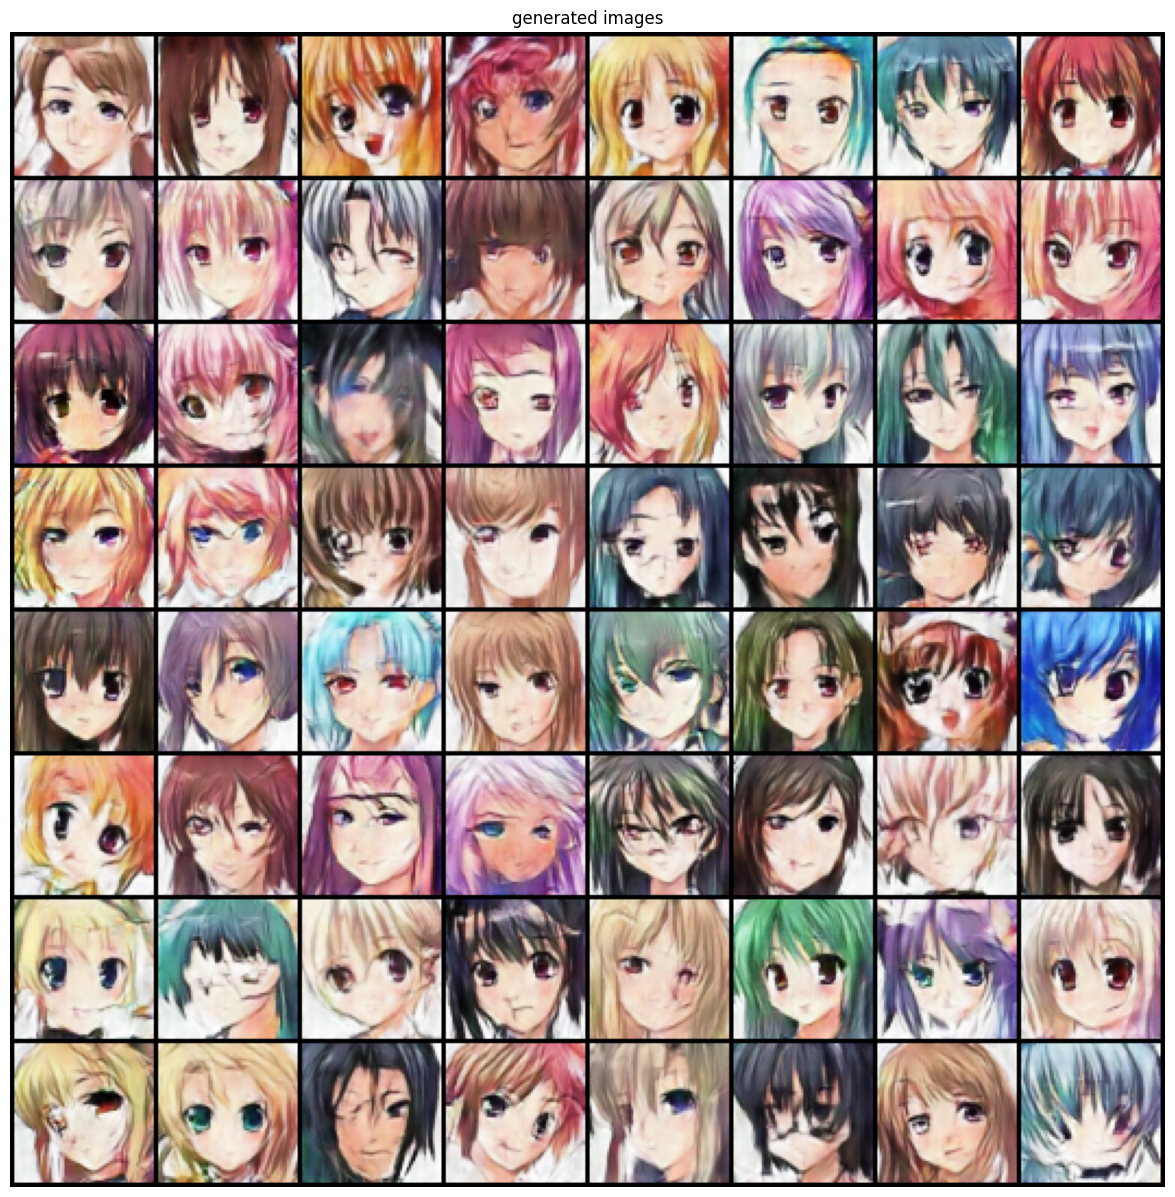

In [32]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title('generated images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()